### General code

In [1]:
# import the models
from cobra.io import load_json_model
ecoli = load_json_model("../ecoli.json")
pf = load_json_model("../pf.json")
# print(ecoli.optimize())
# print(pf.optimize())
    
# load peripheral packages
import warnings
warnings.filterwarnings(action='once')
from pandas import set_option
set_option("display.max_rows", None)
from time import process_time

In [2]:
# Define the standard graphs from each simulation
graphs_list = [
    {
        'trial':'G48',
        "phenotype": '*',
        'content': 'biomass',
        'experimental_data': False,
        # "parsed":True
    },
    {
        'trial':'G48',
        'content': "conc",
    },
    {
        'trial':'G48',
        "phenotype": '*',
        'content': 'biomass',
        "parsed": True
    },
    {
        'trial':'G48',
        'content': 'total_biomass',
        'experimental_data': True
    }
]

def update_graphs(trial):
    graphs = graphs_list.copy()
    for graph in graphs:
        graph["trial"] = trial
    return graphs

#### Maltose & 4HB conditions

In [3]:
species_abundances = {
    1:{"ecoli":0, "pf":1},
    2:{"ecoli":1, "pf":50},
    3:{"ecoli":1, "pf":20},
    4:{"ecoli":1, "pf":10},
    5:{"ecoli":1, "pf":3},
    6:{"ecoli":1, "pf":1},
    7:{"ecoli":3, "pf":1},
    8:{"ecoli":10, "pf":1},
    9:{"ecoli":20, "pf":1},
    10:{"ecoli":1, "pf":0},
    11:{"ecoli":0, "pf":0}
}
carbon_conc_series = {'rows': {
    'cpd00136': {'B':0, 'C': 0, 'D': 1, 'E': 1, 'F': 4, 'G': 4},
    'cpd00179': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
}}
species_identities_rows = {
    1:{"ecoli":"mRuby"},
    2:{"ecoli":"ACS"},
    3:{"ecoli":"mRuby"},
    4:{"ecoli":"ACS"},
    5:{"ecoli":"mRuby"},
    6:{"ecoli":"ACS"}
}

# Maltose

#### coculture

##### All phenotypes

In [ ]:
%%time 

%run ../data/standardized_data/datastandardization.py
growth_data_path="../data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx"
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        ecoli: {
            'name': 'ecoli', 
            'excretions': {
                "cpd00179":["cpd00029"]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                },
        pf: {'name': 'pf'}
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
    species_abundances = species_abundances,
    carbon_conc_series = carbon_conc_series,
    ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,4,5,6,8,9,10,11,12]},
    species_identities_rows = species_identities_rows
)

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommPhitting\data\standardized_data\datastandardization.py:113: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)



 GCF_000005845.2.RAST.mdl


In [ ]:
print(list(ecoli.reactions.EX_cpd00007_e0.metabolites)[0].name)

In [ ]:
# display(fluxes_df)
# display(growth_df)
# display(requisite_biomass)
# display(experimental_metadata)
# display(standardized_carbon_conc)

In [ ]:
%run ../mscommphitting.py

def _partition_coefs(initial_val, divisor):
    return (initial_val, initial_val/divisor, initial_val/divisor**2, initial_val/divisor**3, initial_val/divisor**4)

maltose_co = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
maltose_co.define_problem(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
    mets_to_track = ["cpd00179","cpd00029"],
    rel_final_conc = {"cpd00179":0.1},
    zero_start = ["cpd00029", "cpd00136"],
    abs_final_conc = {"cpd00029":0}, # metabolomics data
    export_zip_name = 'maltose_co.zip',
    requisite_biomass = requisite_biomass,
    biomass_coefs=_partition_coefs(1, 2),
    export_lp = "maltose_coculture.lp"
)

In [ ]:
maltose_co.compute(update_graphs("G6"), None, None, True, "test_primals.json")

##### Specified phenotypes

In [4]:
%%time 

%run ../data/standardized_data/datastandardization.py
growth_data_path="../data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx"
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        ecoli: {
            'name': 'ecoli', 
            'phenotypes': {
                'Maltose': {"consumed":["cpd00179"],
                         "excreted":["cpd00029"]}, #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                'Acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                }
        },
        pf: {
            'name': 'pf',
            'phenotypes': {
                'Acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                '4-Hydroxybenzoate': {"consumed":["cpd00136"]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
    species_abundances = species_abundances,
    carbon_conc_series = carbon_conc_series,
    ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,4,5,6,8,9,10,11,12]},
    species_identities_rows = species_identities_rows
)

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommPhitting\data\standardized_data\datastandardization.py:113: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)



 GCF_000005845.2.RAST.mdl

 GCF_001612705.1.RAST.mdl
The ['B2', 'B3', 'B4', 'B5', 'B6', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements per the ignore_trials parameter.
The [97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166] timesteps (with [1.12550559 1.12537038 1.12105398 1.11597471 1.11273534 1.12893569
 1.13334937 1.133368

In [ ]:
%%time

%run ../mscommphitting.py

def _partition_coefs(initial_val, divisor):
    return (initial_val, initial_val/divisor, initial_val/divisor**2, initial_val/divisor**3, initial_val/divisor**4)

maltose_co = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
maltose_co.define_problem(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
    mets_to_track = ["cpd00179","cpd00029"],
    rel_final_conc = {"cpd00179":0.1},
    zero_start = ["cpd00029", "cpd00136"],
    abs_final_conc = {"cpd00029":0}, # metabolomics data
    export_zip_name = 'maltose_co.zip',
    requisite_biomass = requisite_biomass,
    biomass_coefs=_partition_coefs(1, 2),
    export_lp = "maltose_coculture_simple.lp"
)

In [ ]:
%%time 

maltose_co.compute(update_graphs("G6"), None, None, True, "test_primals_simple.json")

In [ ]:
%run ../mscommphitting.py

# define parameters
data_timesteps: dict = None
export_zip_name: str = None
export_parameters: bool = True
export_lp: str = f'solveKcat.lp'
publishing=True
primals_export_path=None

parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3}
mets_to_track = ["cpd00179","cpd00029"]
rel_final_conc = {"cpd00179":0.1}
zero_start = ["cpd00029", "cpd00136"]
abs_final_conc = {"cpd00029":0} # metabolomics data
graphs = update_graphs("G6")
export_zip_name = 'maltose_co.zip' 
requisite_biomass = requisite_biomass
export_lp = "maltose_coculture.lp"


biomass_partition_coefs = [_partition_coefs(100, 10), _partition_coefs(4, 2), _partition_coefs(1, 2)]
kcat_primal = None

def _partition_coefs(initial_val, divisor):
    return (initial_val, initial_val/divisor, initial_val/divisor**2, initial_val/divisor**3, initial_val/divisor**4)

    
for index, coefs in enumerate(biomass_partition_coefs):
    # solve for growth rate constants with the previously solved biomasses
    new_simulation = CommPhitting(FBAHelper.parse_df(fluxes_df), standardized_carbon_conc, media_conc,
                                  '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
    new_simulation.define_problem(
        parameters, mets_to_track, rel_final_conc, zero_start, abs_final_conc,
        data_timesteps, export_zip_name, export_parameters, export_lp, kcat_primal, coefs, requisite_biomass)
    time1 = process_time()
    primals_export_path = primals_export_path or re.sub(r"(.lp)", ".json", export_lp)
    new_simulation.compute(graphs, export_zip_name, None, publishing, primals_export_path)
    kcat_primal = parse_primals(new_simulation.values, "kcat", coefs, new_simulation.parameters["kcat"])
    time2 = process_time()
    print(f"Done simulating with the coefficients for biomass partitions: {index}"
          f"\n{(time2-time1)/60} minutes")
    pprint(kcat_primal)
return {k: val for k, val in new_simulation.values.items() if "kcat" in k}
# maltose_co.compute(update_graphs("G6"))

# THIS RUN WAS TERMINATED AFTER 27250 SECONDS

### Solve for kinetics

In [ ]:
%run ../mscommphitting.py

maltose_co = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
maltose_co.fit_kcat(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
    mets_to_track = ["cpd00179","cpd00029"],
    rel_final_conc = {"cpd00179":0.1},
    zero_start = ["cpd00029", "cpd00136"],
    abs_final_conc = {"cpd00029":0}, # metabolomics data
    graphs = update_graphs("G6"),
    export_zip_name = 'maltose_co.zip', 
    requisite_biomass = requisite_biomass,
    export_lp = "maltose_coculture_kinetics.lp")

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommPhitting\mscommphitting.py:80: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


Done with concentrations and biomass loops: 0.016927083333333332 min
Done with DCC loop: 0.0015625 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.13984375 min
Done exporting the content: 0.06432291666666666 min
starting optimization
maltose_co.zip
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G6'}


C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommPhitting\mscommphitting.py:80: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Maltose'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Acetate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_Acetate'
ic| mscommphitting.py:1077 in graph()
    basename: 'b_pf_4~Hydroxybenzoate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_stationary'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_stationary'
ic| mscommphitting.py:1148 in graph()- name: 'OD'
ic| mscommphitting.py:1148 in graph()- name: 'pf'
ic| mscommphitting.py:1148 in graph()- name: 'ecoli'


{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179', 'cpd00029'],
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'trial': 'G6'}
graph_2
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'so

ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Maltose'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Acetate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_Acetate'
ic| mscommphitting.py:1077 in graph()
    basename: 'b_pf_4~Hydroxybenzoate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_stationary'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_stationary'
ic| mscommphitting.py:1148 in graph()- name: 'OD'
ic| mscommphitting.py:1148 in graph()- name: 'pf'


{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}


ic| mscommphitting.py:1148 in graph()- name: 'ecoli'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Maltose'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Acetate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_Acetate'
ic| mscommphitting.py:1077 in graph()
    basename: 'b_pf_4~Hydroxybenzoate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_stationary'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_stationary'
ic| mscommphitting.py:1148 in graph()- name: 'OD'
ic| mscommphitting.py:1148 in graph()- name: 'pf'
ic| mscommphitting.py:1148 in graph()- name: 'ecoli'


graph_3
{'content': 'total_biomass',
 'experimental_data': True,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G6'}
Optimization completed in 34.41875 minutes
Graphing completed in 0.019791666666666666 minutes
0 1.0
0 1.0
0 0.0
0.33 1.0
0.33 1.0
0 1.0
0 0.0
3.3000000000000003 1.0
3.3000000000000003 1.0
3.3000000000000003 0.0
0 1.0
0 1.0
0 0.0
0.33 1.0
0.33 1.0
0 0.0
33.0 0.0
36.3 0.0
36.629999999999995 0.0
36.663 0.0
Done simulating with the coefficients for biomass partitions: 0
34.438541666666666 minutes
{'ecoli': {'Acetate': 3.3033, 'Maltose': 0.33},
 'pf': {'4~Hydroxybenzoate': 36

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'maltose_coculture_kinetics.lp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.12161458333333333 min
starting optimization


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'maltose_coculture_kinetics.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Maltose'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Acetate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_Acetate'
ic| mscommphitting.py:1077 in graph()
    basename: 'b_pf_4~Hydroxybenzoate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_stationary'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_stationary'
ic| mscommphitting.py:1148 in graph()- name: 'OD'
ic| mscommphitting.py:1148 in graph()- name: 'pf'
ic| mscommphitting.py:1148 in graph()- name: 'ecoli'


maltose_co.zip
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G6'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
graph_1
{'content': 'conc',
 'experimental_d

ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Maltose'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Acetate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_Acetate'
ic| mscommphitting.py:1077 in graph()
    basename: 'b_pf_4~Hydroxybenzoate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_stationary'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_stationary'
ic| mscommphitting.py:1148 in graph()- name: 'OD'
ic| mscommphitting.py:1148 in graph()- name: 'pf'


{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}
{'stationary', '4~Hydroxybenzoate', 'Maltose', 'Acetate'}


ic| mscommphitting.py:1148 in graph()- name: 'ecoli'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Maltose'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_Acetate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_Acetate'
ic| mscommphitting.py:1077 in graph()
    basename: 'b_pf_4~Hydroxybenzoate'
ic| mscommphitting.py:1077 in graph()- basename: 'b_pf_stationary'
ic| mscommphitting.py:1077 in graph()- basename: 'b_ecoli_stationary'
ic| mscommphitting.py:1148 in graph()- name: 'OD'
ic| mscommphitting.py:1148 in graph()- name: 'pf'
ic| mscommphitting.py:1148 in graph()- name: 'ecoli'


graph_3
{'content': 'total_biomass',
 'experimental_data': True,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G6'}


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_all species_stationary,4~Hydroxybenzoate,Maltose,Acetate phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_cpd00179,cpd00029_c.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_all species_OD,pf,ecoli_total_biomass.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_ecoli_stationary,4~Hydroxybenzoate,Maltose,Acetate phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Pytho

Optimization completed in 28.571354166666666 minutes
Graphing completed in 0.01328125 minutes
0 1.0
0 1.0
0 1.0
0 0.0
0.165 0.0
0 1.0
0 1.0
0 1.0
0 0.0
1.65165 0.0
0 1.0
0 1.0
0 0.0
0.33 1.0
0.33 1.0
0 0.0
146.6652 0.0
219.99779999999998 0.0
256.66409999999996 0.0
274.99724999999995 0.0
Done simulating with the coefficients for biomass partitions: 1
28.584635416666668 minutes
{'ecoli': {'Acetate': 2.477475, 'Maltose': 0.2475},
 'pf': {'4~Hydroxybenzoate': 284.163825, 'Acetate': 0.33}}
Done with concentrations and biomass loops: 0.01796875 min
Done with DCC loop: 0.0015625 min
Done with the DBC & diffc loop: 0.004166666666666667 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.16744791666666667 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'maltose_coculture_kinetics.lp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


#### Pseudomonas

In [ ]:
%run ../data/standardized_data/datastandardization.py
growth_data_path="../data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx"
time1 = process_time()
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        pf: {
            'name': 'pf',
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                '4HB': {"consumed":["cpd00136"]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'mNeonGreen':'pf'},
    species_abundances = species_abundances,
    carbon_conc_series = carbon_conc_series,
    ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,3,4,5,6,7,8,9,10,11,12]},
    species_identities_rows = species_identities_rows,
    significant_deviation=None
)

In [ ]:
%run ../mscommphitting.py

maltose_pf = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, growth_df, experimental_metadata)
try:
    if all([not y for x in requisite_biomass.values() for y in x.values()]):
        raise TypeError("Pseudomonas cannot grow in this media.")
    maltose_pf.fit_kcat(
        parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
        mets_to_track = ["cpd00179","cpd00029"],
        rel_final_conc = {"cpd00179":0.2},
        zero_start = ["cpd00029"],
        abs_final_conc = {"cpd00029":0.1}, # metabolomics data
        graphs = update_graphs("G1"),
        msdb_path = '../../../../ModelSEED/ModelSEEDDatabase',
        export_zip_name = 'simple_kinetics_loop.zip', 
        requisite_biomass = requisite_biomass,
        publishing = True,
        export_lp = "maltose_pf.lp")
except (NoFluxError, FeasibilityError, TypeError) as e:
    print(e)

#### E. coli

In [ ]:
%run ../data/standardized_data/datastandardization.py
growth_data_path="../data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx"
time1 = process_time()
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        ecoli: {
            'name': 'ecoli', 
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                'malt': {"consumed":["cpd00179"],
                         "excreted":["cpd00029"]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
            }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'mRuby':'ecoli'},
    species_abundances = species_abundances,
    carbon_conc_series = carbon_conc_series,
    ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,4,5,6,7,8,9,10,12]},
    species_identities_rows = species_identities_rows
)

In [ ]:
%run ../mscommphitting.py

maltose_ecoli = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
maltose_ecoli.fit_kcat(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
    mets_to_track = ["cpd00179","cpd00029"],
    rel_final_conc = {"cpd00179":0.2},
    zero_start = ["cpd00029", "cpd00136"],
    abs_final_conc = {"cpd00029":0.1}, # metabolomics data
    graphs = update_graphs("G10"),
    export_zip_name = 'maltose_ecoli.zip', 
    requisite_biomass = requisite_biomass,
    publishing = True,
    export_lp = "maltose_ecoli.lp")

# Maltose + 4HB

#### Coculture


 GCF_000005845.2.RAST.mdl
EX_cpd00179_e0
EX_cpd00029_e0

 GCF_001612705.1.RAST.mdl
EX_cpd00029_e0
EX_cpd00136_e0


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


The ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements per the ignore_trials parameter.
The [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166] timesteps (with [1.3359766  1.33383279 1.33191936 1.33542535 1.33589122 1.33709047
 1.33655114 1.33934319 1.3379035  1.3391911  1.33787811 1.336871
 

ecoli_Maltose  ecoli_Acetate    pf_Acetate  \
rxn                                                          
EX_cpd00001_e0   1.618125e+01   4.544367e+01  4.533296e+01   
EX_cpd00007_e0  -6.452599e+00  -2.035609e+01 -2.025521e+01   
EX_cpd00009_e0  -7.625410e-01  -7.625410e-01 -7.625410e-01   
EX_cpd00011_e0   1.073081e+00   2.388151e+01  2.377641e+01   
EX_cpd00013_e0  -8.611666e+00  -8.611666e+00 -8.611666e+00   
EX_cpd00029_e0   1.051566e+01  -3.069851e+01 -3.063614e+01   
EX_cpd00030_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00034_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00047_e0   1.781127e+01   0.000000e+00  0.000000e+00   
EX_cpd00048_e0  -2.263972e-01  -2.263972e-01 -2.263972e-01   
EX_cpd00058_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00063_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00067_e0   3.485430e+01  -2.417395e+01 -2.411719e+01   
EX_cpd00099_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00116_e0   2.806159e-03   2.806159e-03  2.806159e-03   
EX_cpd00136_e0   0.000000e+00   0.000000e+00  0.000000e+00   
EX_cpd00142_e0  -2.155574e-12   0.000000e+00  0.000000e+00   
EX_cpd00149_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00179_e0  -6.452599e+00   0.000000e+00  0.000000e+00   
EX_cpd00205_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00254_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00609_e0   1.080143e-15   0.000000e+00  0.000000e+00   
EX_cpd00751_e0   5.380949e-29   0.000000e+00  0.000000e+00   
EX_cpd01914_e0   1.315265e-12   0.000000e+00  0.000000e+00   
EX_cpd03048_e0   6.972492e-13   0.000000e+00  0.000000e+00   
EX_cpd10515_e0  -8.418477e-03  -1.122464e-02 -1.122464e-02   
EX_cpd10516_e0  -2.806159e-03  -1.359101e-11  4.321634e-12   
EX_cpd15378_e0   2.806159e-03   2.806159e-03  0.000000e+00   
bio              1.000000e+00   1.000000e+00  1.000000e+00   

                pf_4~Hydroxybenzoate  
rxn                                   
EX_cpd00001_e0          2.449548e+01  
EX_cpd00007_e0         -5.333079e+01  
EX_cpd00009_e0         -7.625410e-01  
EX_cpd00011_e0          5.685199e+01  
EX_cpd00013_e0         -8.611666e+00  
EX_cpd00029_e0          0.000000e+00  
EX_cpd00030_e0         -2.806159e-03  
EX_cpd00034_e0         -2.806159e-03  
EX_cpd00047_e0          0.000000e+00  
EX_cpd00048_e0         -2.263972e-01  
EX_cpd00058_e0         -2.806159e-03  
EX_cpd00063_e0         -2.806159e-03  
EX_cpd00067_e0         -2.043758e+01  
EX_cpd00099_e0         -2.806159e-03  
EX_cpd00116_e0          2.806159e-03  
EX_cpd00136_e0         -1.347827e+01  
EX_cpd00142_e0          0.000000e+00  
EX_cpd00149_e0         -2.806159e-03  
EX_cpd00179_e0          0.000000e+00  
EX_cpd00205_e0         -2.806159e-03  
EX_cpd00254_e0         -2.806159e-03  
EX_cpd00609_e0          0.000000e+00  
EX_cpd00751_e0          0.000000e+00  
EX_cpd01914_e0          0.000000e+00  
EX_cpd03048_e0          0.000000e+00  
EX_cpd10515_e0         -1.122464e-02  
EX_cpd10516_e0         -3.288257e-13  
EX_cpd15378_e0          0.000000e+00  
bio                     1.000000e+00

['cpd00179', 'cpd00136', 'cpd00029']
Done with concentrations and biomass loops: 0.020052083333333335 min
Done with DCC loop: 0.003125 min
Done with the DBC & diffc loop: 0.0046875 min
Done with constructing the <class 'optlang.glpk_interface.Model'> model: 0.17708333333333334 min
Done exporting the content: 0.06510416666666667 min
starting optimization


C:\Users\Andrew Freiburger\Documents\Argonne\ModelSEED\ModelSEEDpy\modelseedpy\community\mscommphitting.py:899: UserWarning: The conversion factor 5e-06 optimized to a bound, which may be indicative of an error, such as improper kinetic rates.
  else:


maltose_4HB_co.zip
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'stationary', 'Acetate', '4~Hydroxybenzoate', 'Maltose'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G52'}
graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179',
          'cpd00136',
          'Maltose',
          'Acetate',
          'Acetate',
          '4-Hydroxybenzoate'],
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                       

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'maltose_4HB_co.lp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.065625 min
starting optimization


C:\Users\Andrew Freiburger\Documents\Argonne\ModelSEED\ModelSEEDpy\modelseedpy\community\mscommphitting.py:899: UserWarning: The conversion factor 5e-06 optimized to a bound, which may be indicative of an error, such as improper kinetic rates.
  else:
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'maltose_4HB_co_primals.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


maltose_4HB_co.zip
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'stationary', 'Acetate', '4~Hydroxybenzoate', 'Maltose'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G52'}
graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179',
          'cpd00136',
          'Maltose',
          'Acetate',
          'Acetate',
          '4-Hydroxybenzoate'],
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                       

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G52_pf_stationary,Acetate,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G52_cpd00179,cpd00136,Maltose,Acetate,Acetate,4-Hydroxybenzoate_c.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G52_OD_stationary,Acetate,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G52_all species_stationary,Acetate,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zi

Optimization completed in 2.5205729166666666 minutes
Graphing completed in 0.01484375 minutes
{'ecoli': {'Acetate': 0.0008250000000000001, 'Maltose': 16.5},
 'pf': {'4~Hydroxybenzoate': 0.33, 'Acetate': 1.6500000000000001}}
Interation 2 is complete

['cpd00179', 'cpd00136', 'cpd00029']
Done with concentrations and biomass loops: 0.020833333333333332 min
Done with DCC loop: 0.0036458333333333334 min
Done with the DBC & diffc loop: 0.0046875 min
Done with constructing the <class 'optlang.glpk_interface.Model'> model: 0.11875 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'maltose_4HB_co.lp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.06510416666666667 min
starting optimization


C:\Users\Andrew Freiburger\Documents\Argonne\ModelSEED\ModelSEEDpy\modelseedpy\community\mscommphitting.py:899: UserWarning: The conversion factor 5e-06 optimized to a bound, which may be indicative of an error, such as improper kinetic rates.
  else:
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'maltose_4HB_co_primals.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


maltose_4HB_co.zip
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'stationary', 'Acetate', '4~Hydroxybenzoate', 'Maltose'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G52'}
graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179',
          'cpd00136',
          'Maltose',
          'Acetate',
          'Acetate',
          '4-Hydroxybenzoate'],
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                       

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G52_pf_stationary,Acetate,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G52_cpd00179,cpd00136,Maltose,Acetate,Acetate,4-Hydroxybenzoate_c.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G52_OD_stationary,Acetate,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G52_all species_stationary,Acetate,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zi

{}

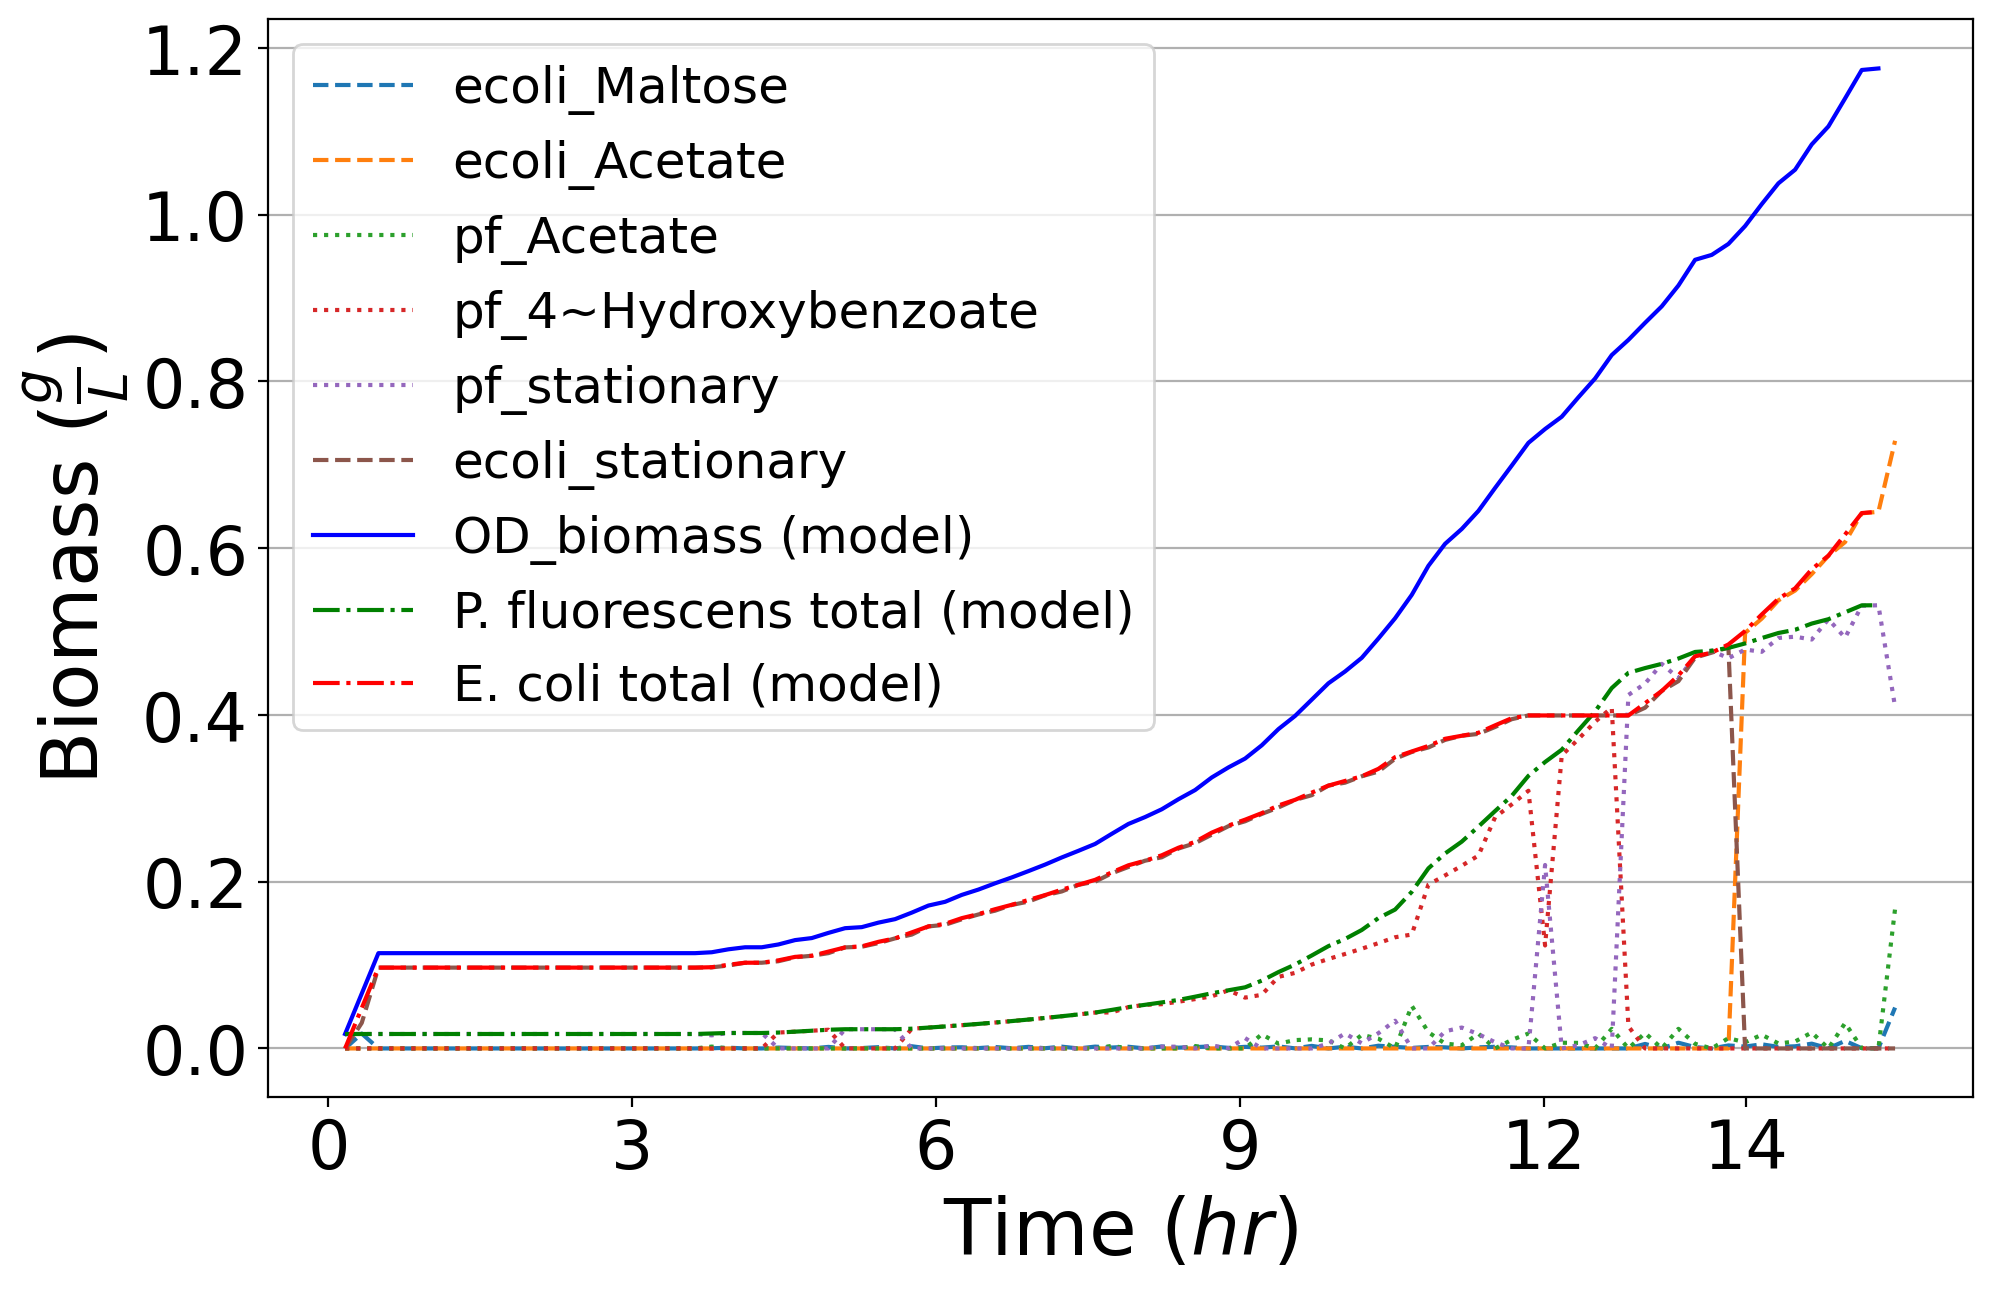

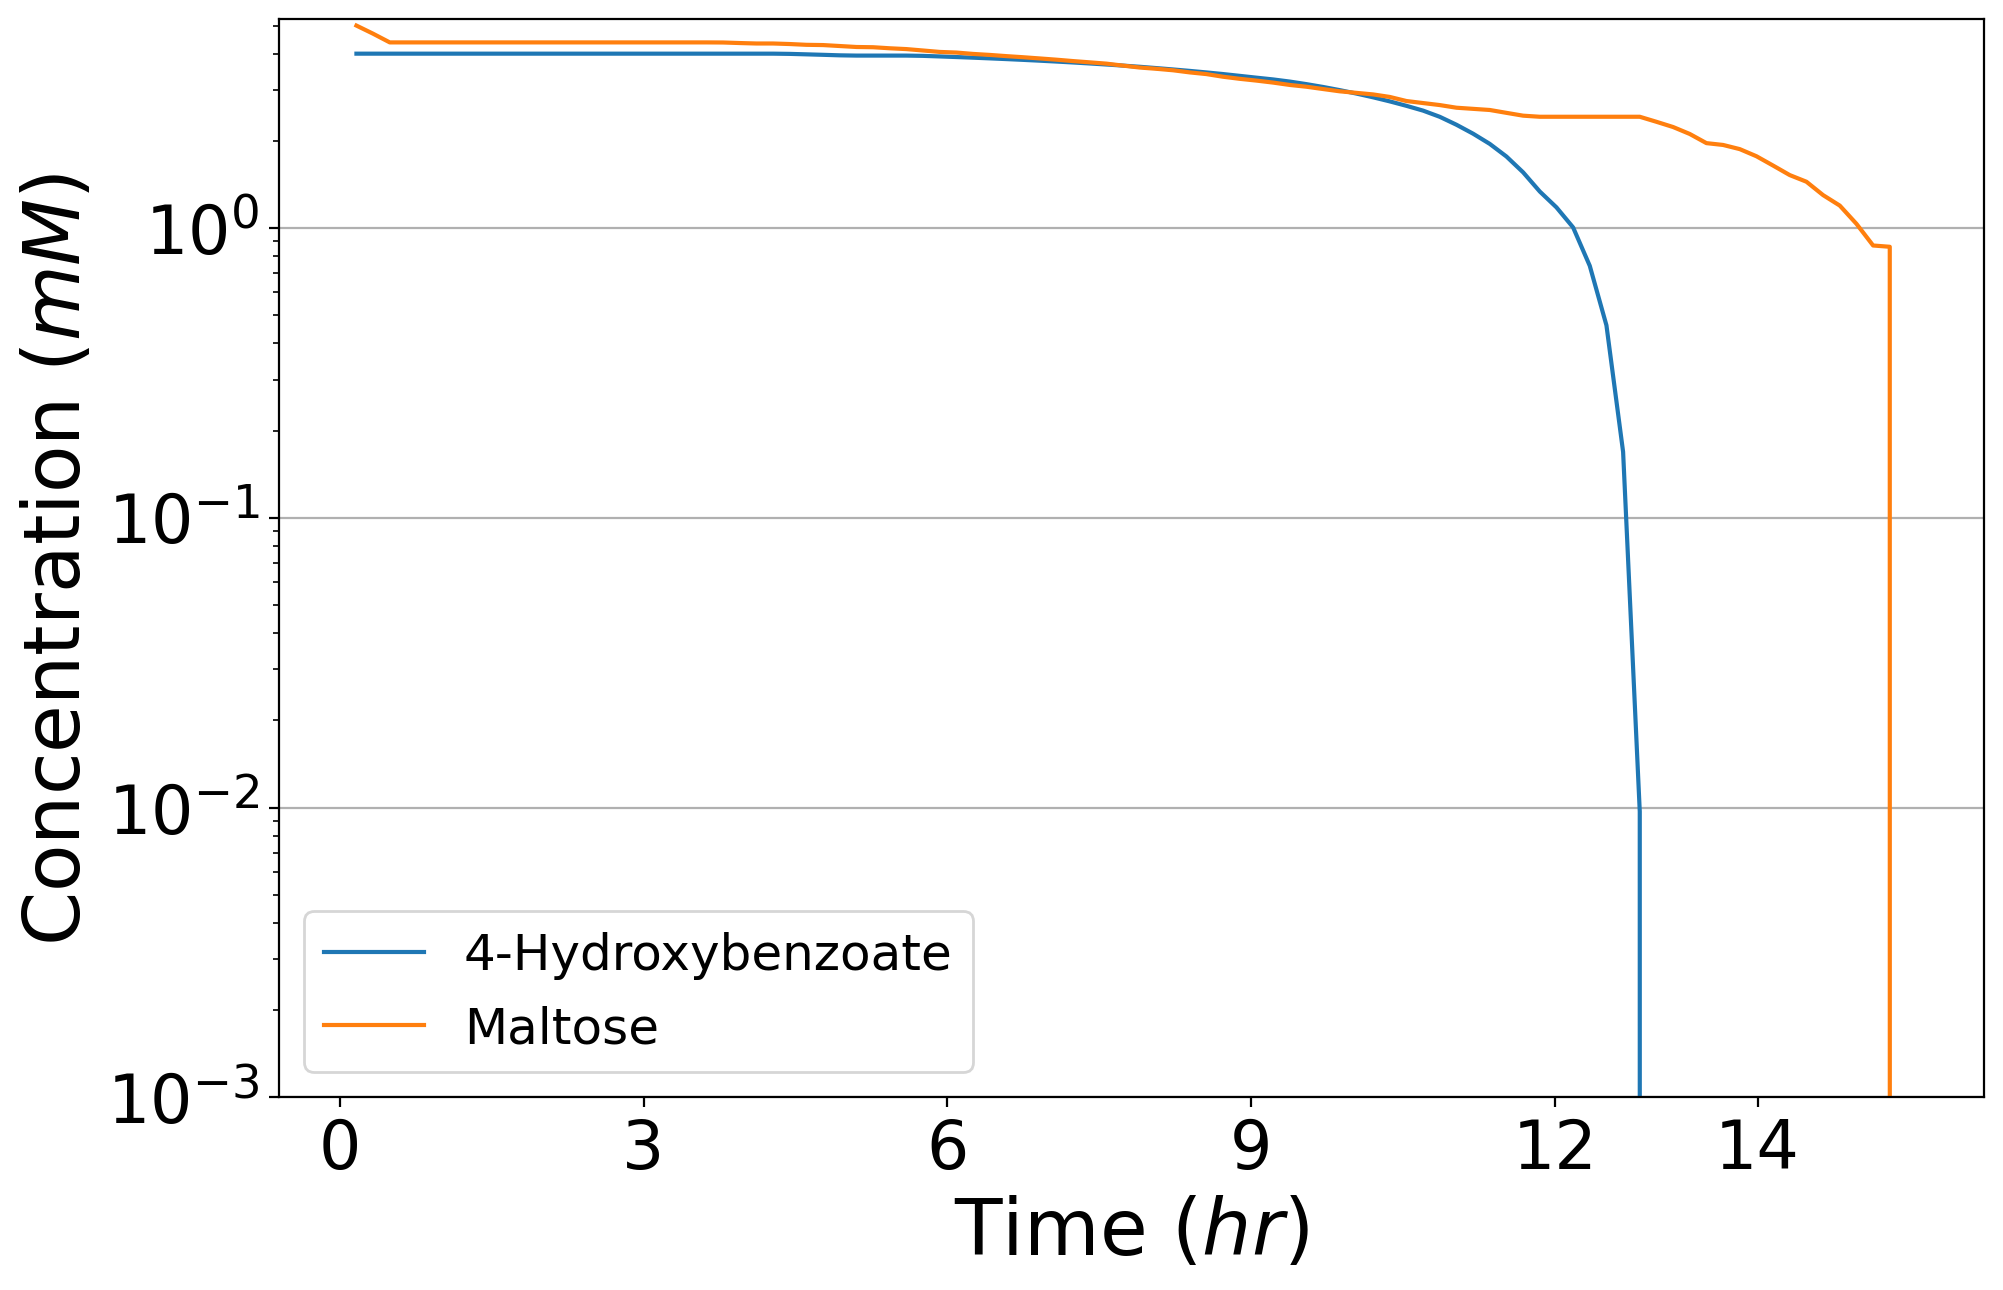

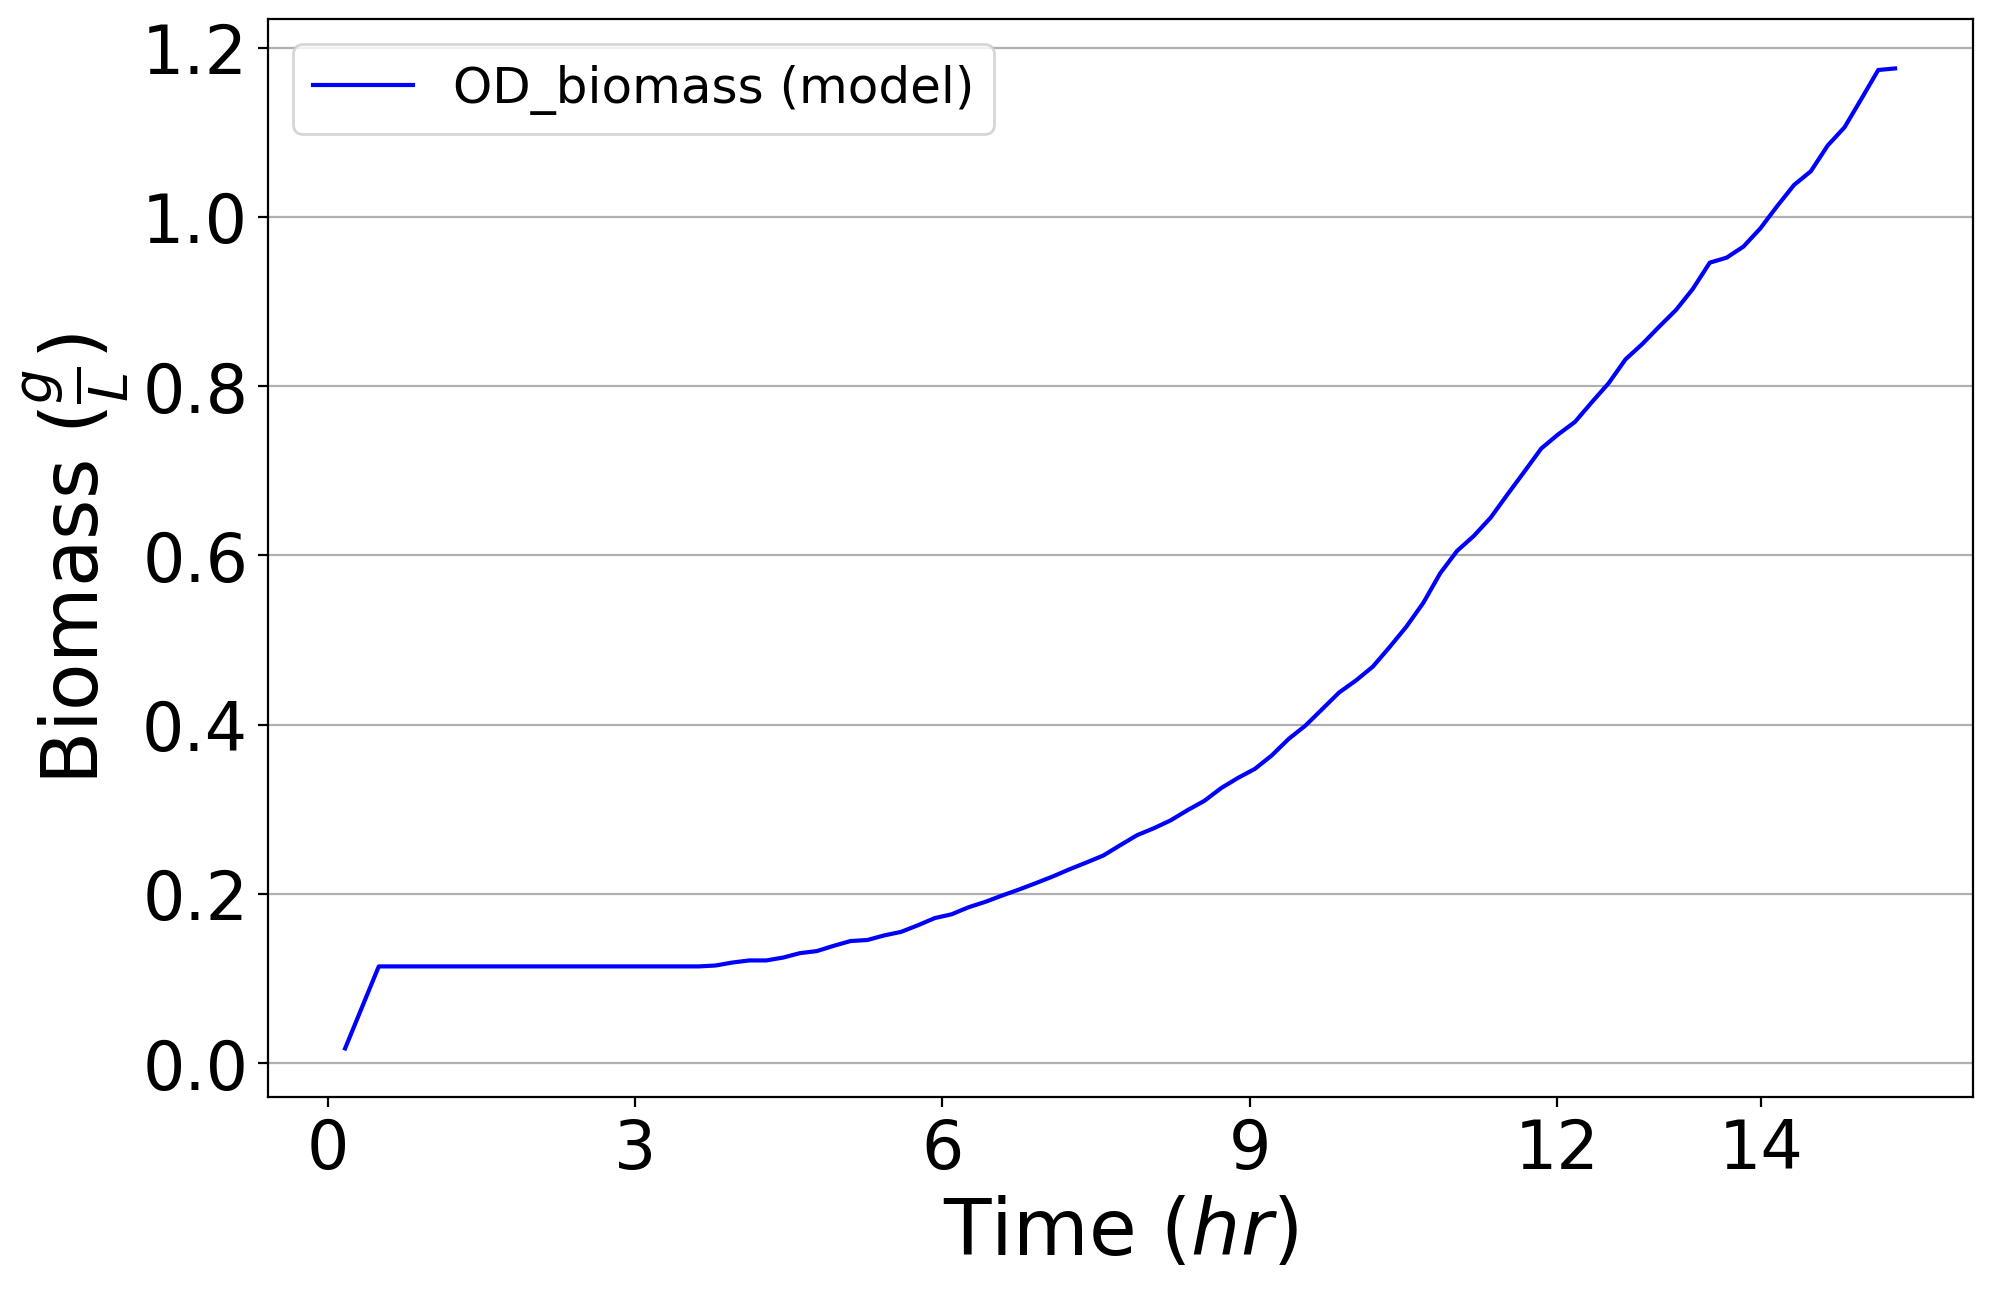

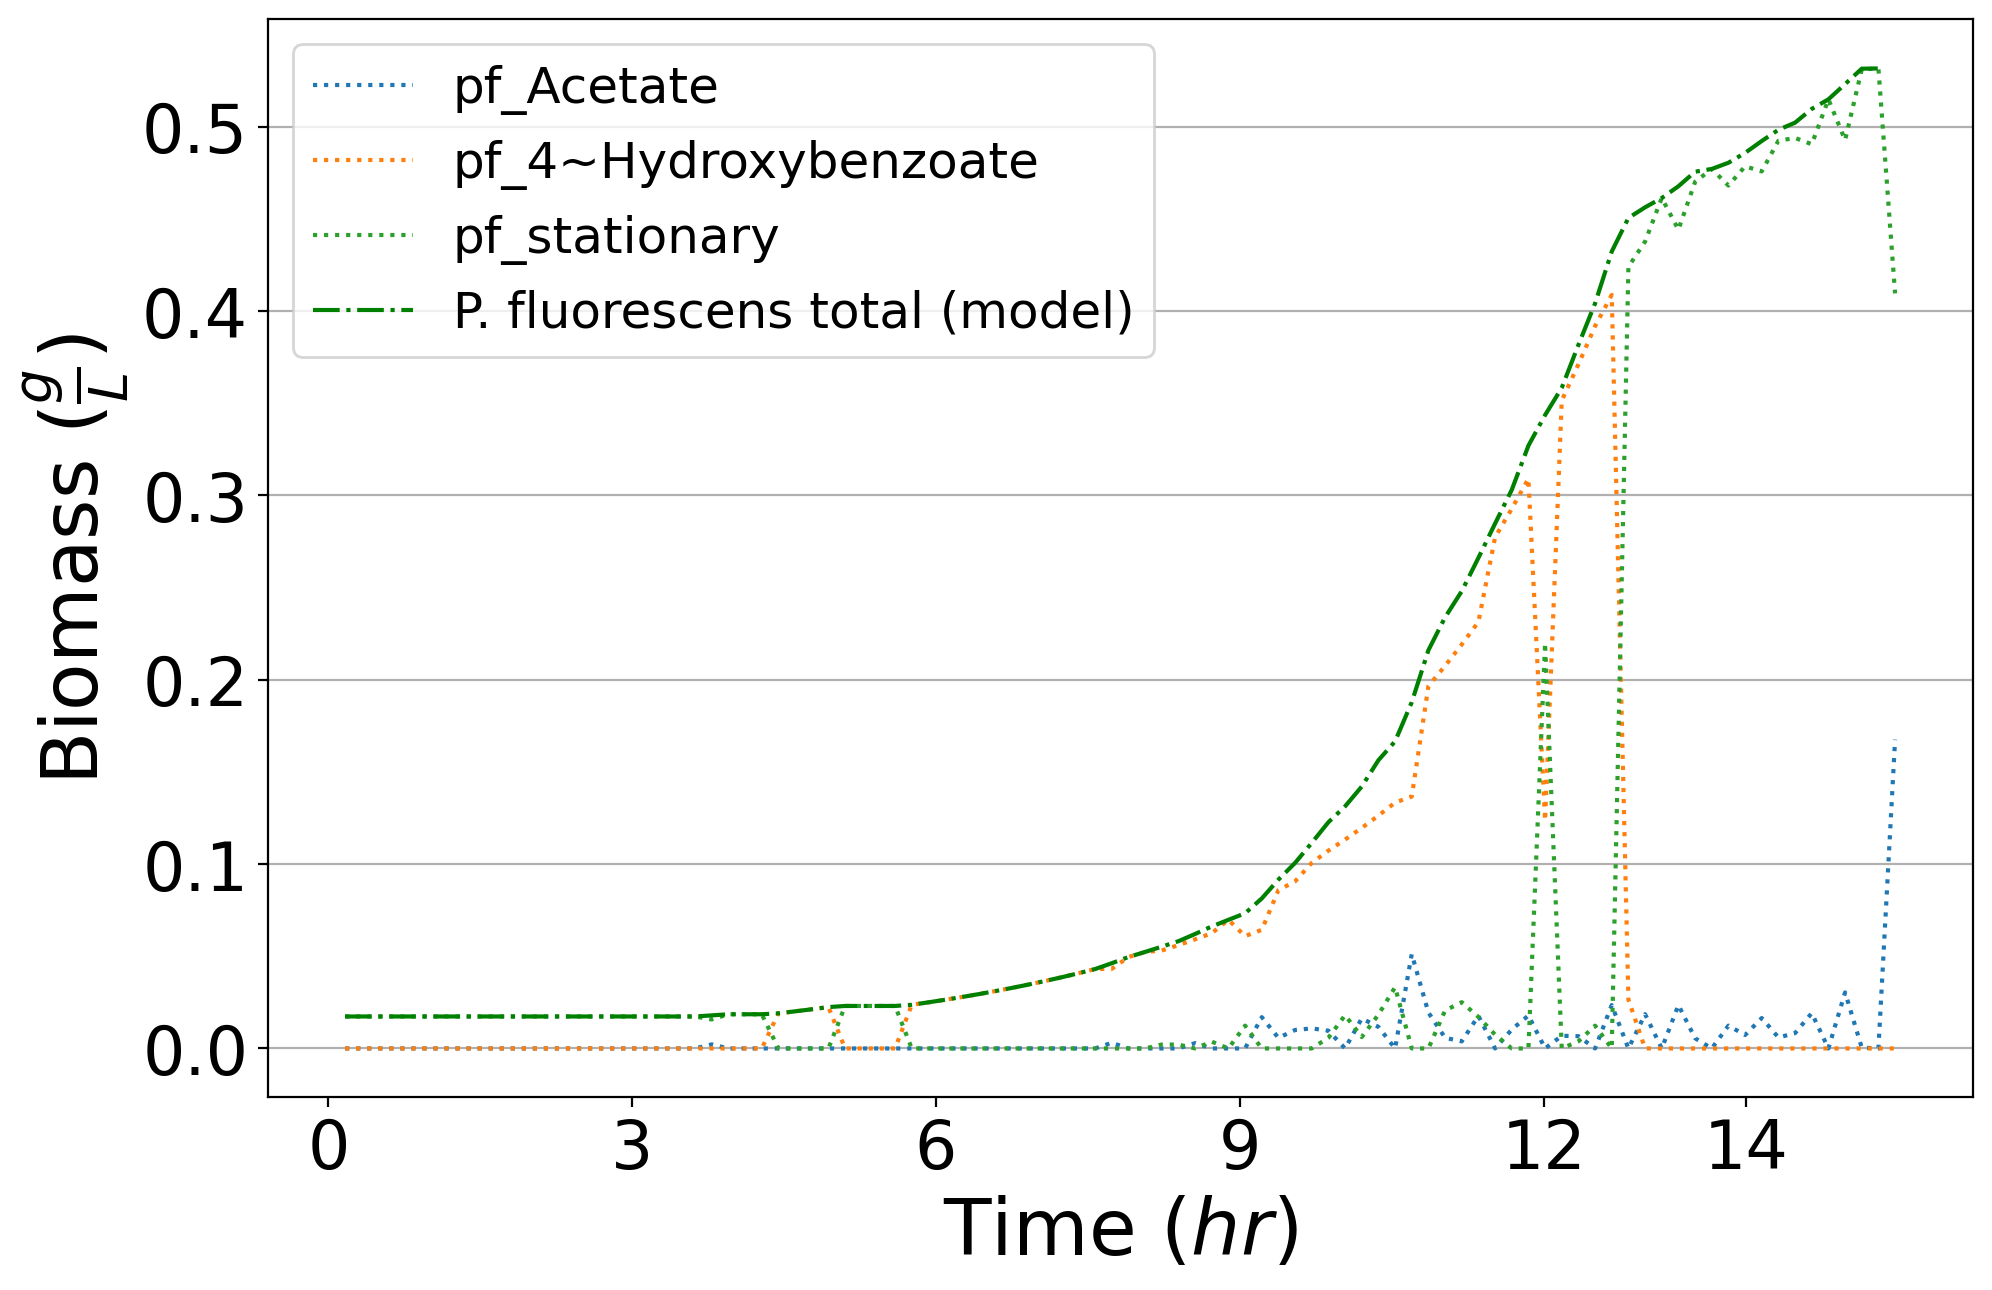

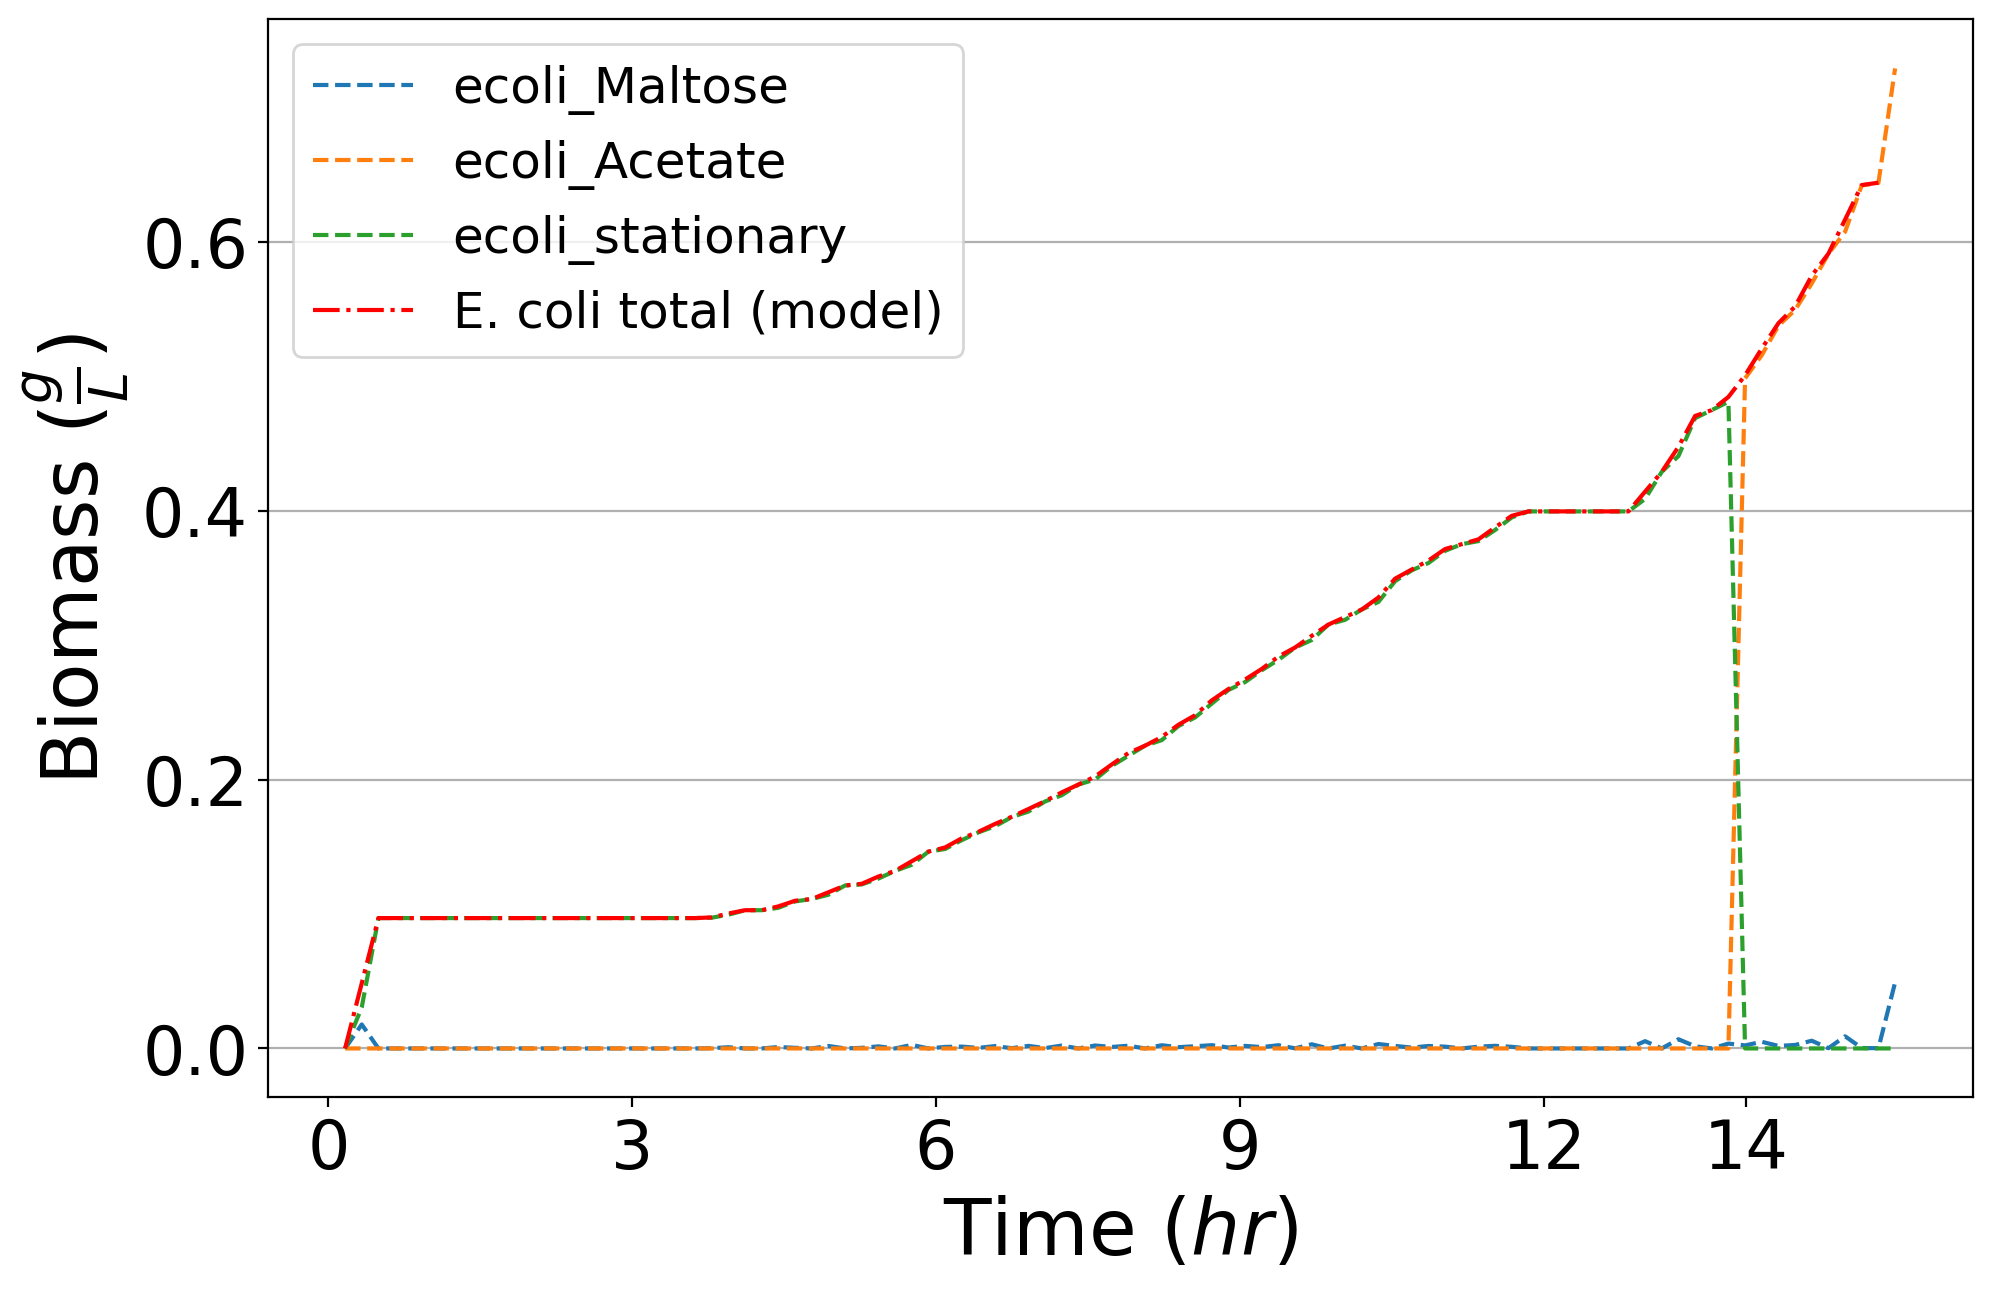

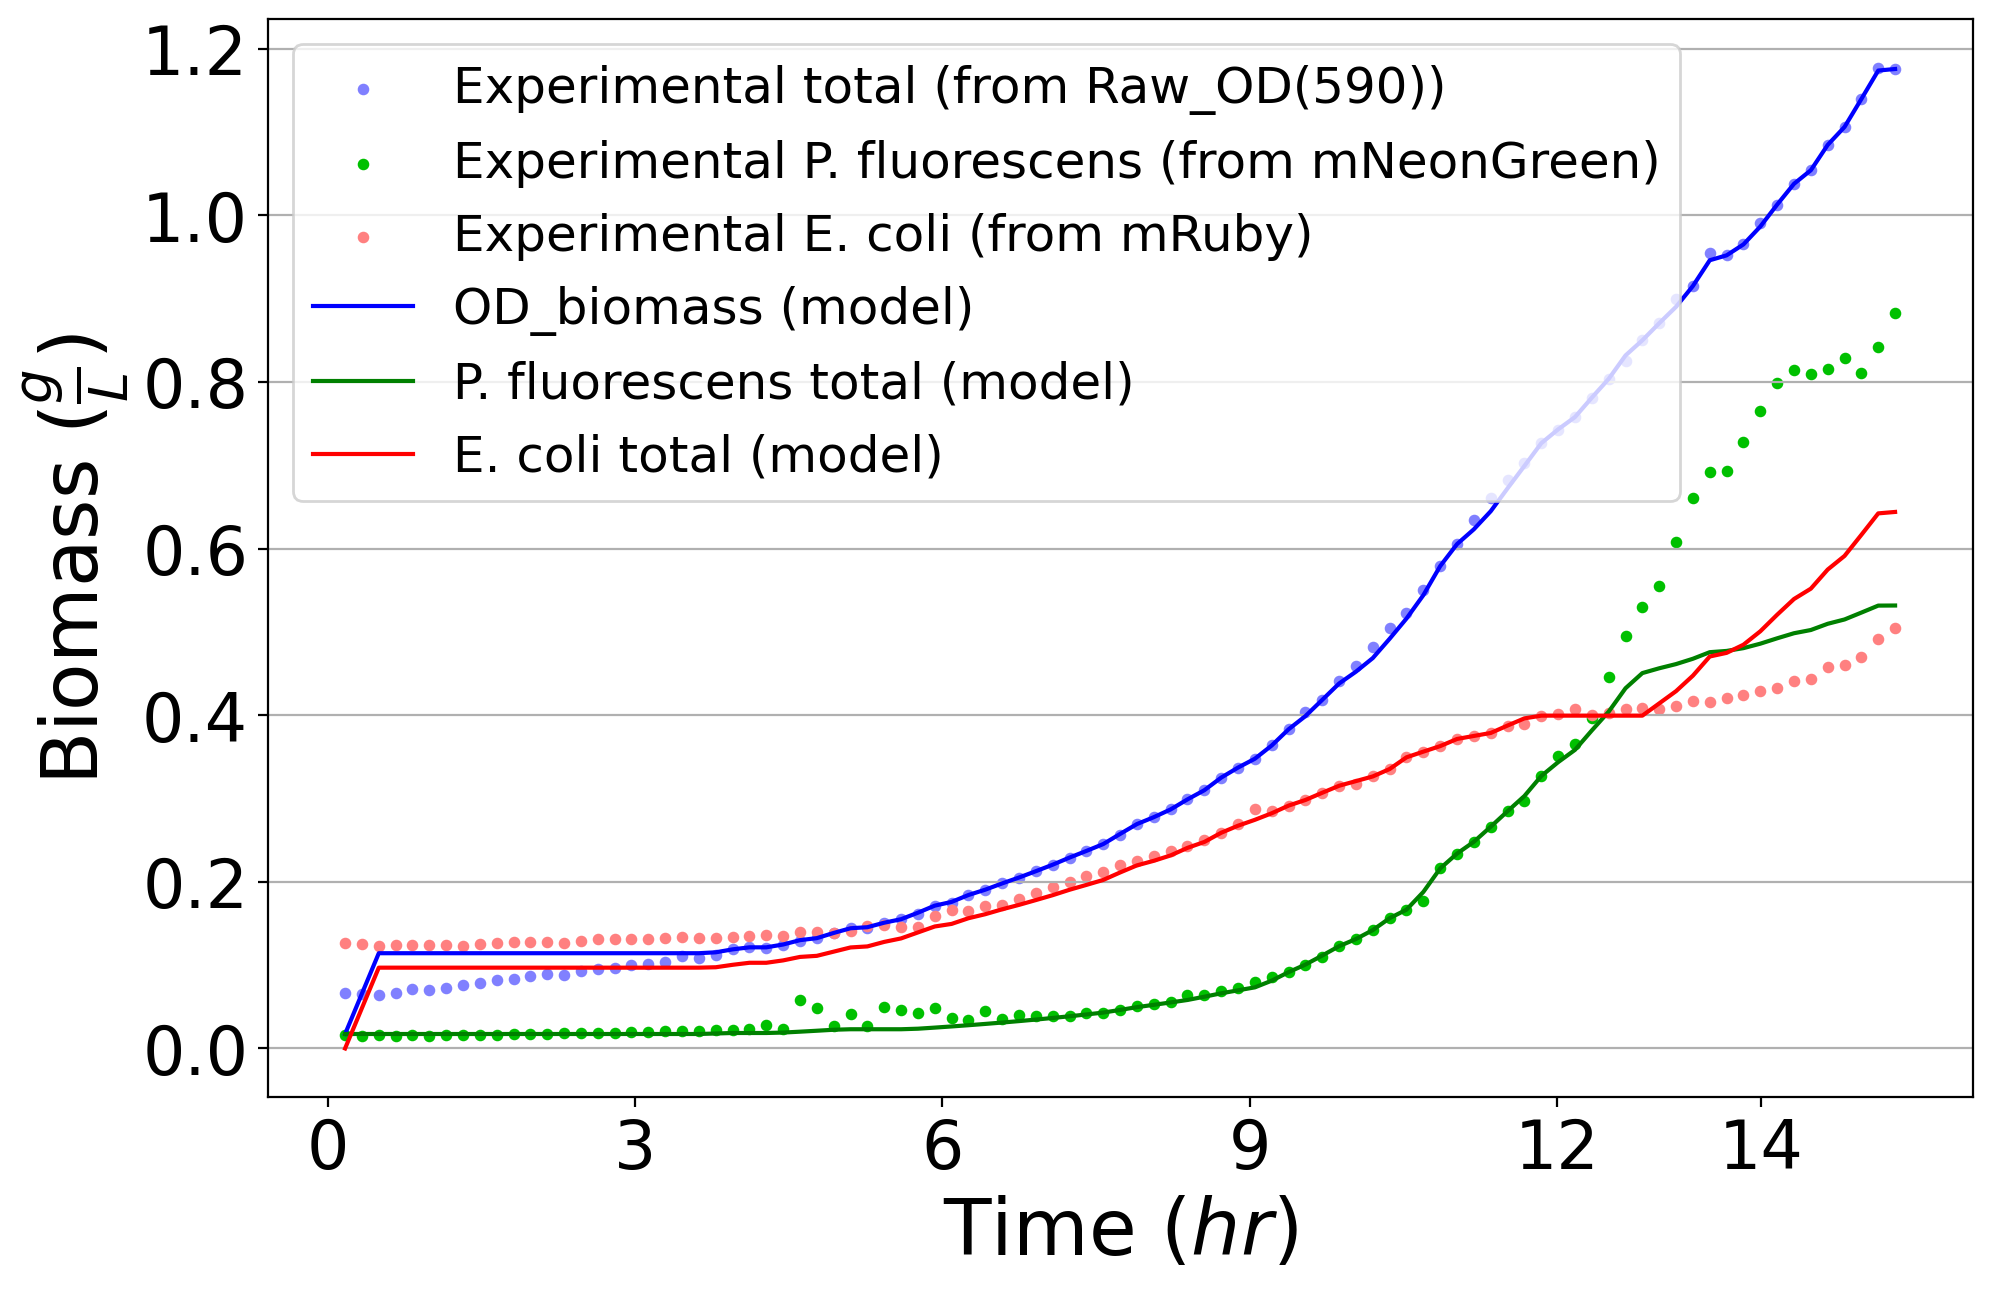

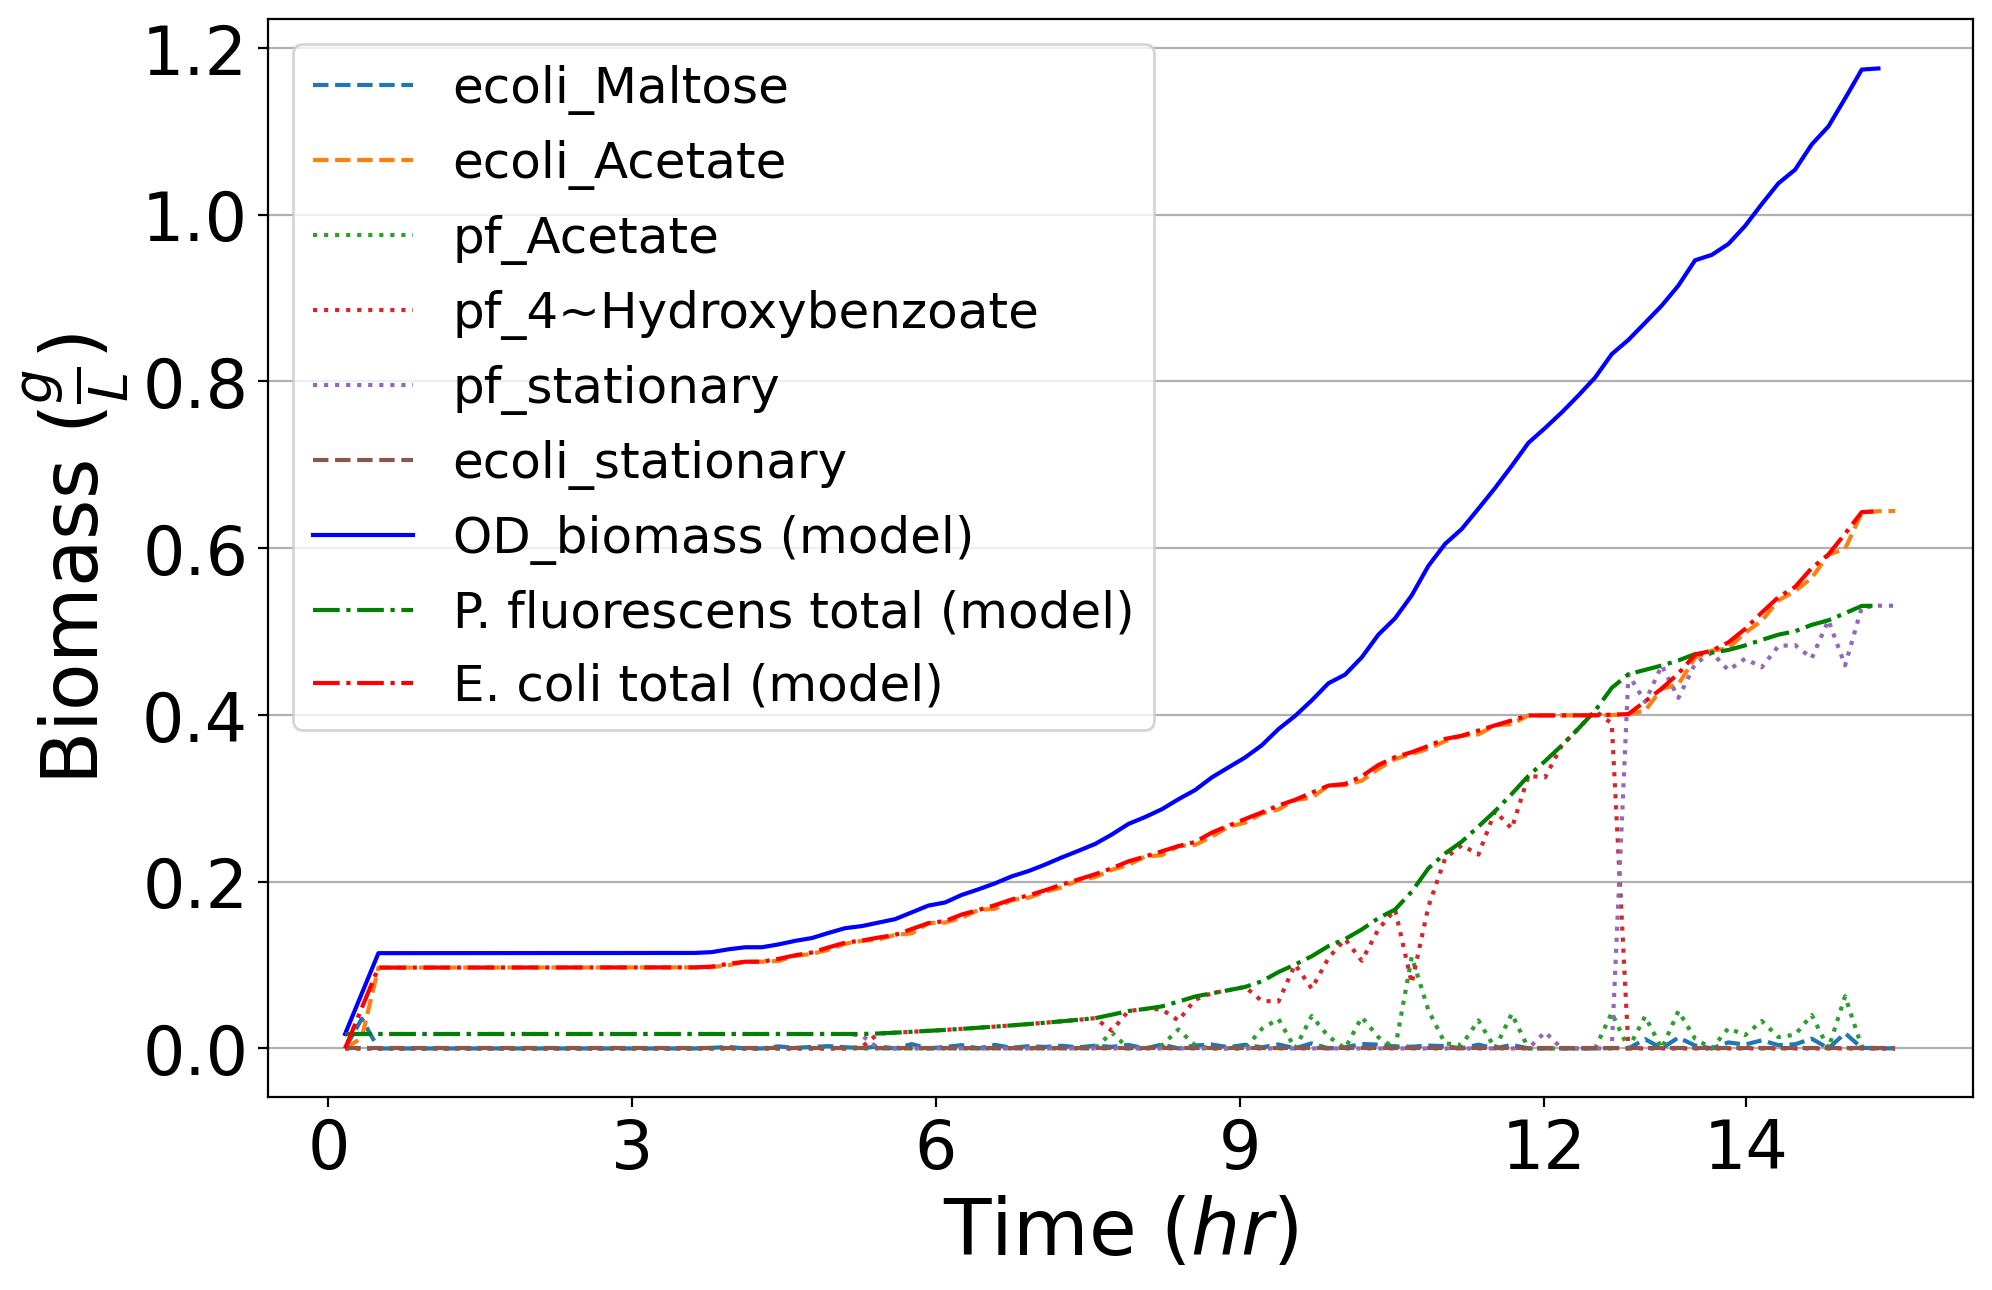

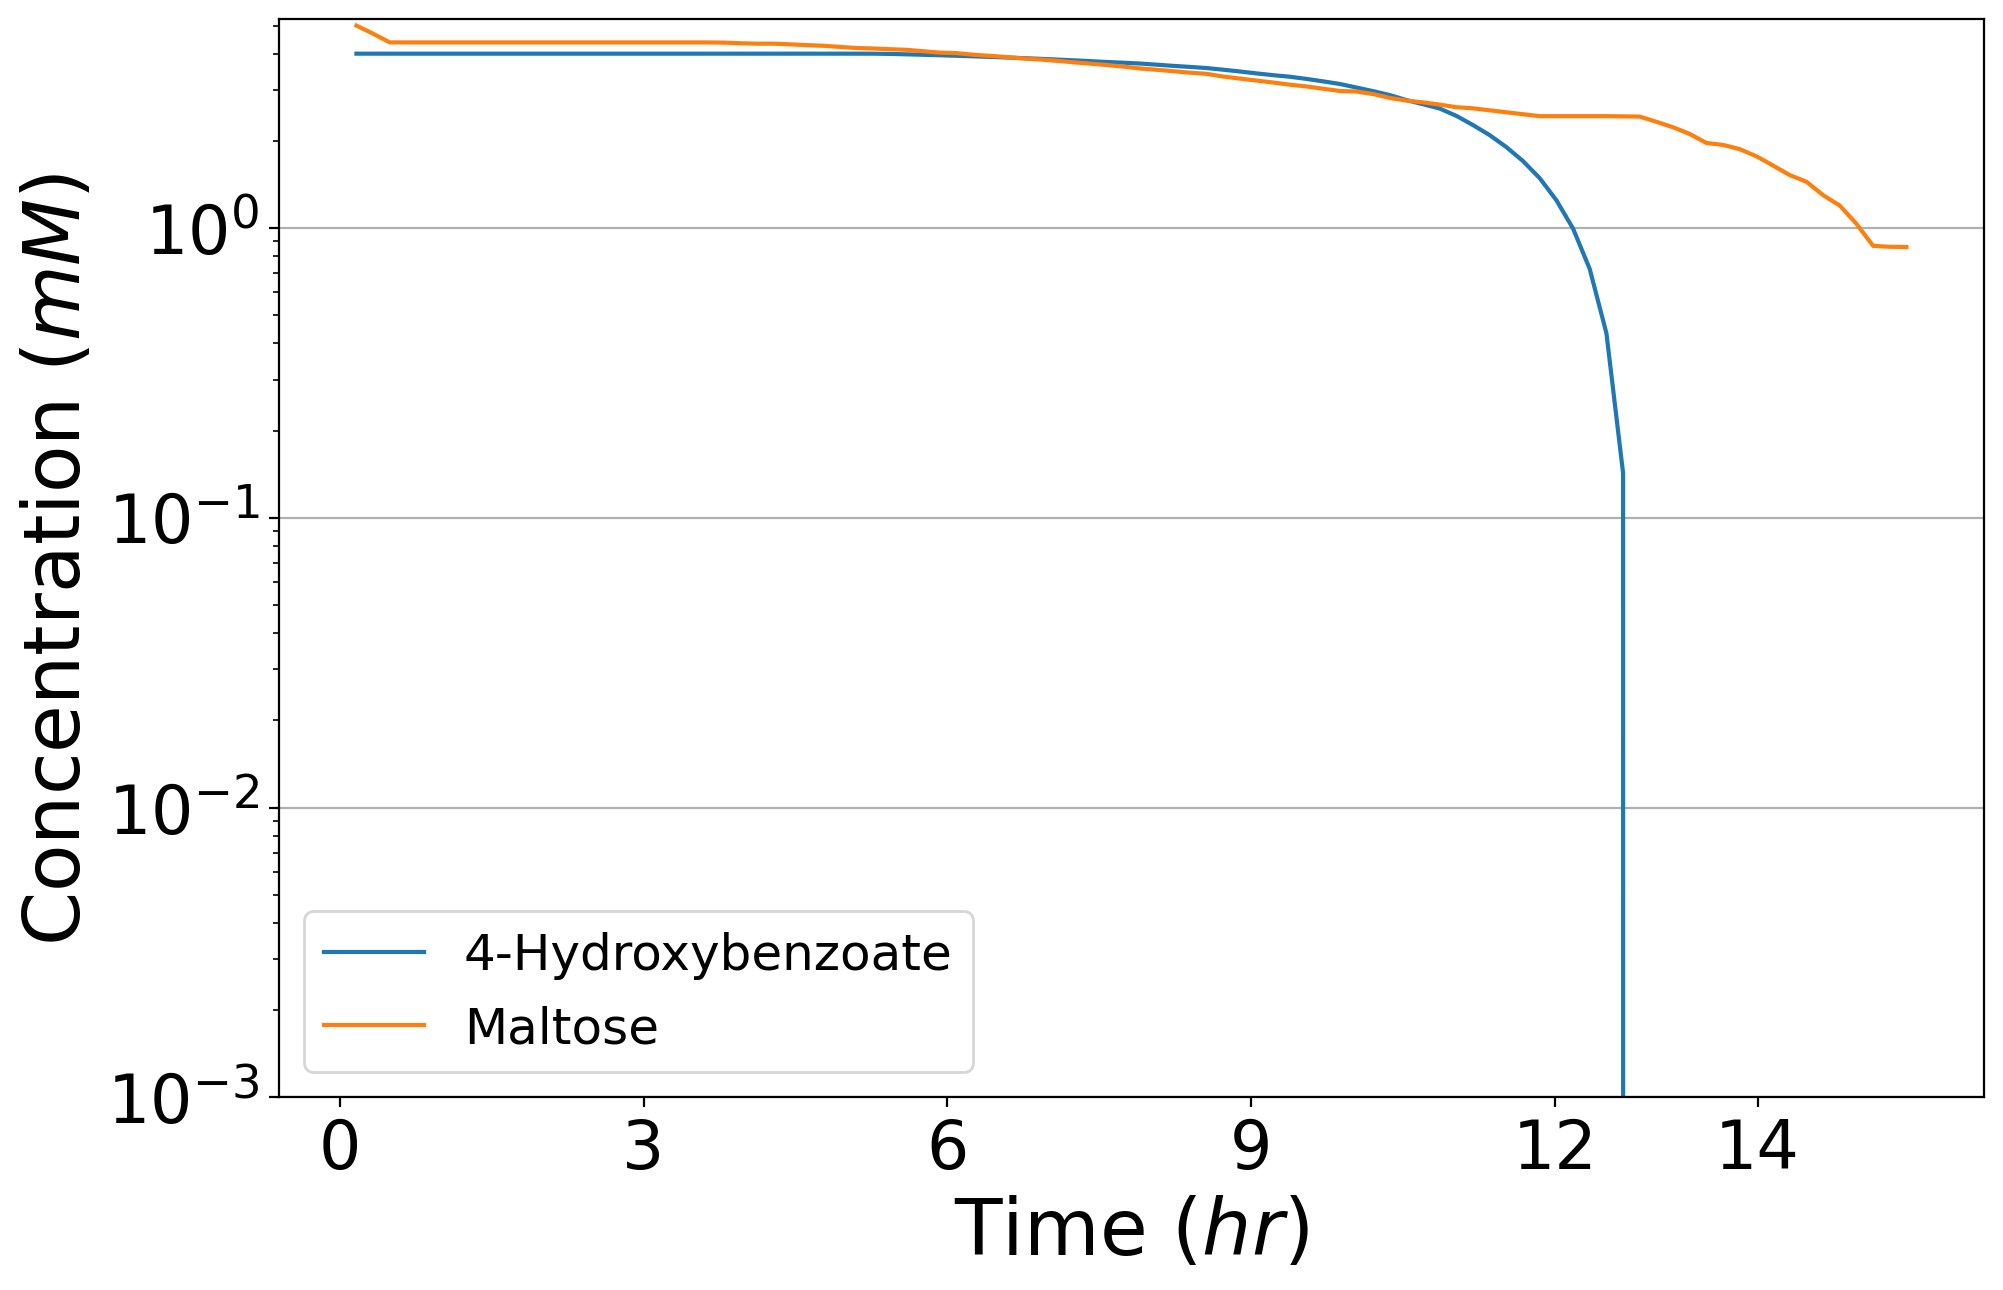

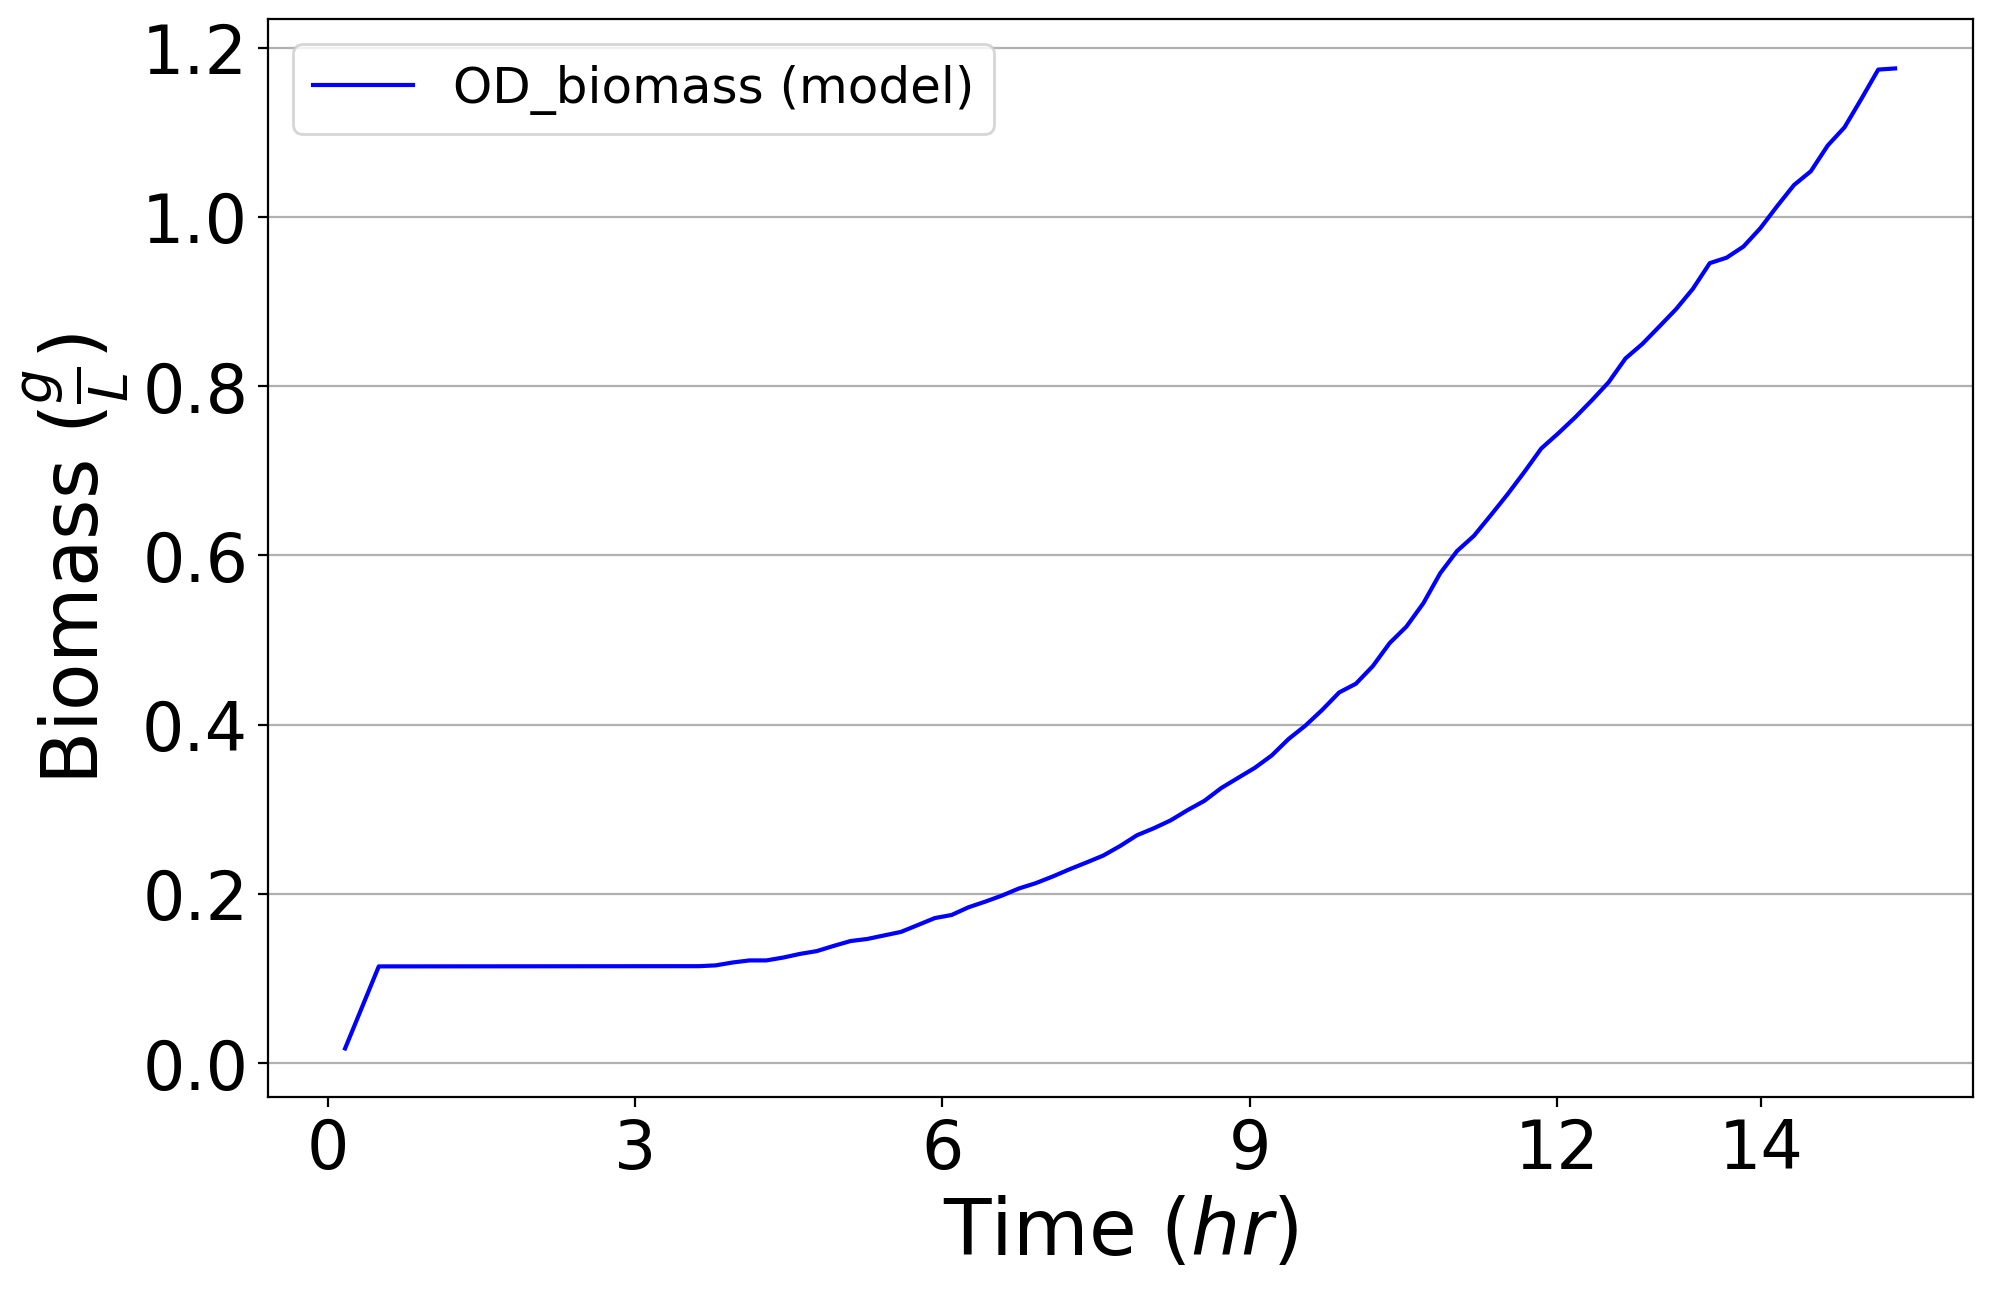

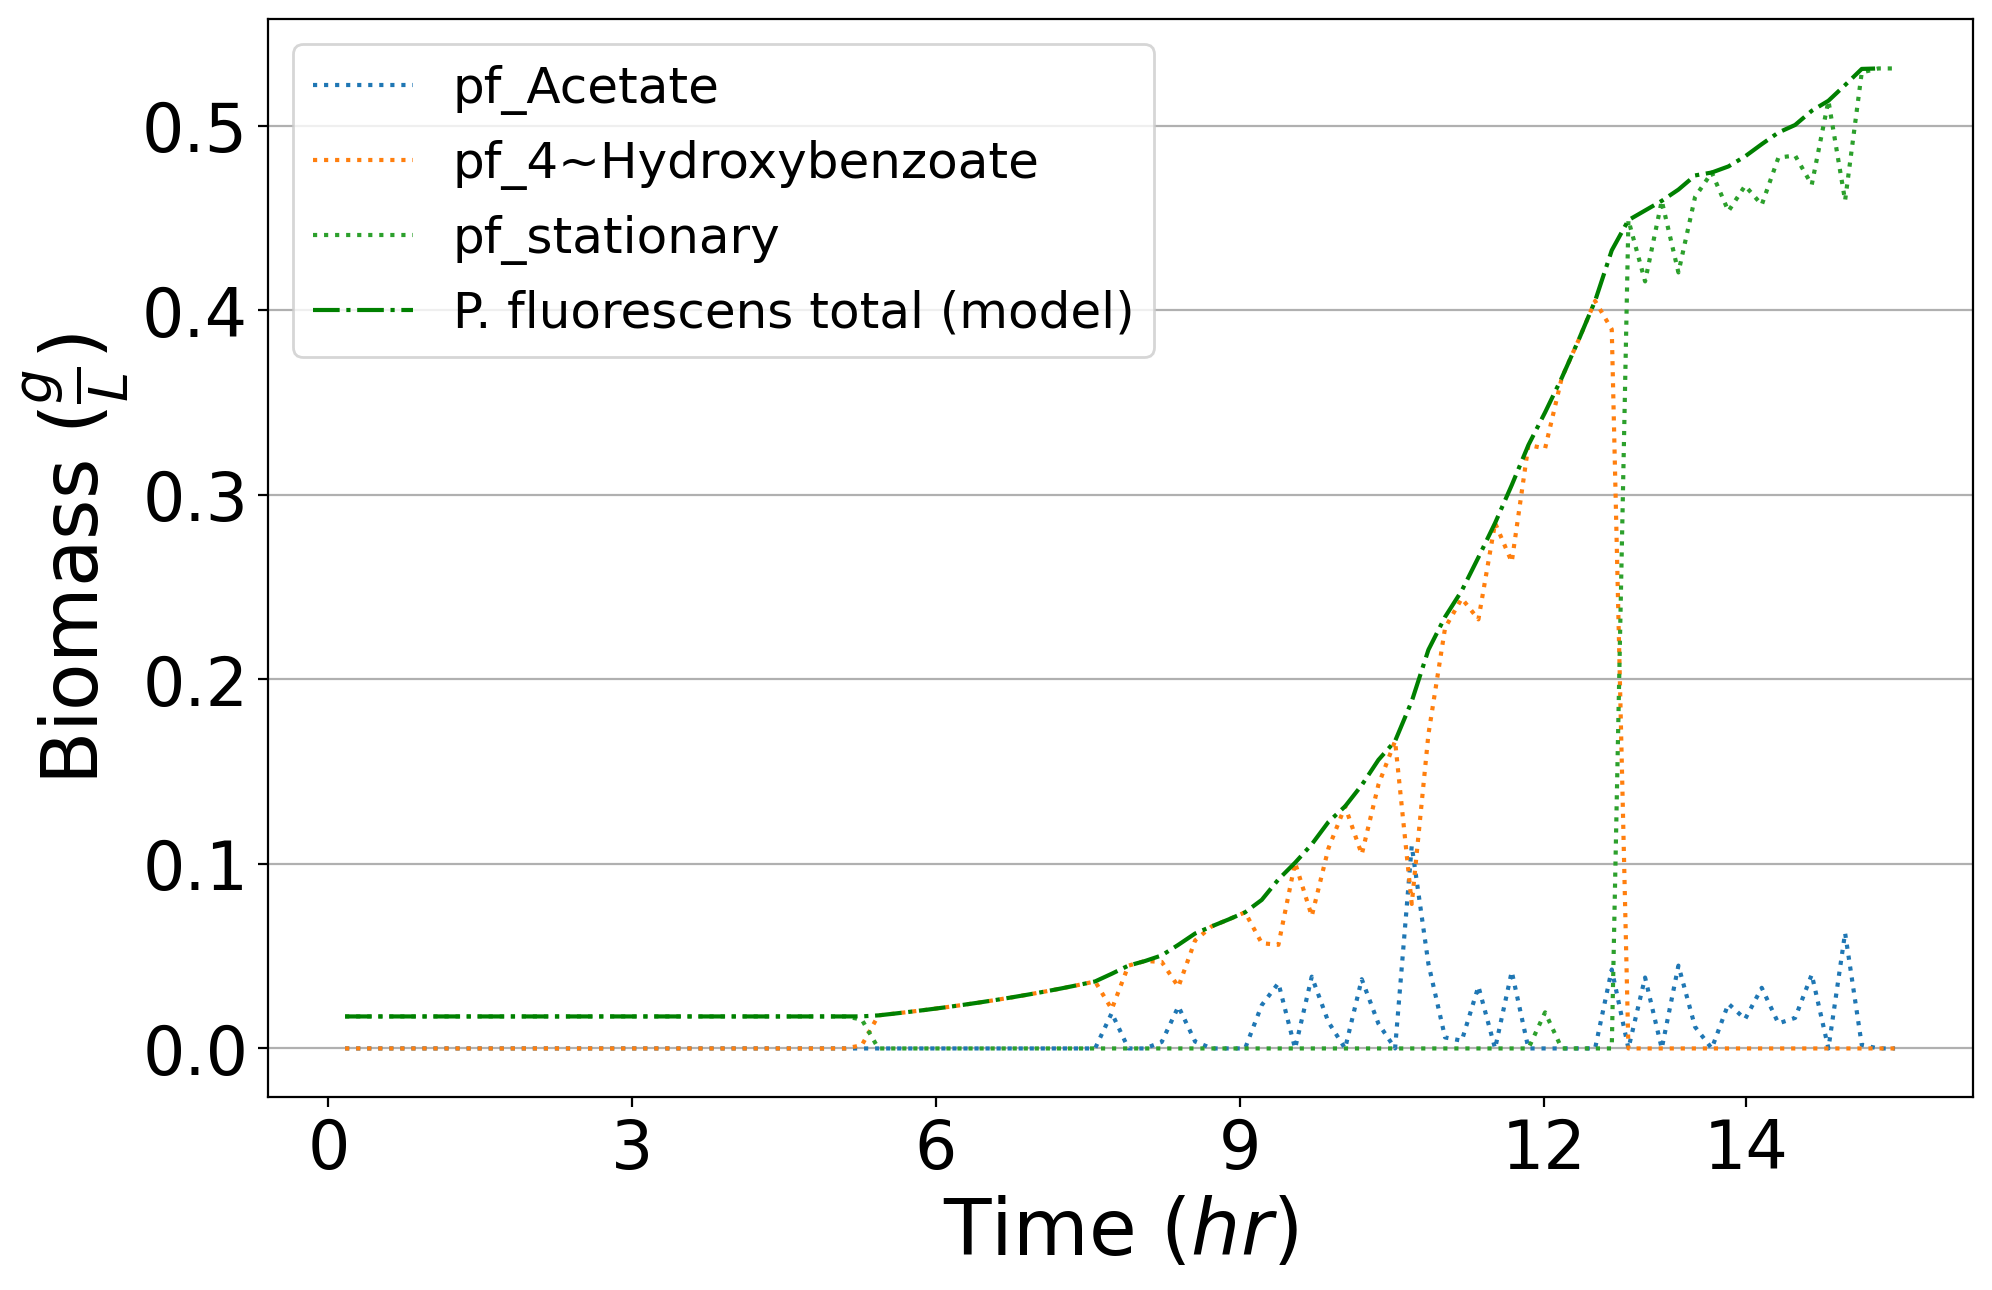

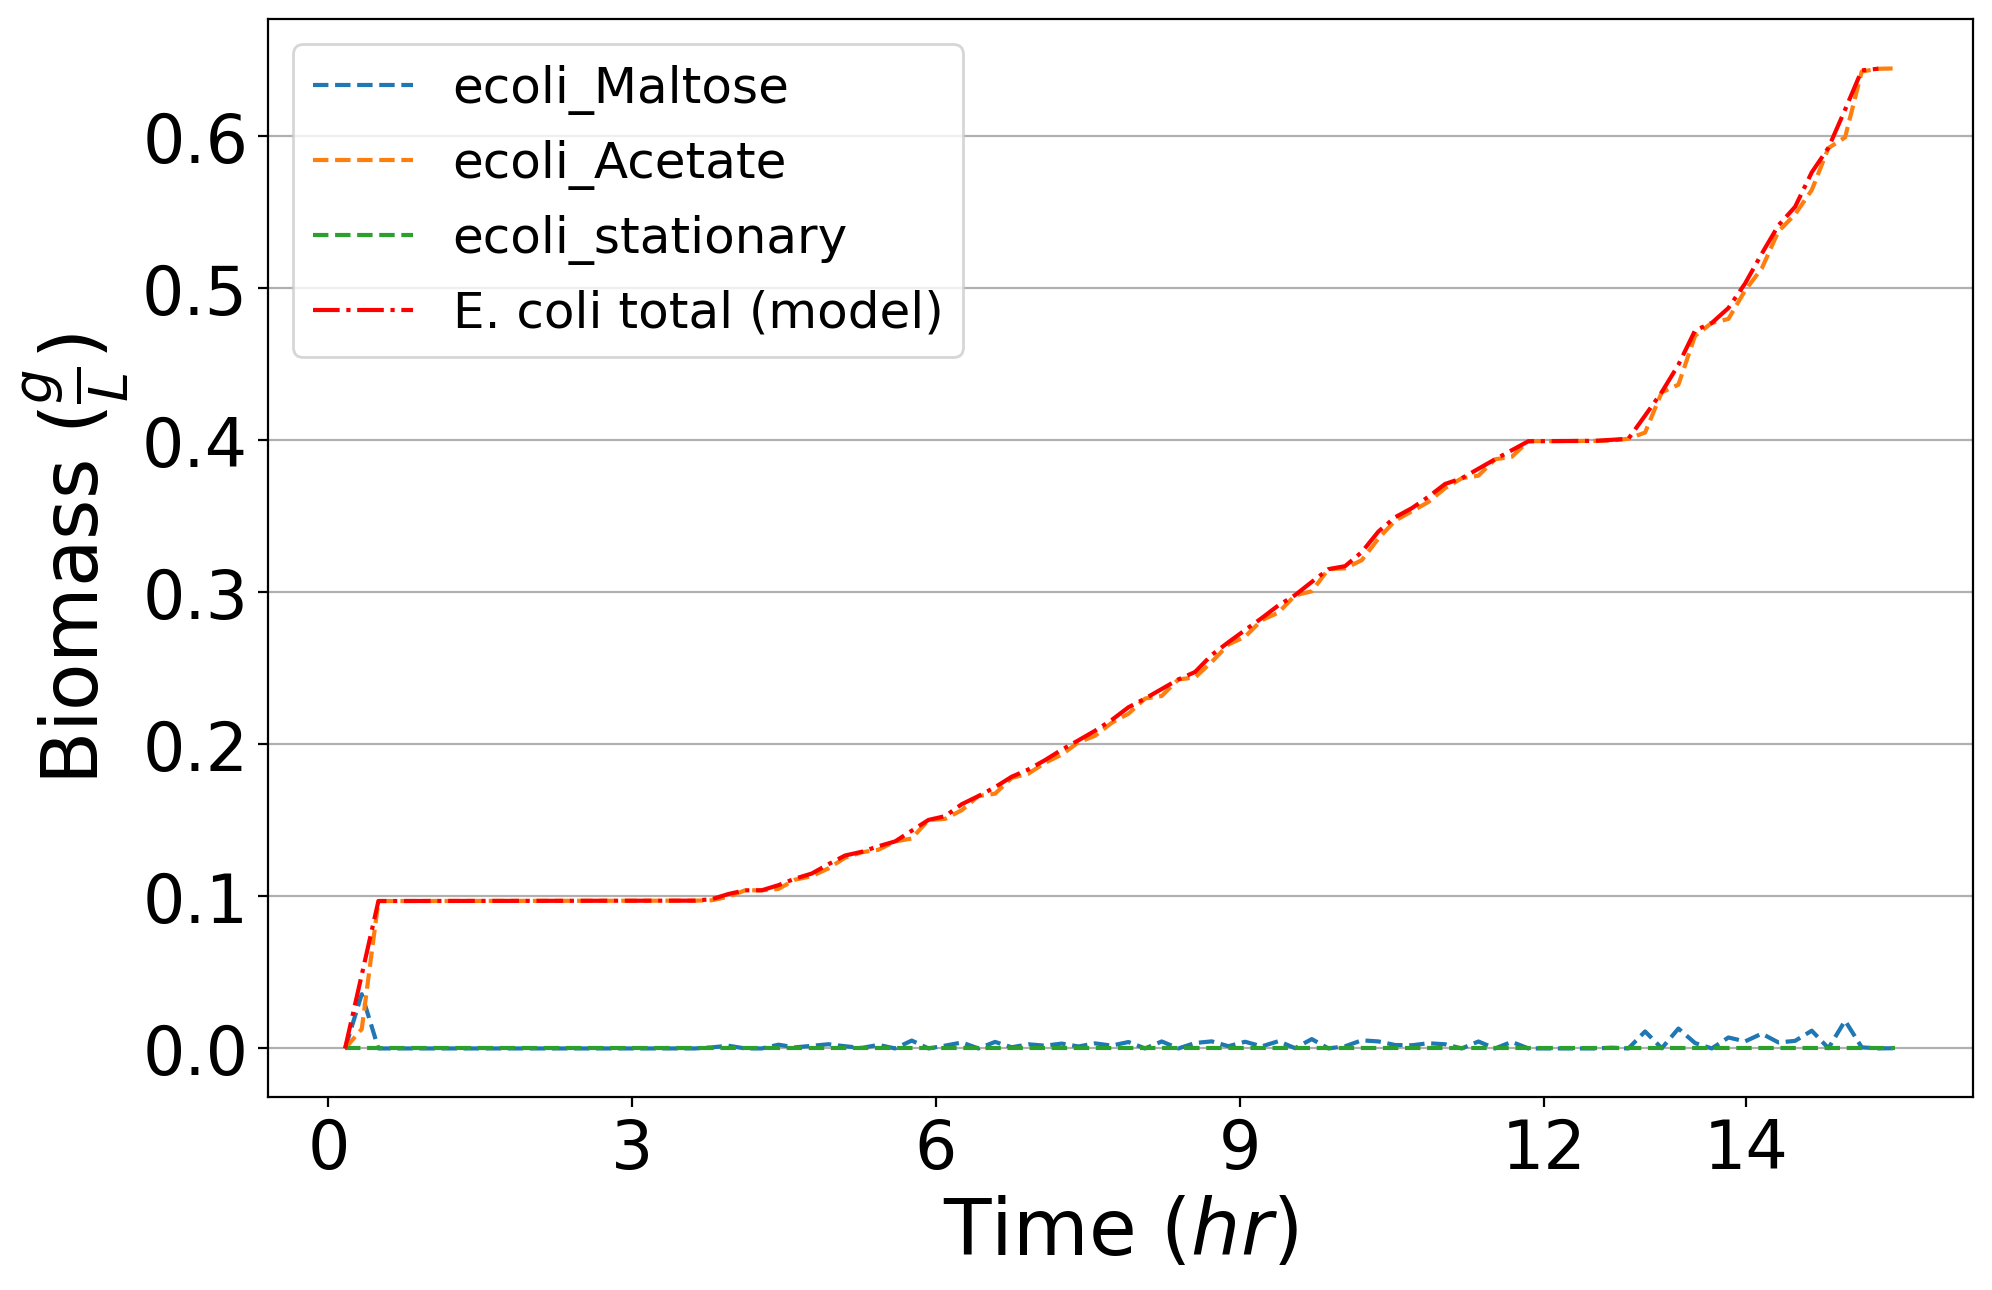

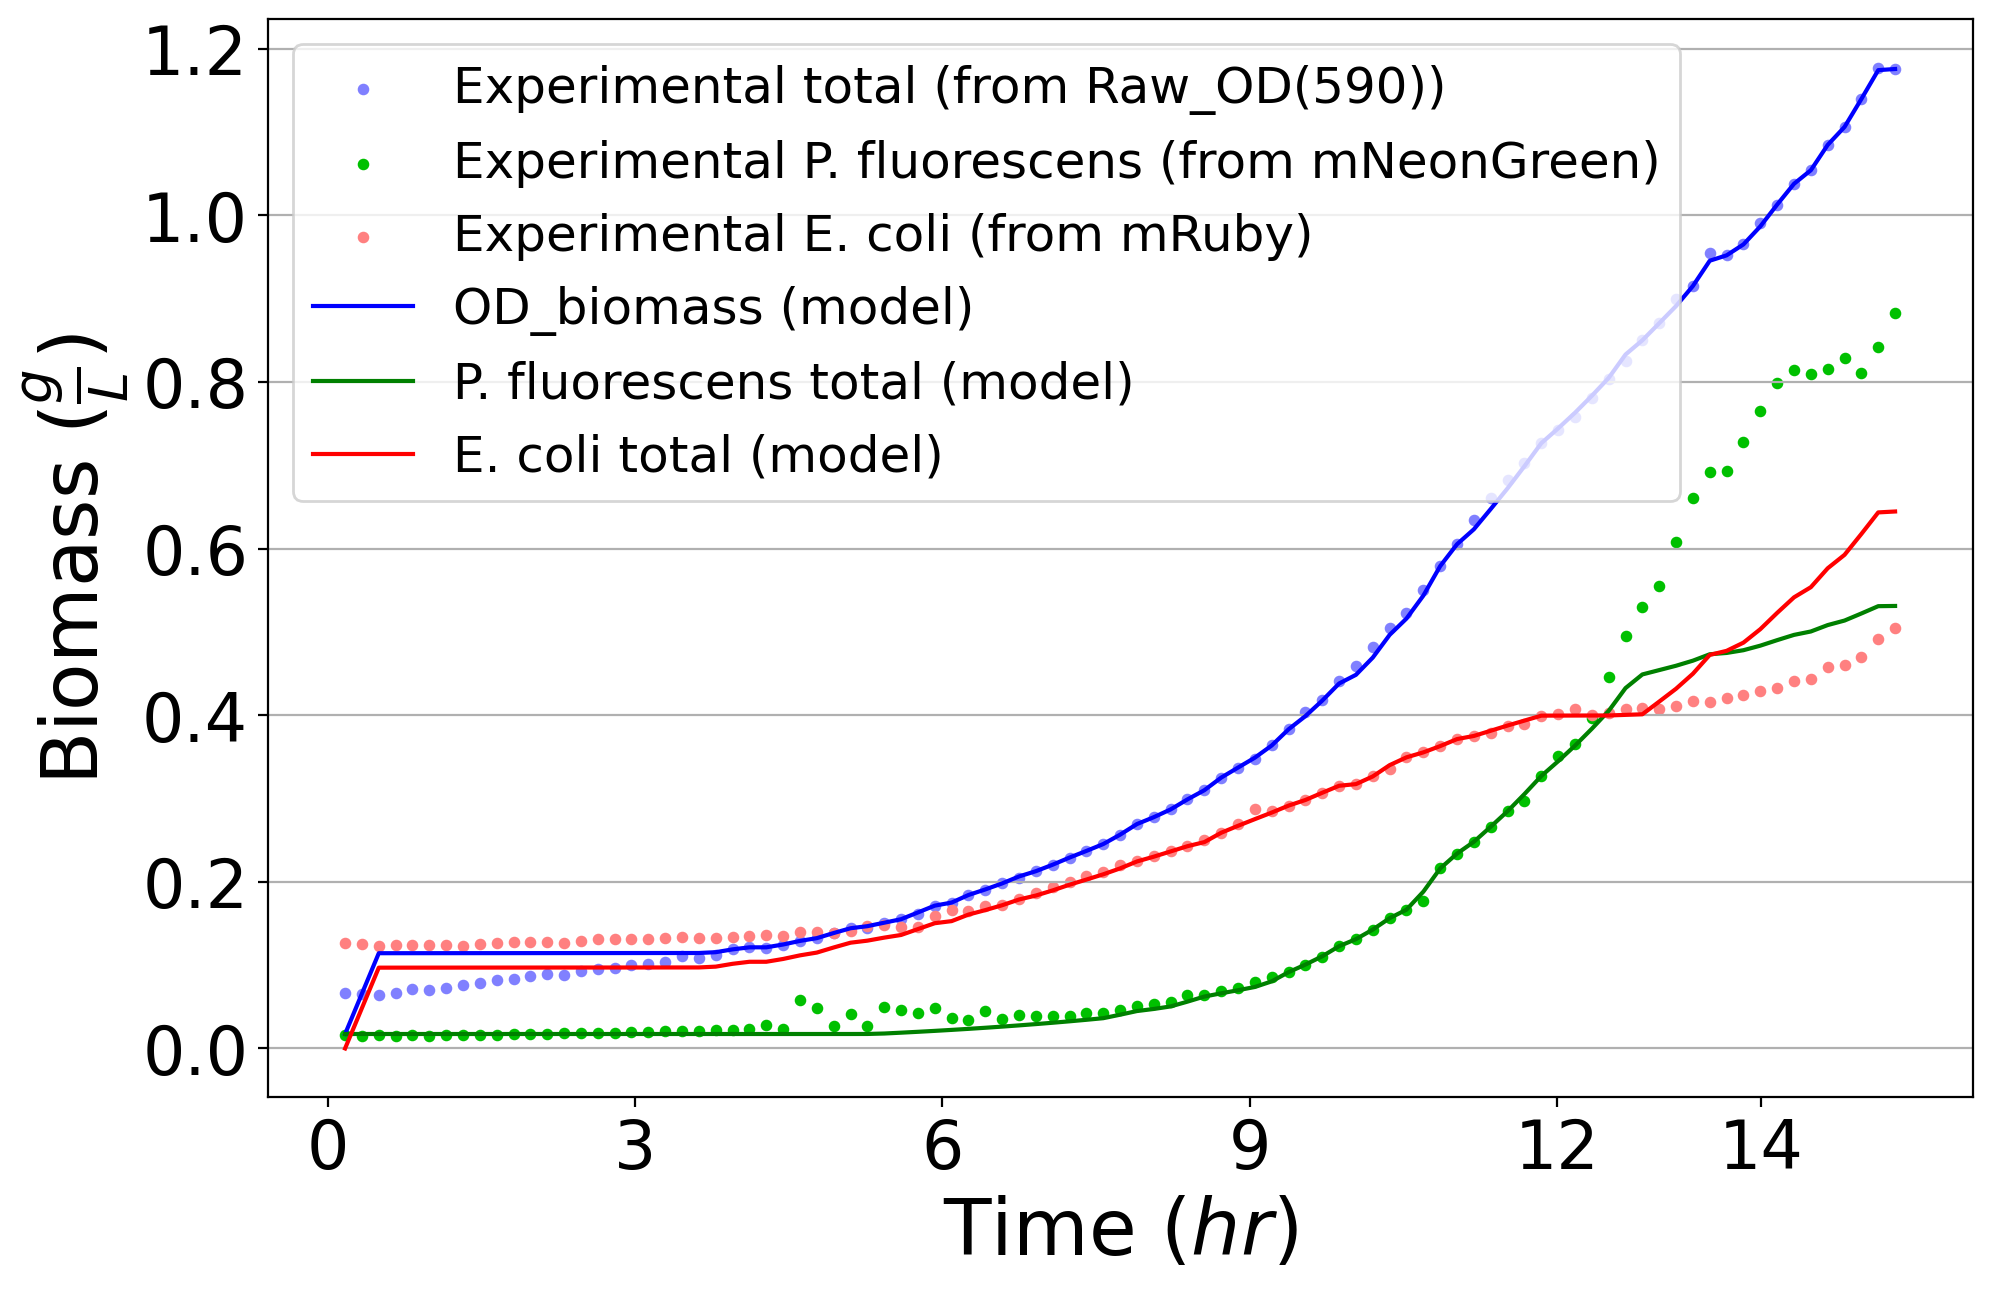

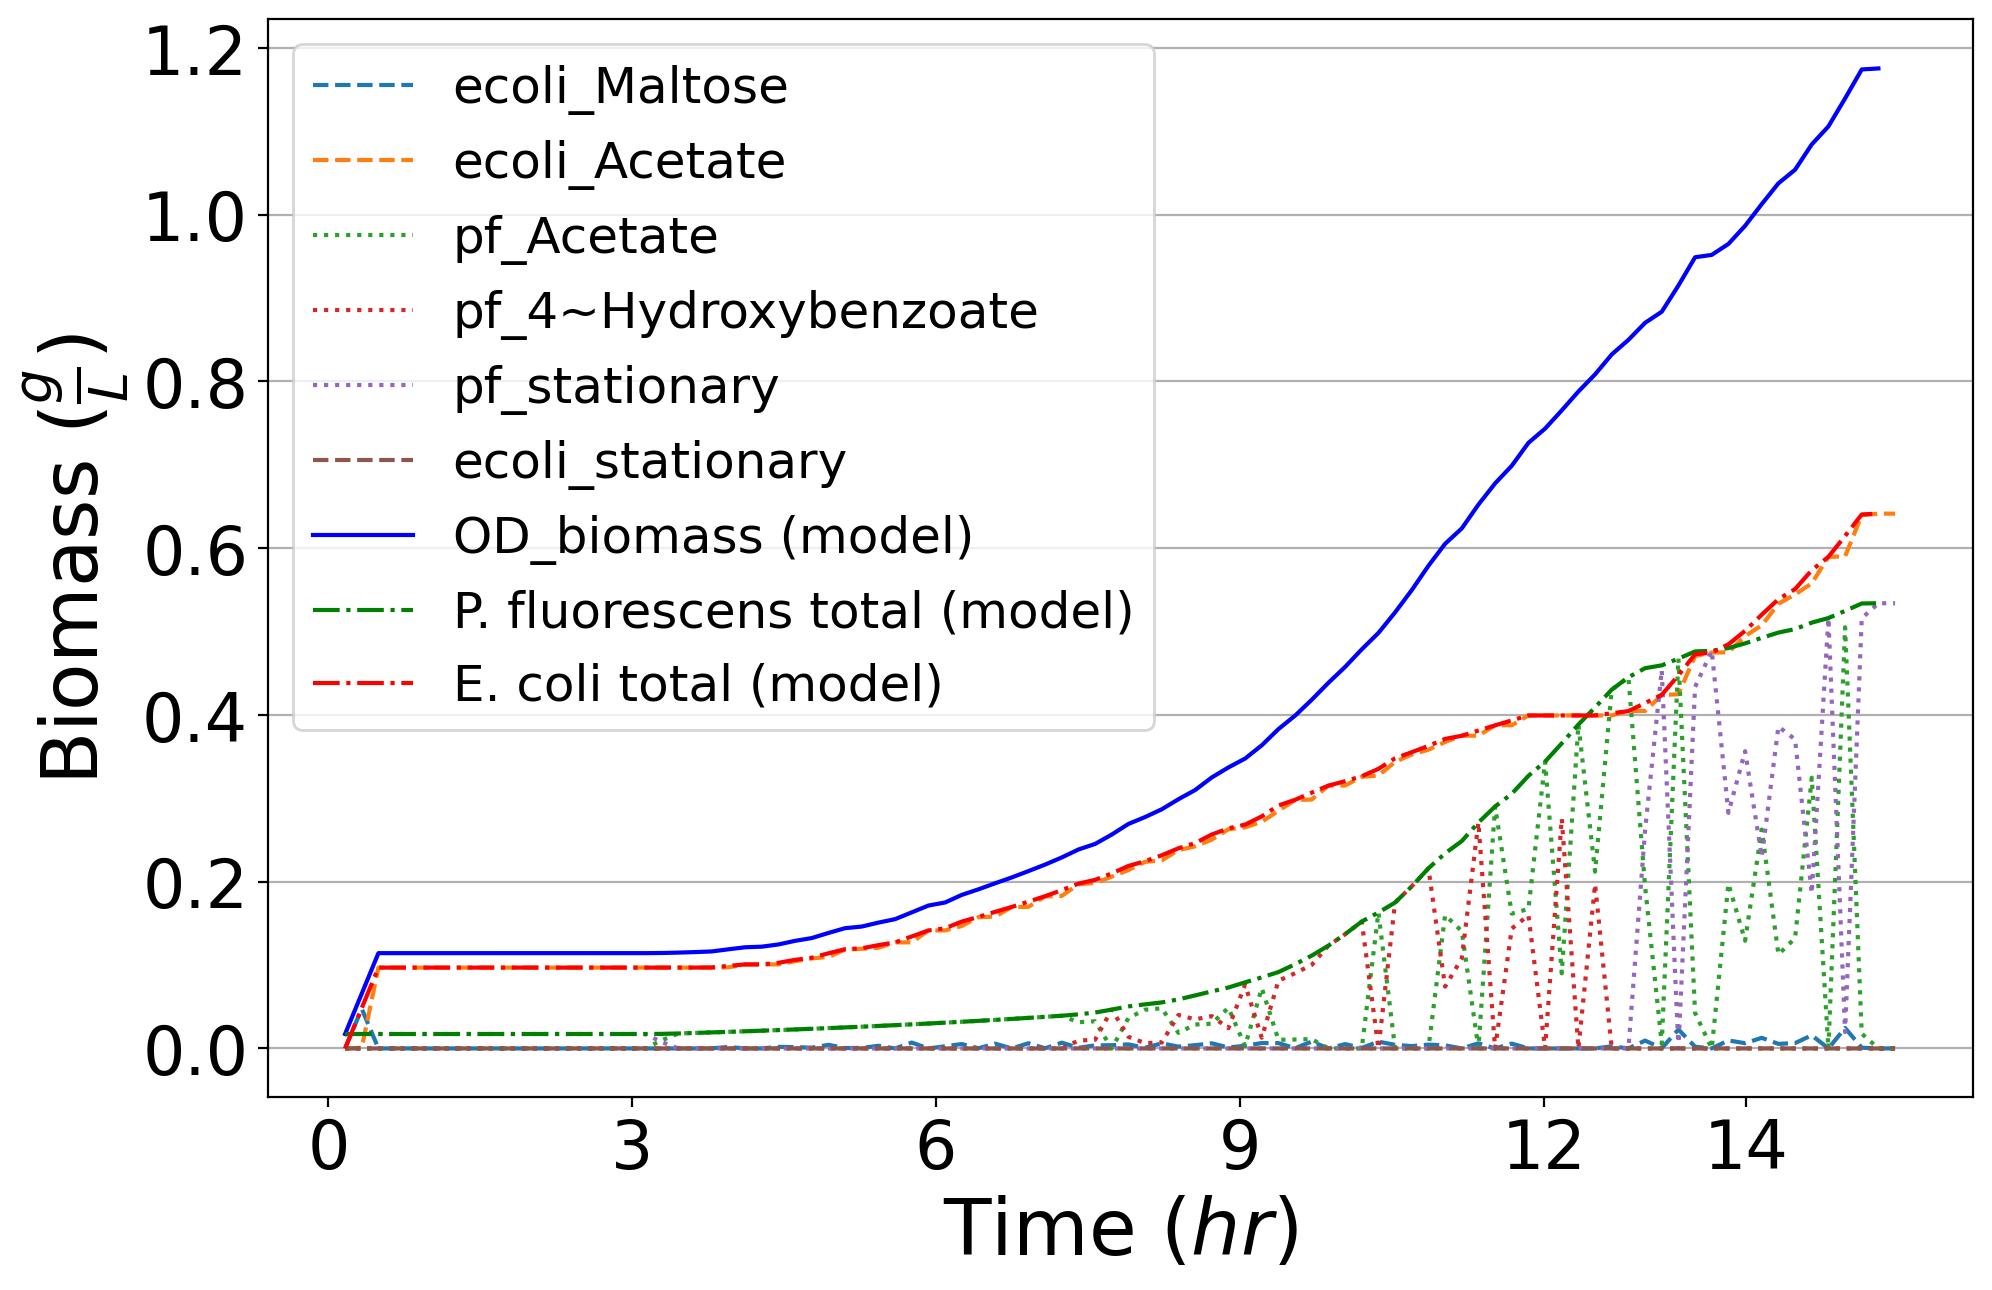

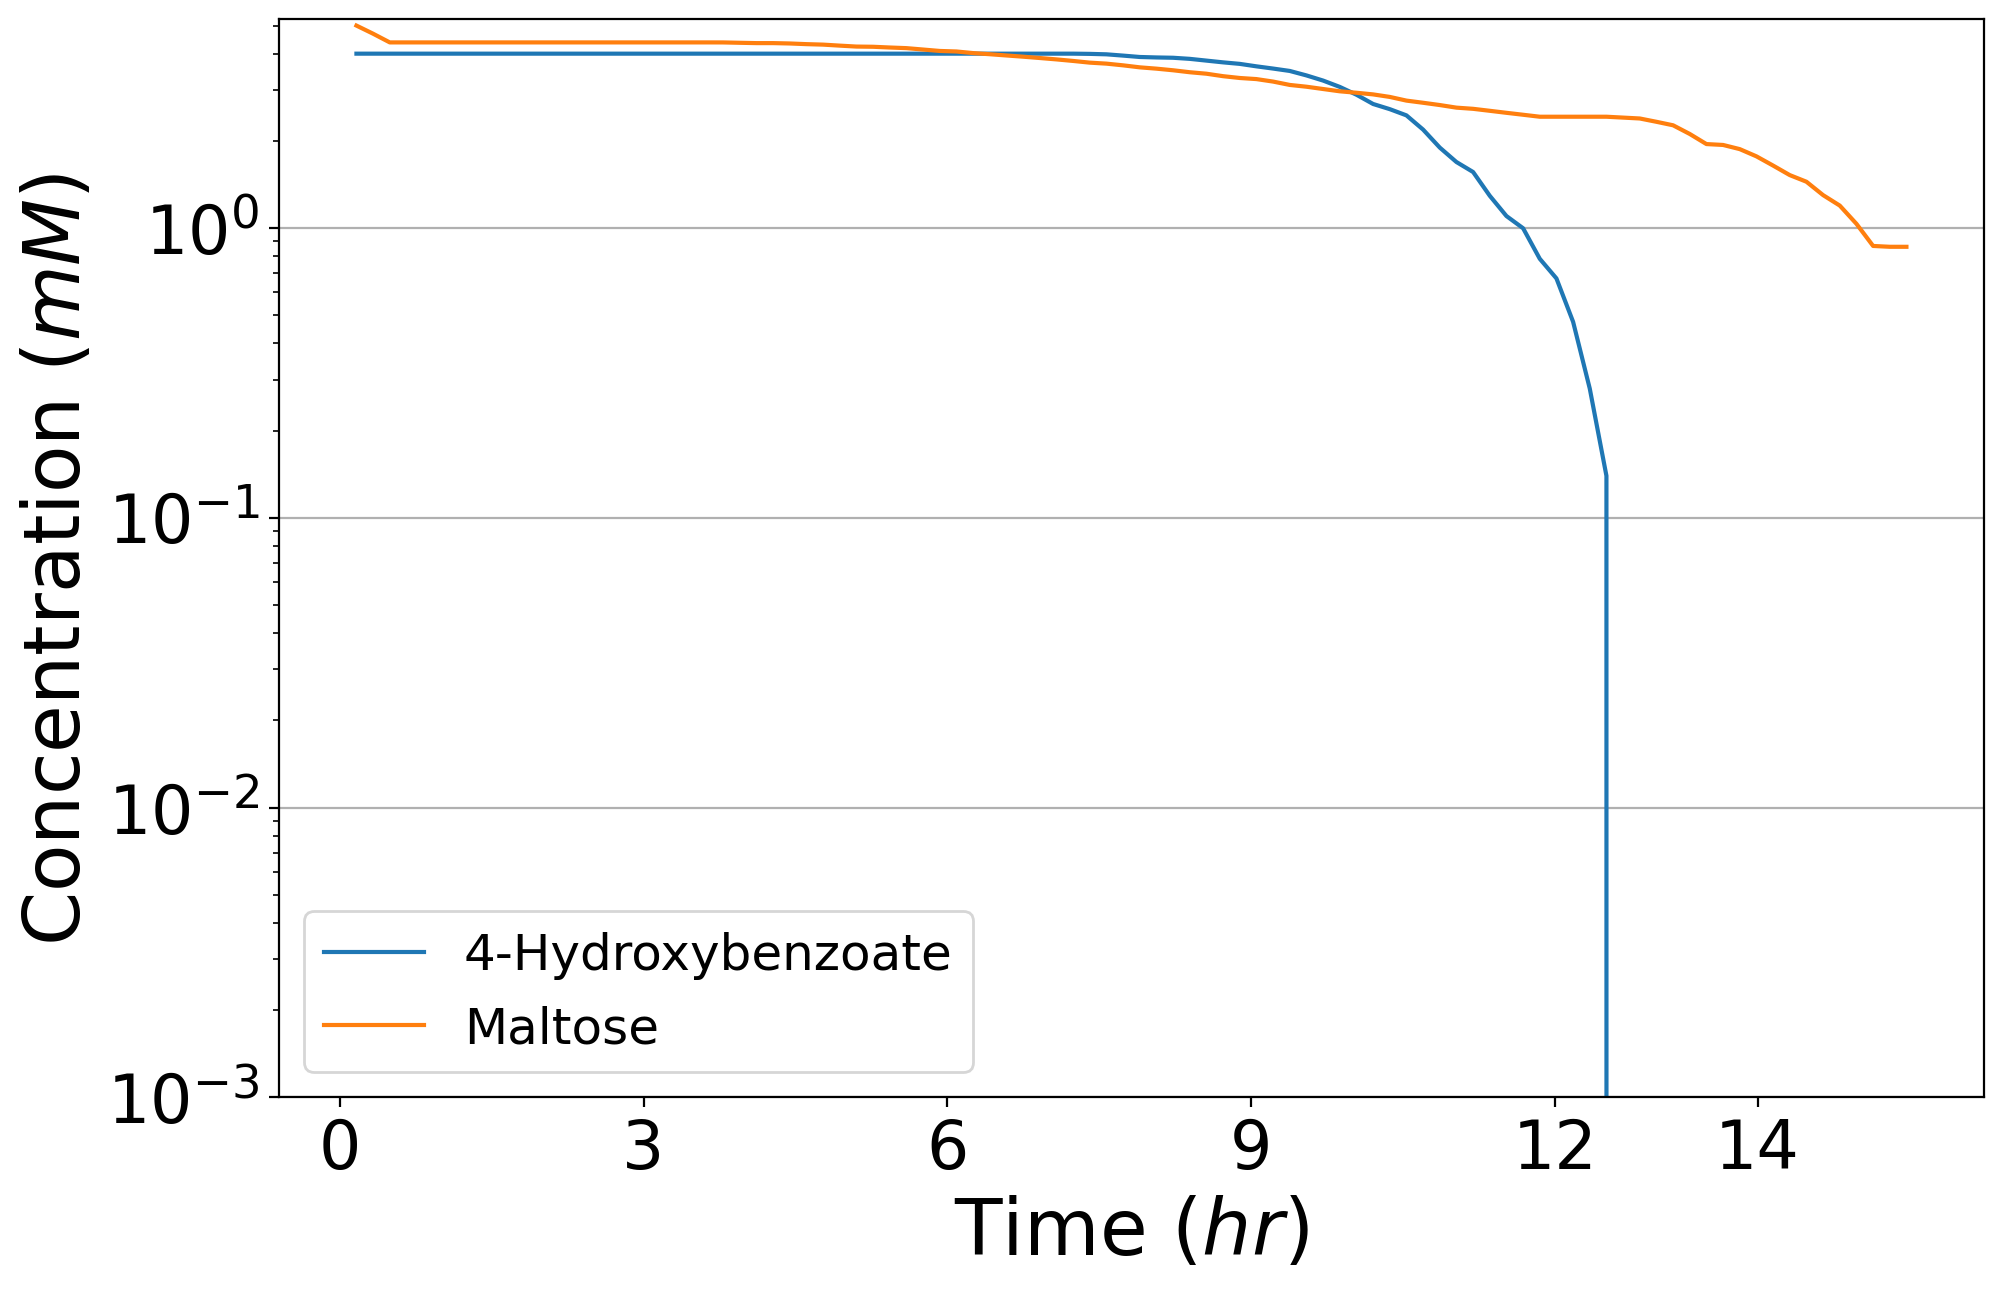

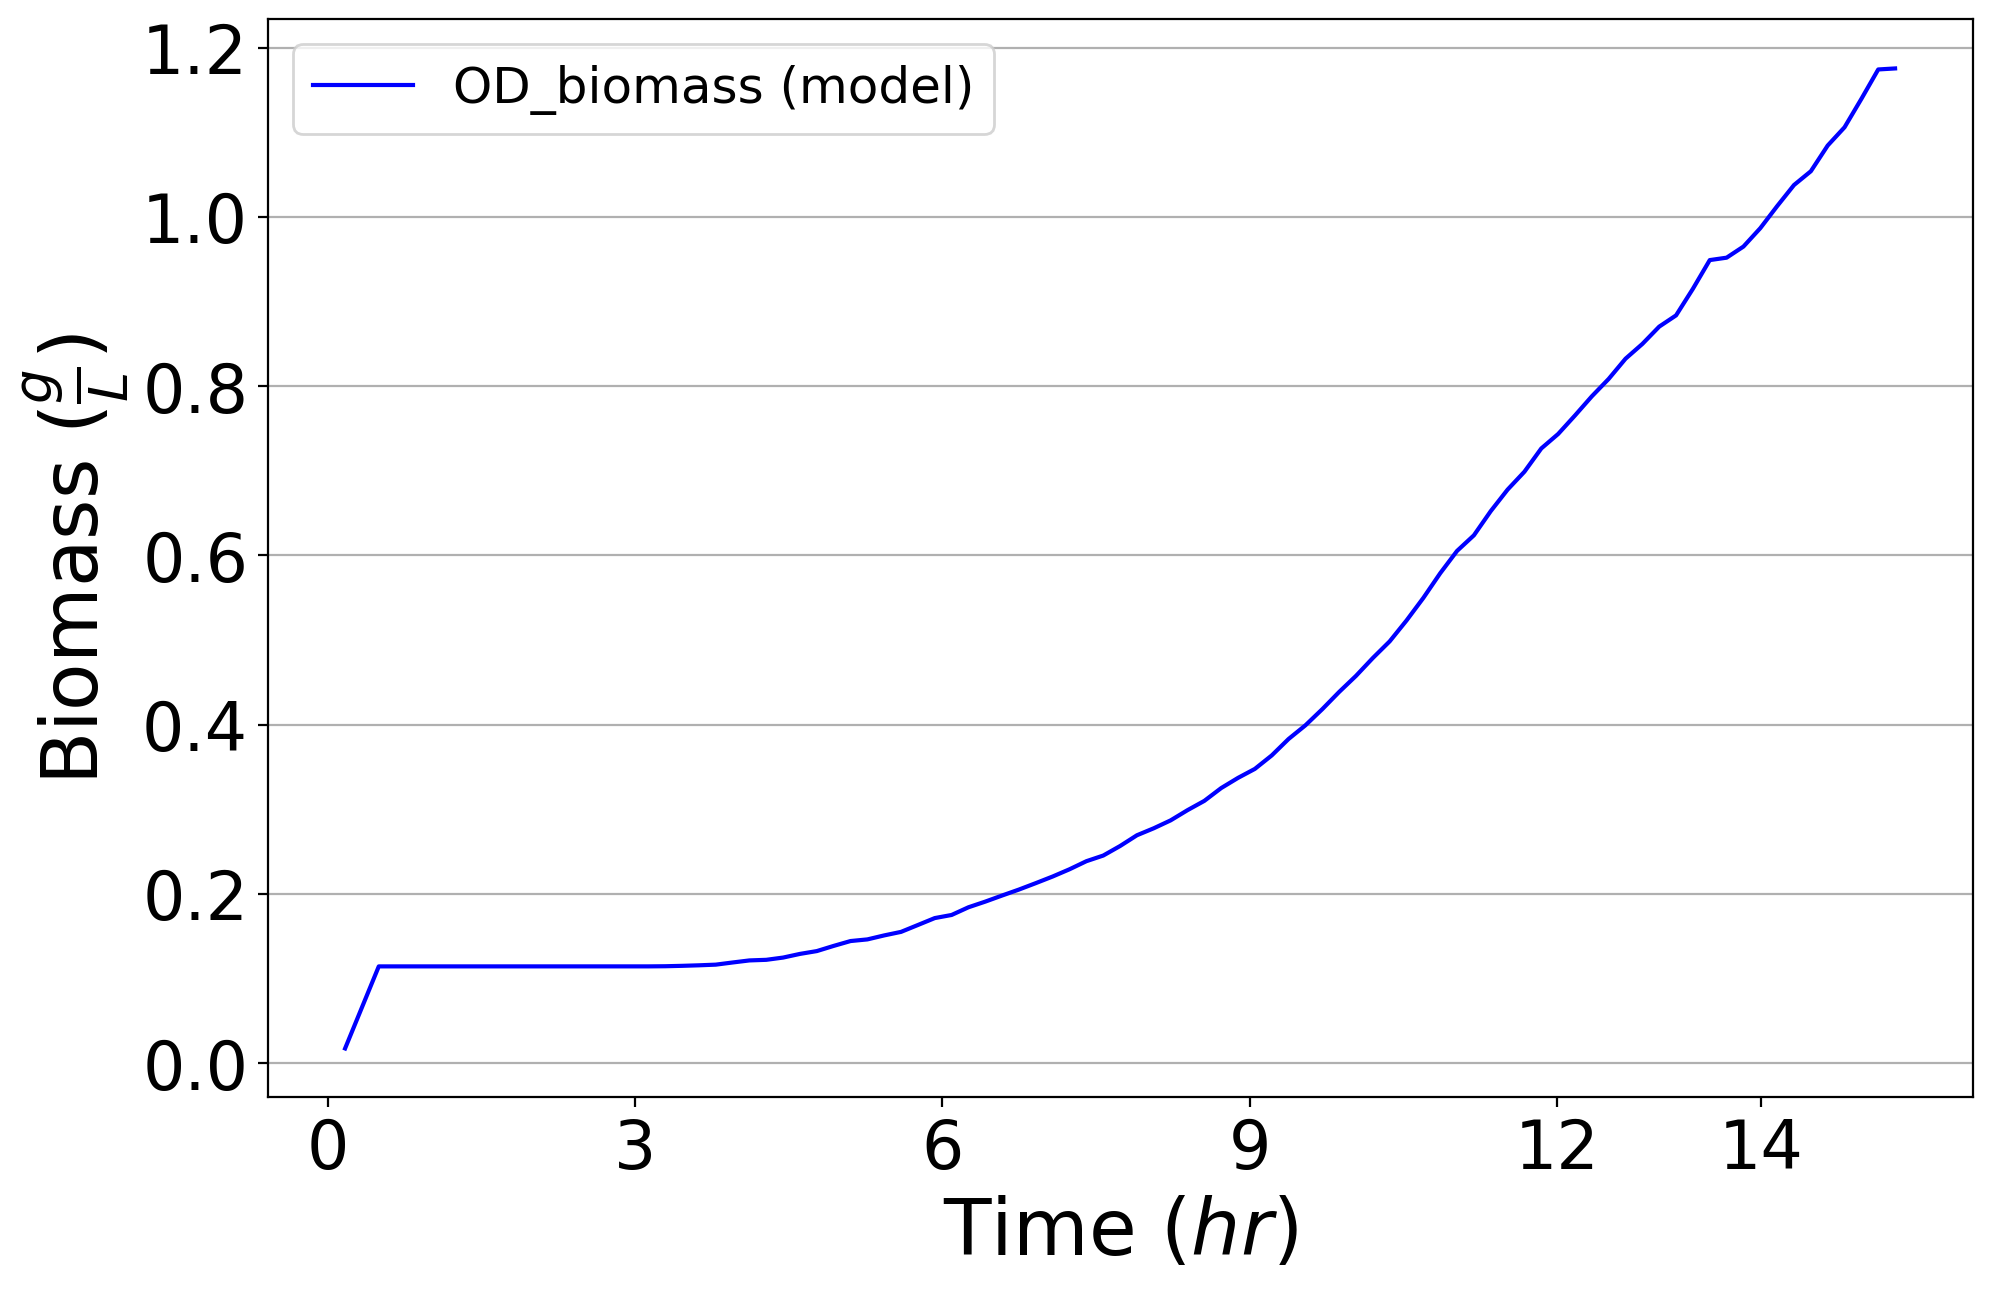

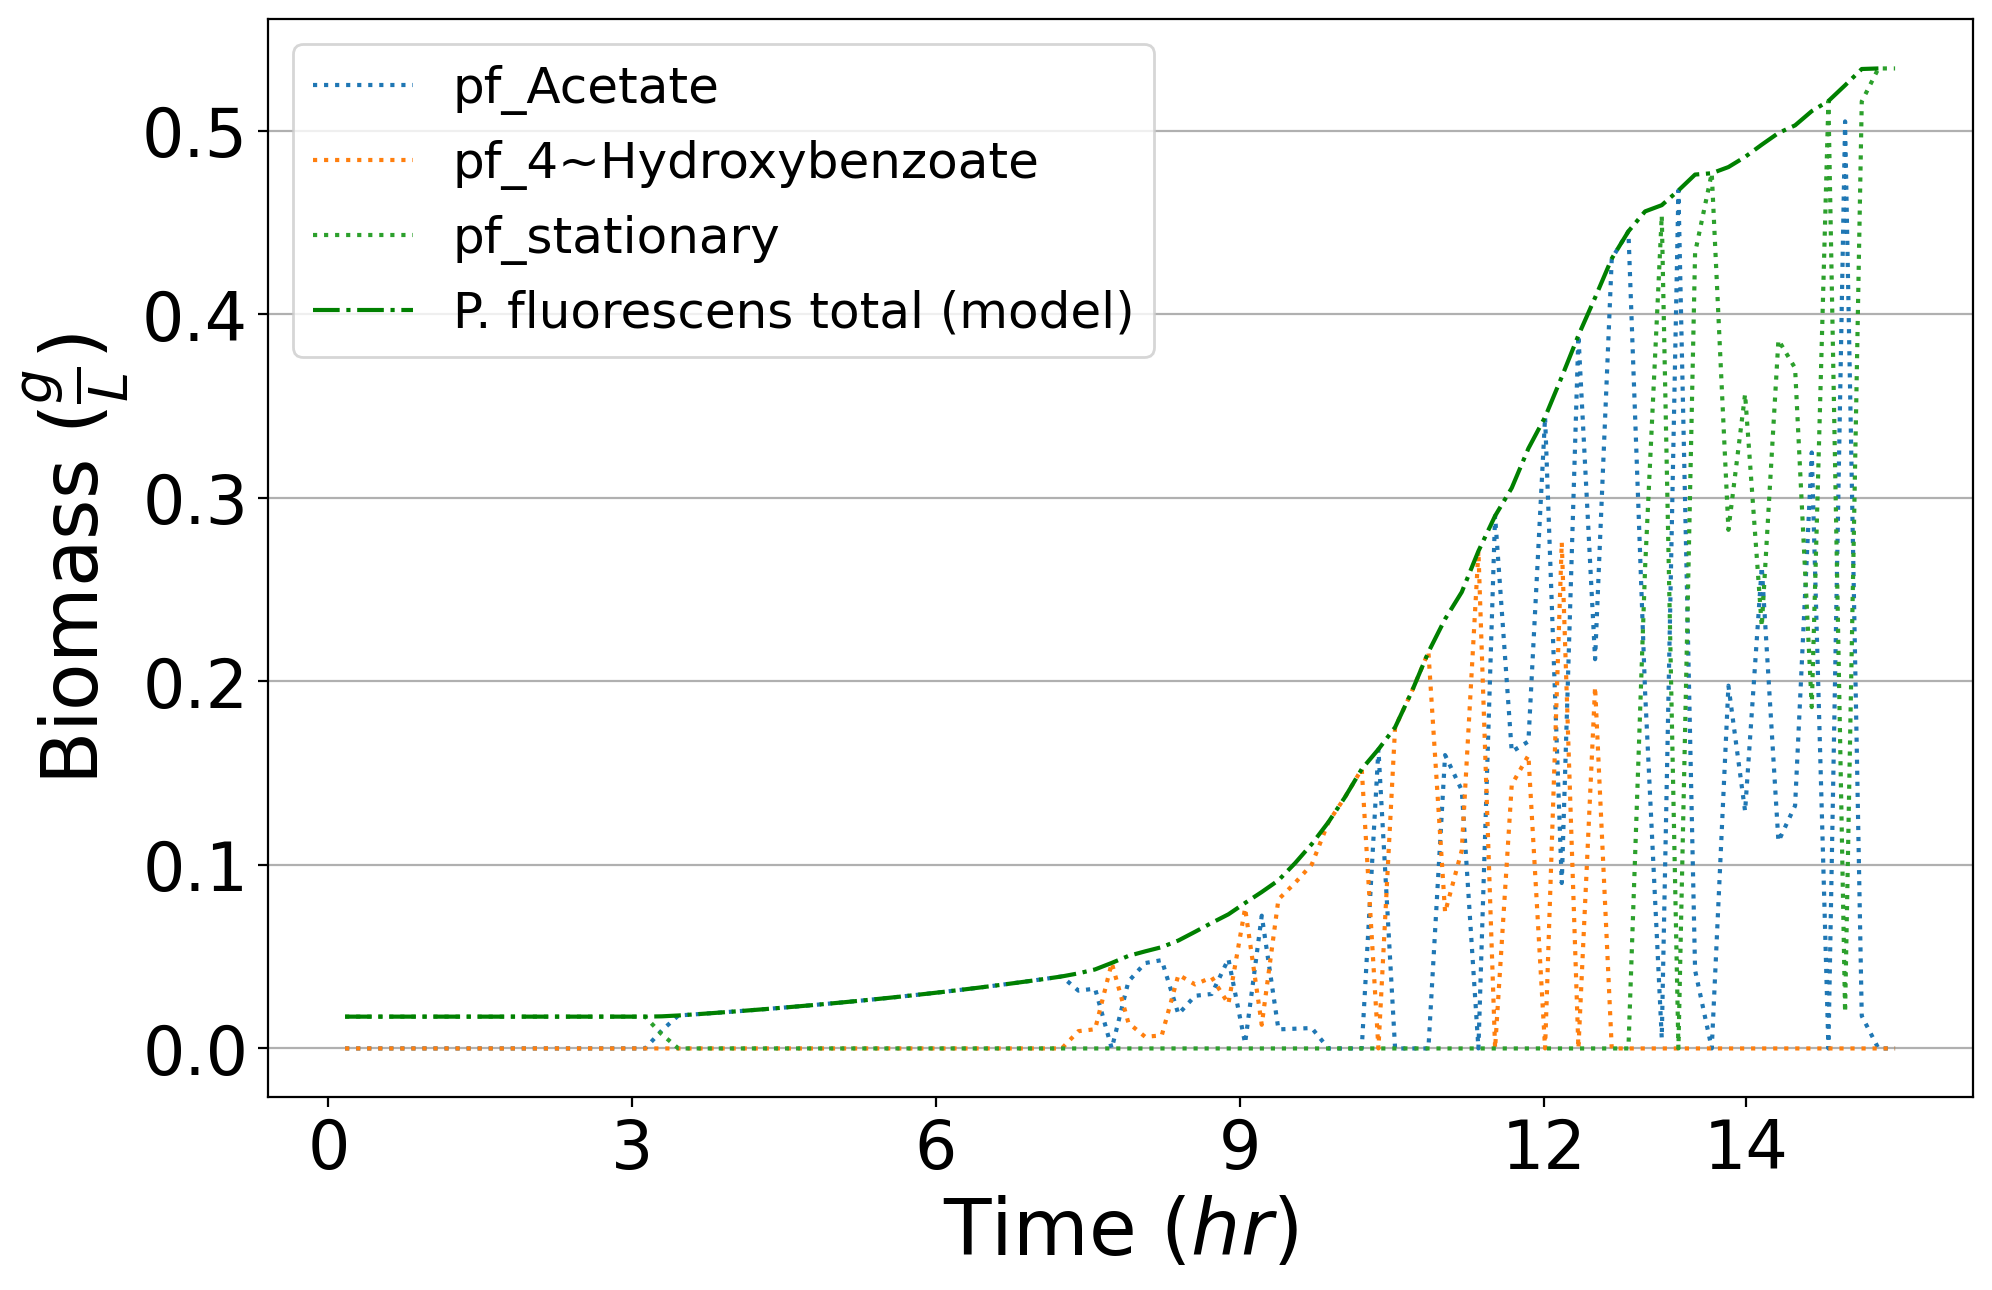

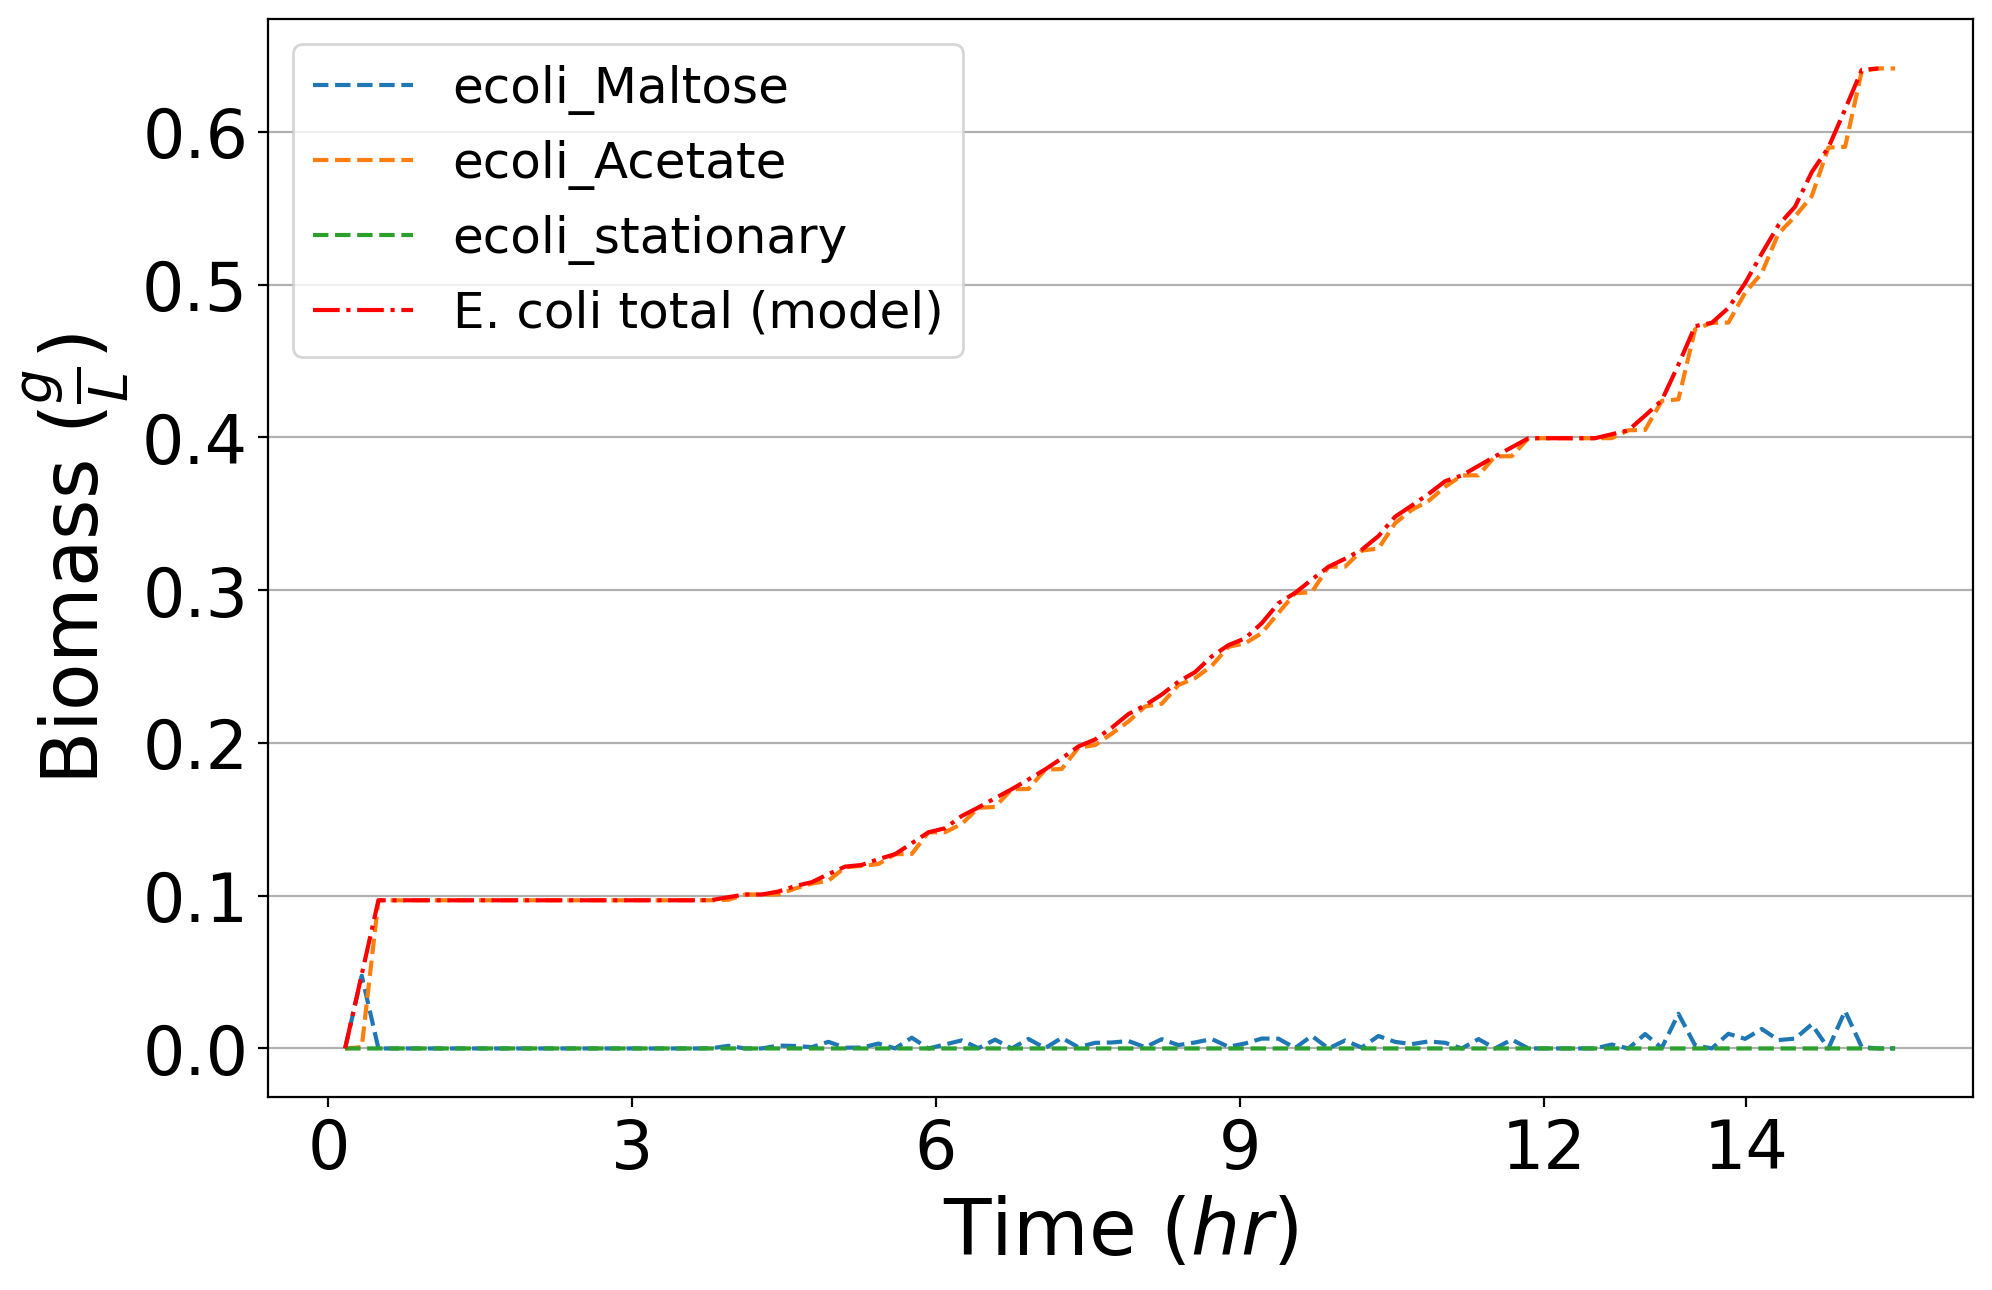

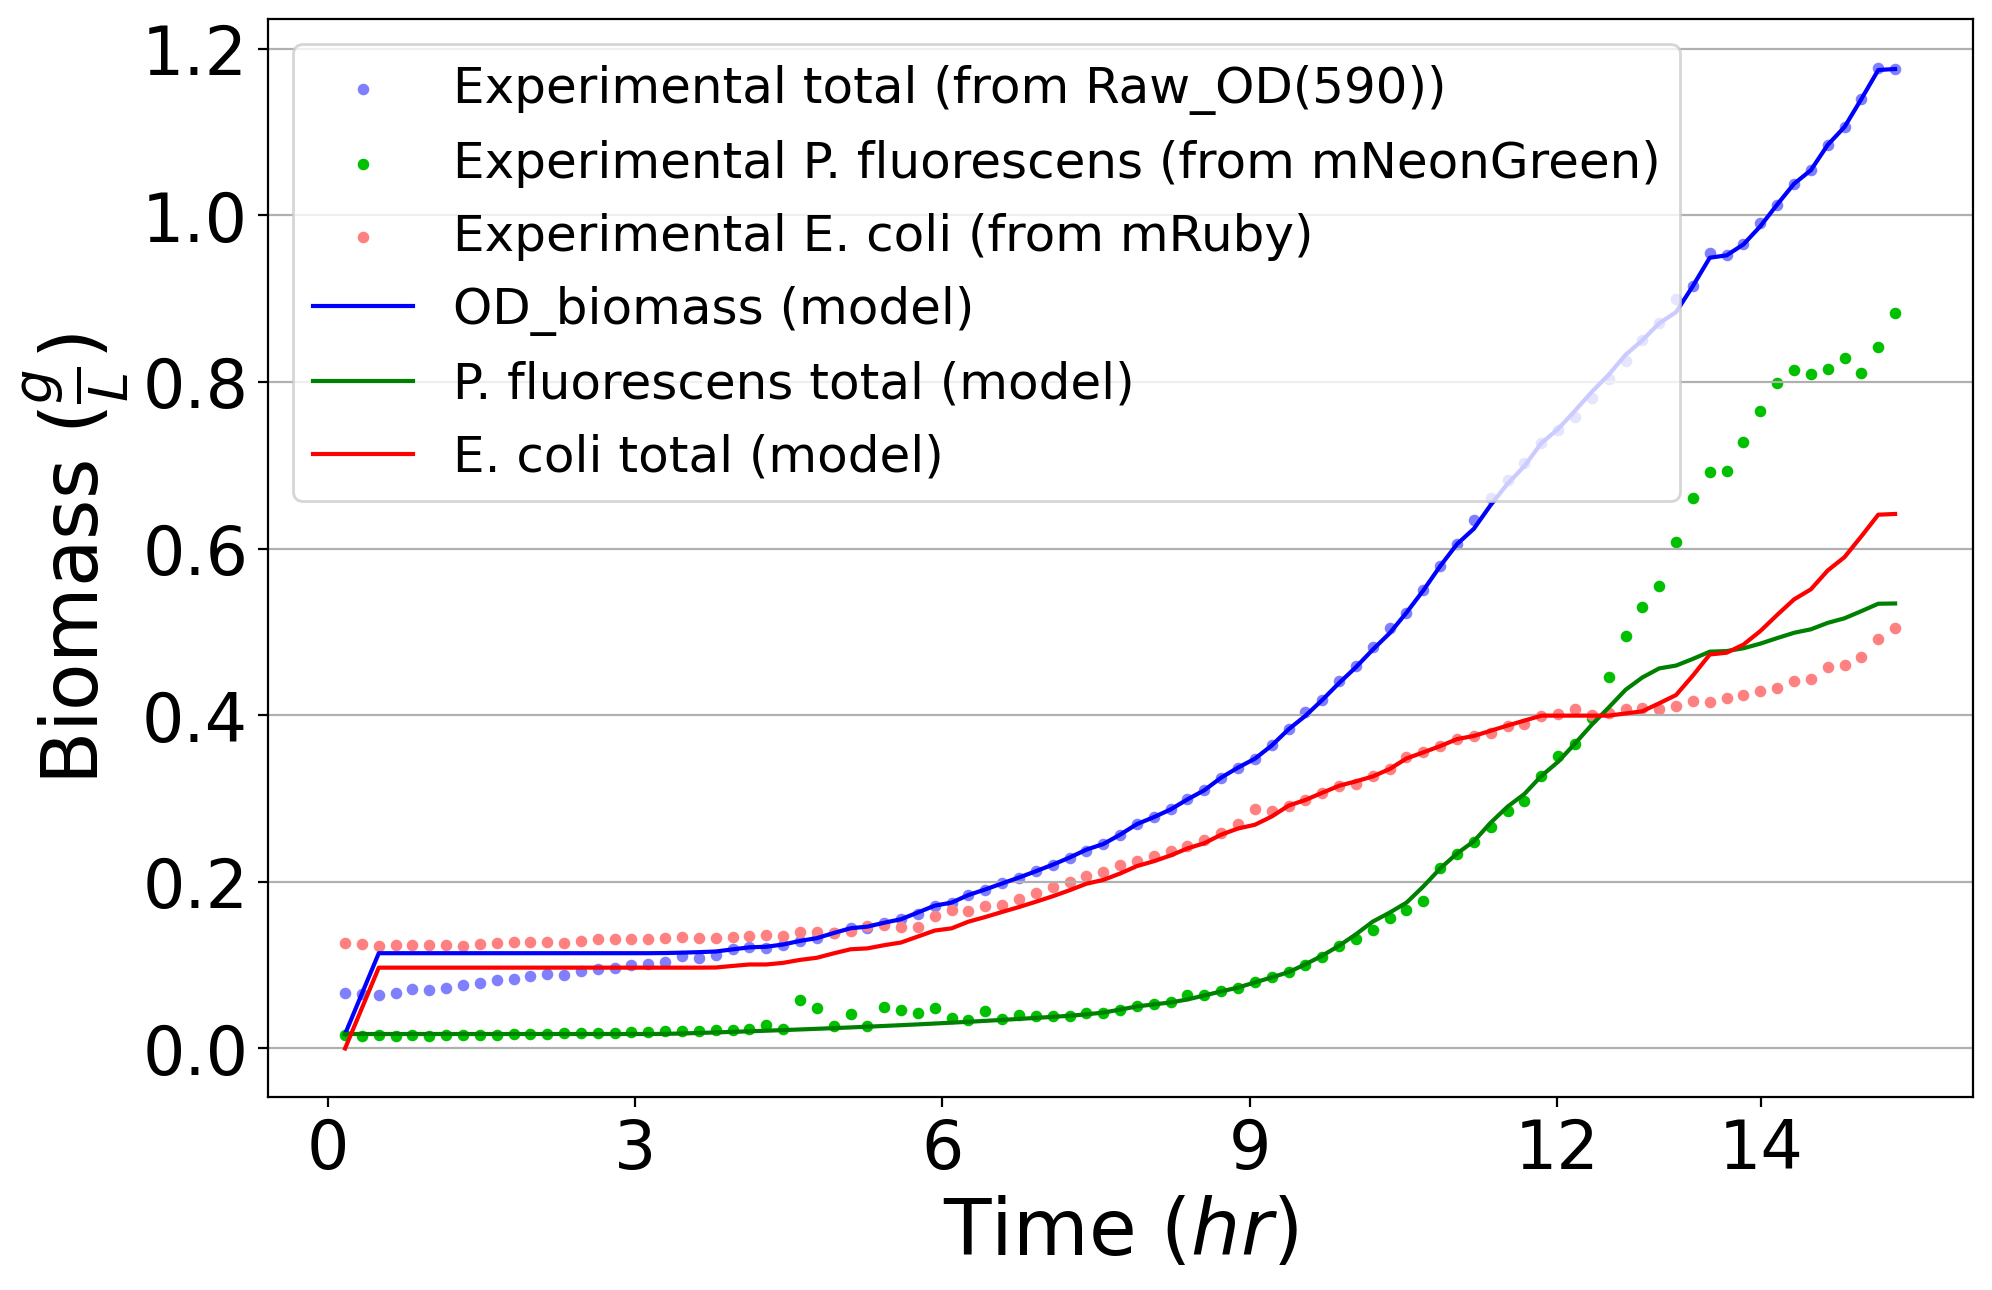

In [8]:
%%time

%run ../../../../ModelSEED/ModelSEEDpy/modelseedpy/community/mscommphitting.py

def _partition_coefs(initial_val, divisor):
    return (initial_val, initial_val/divisor, initial_val/divisor**2, initial_val/divisor**3, initial_val/divisor**4)

test_com = MSCommPhitting('../../../../ModelSEED/ModelSEEDDatabase',
                           community_members = {
                                ecoli: {
                                    'name': 'ecoli', 
                                    'phenotypes': {
                                        'Maltose': {"consumed":["cpd00179"],
                                                 "excreted":["cpd00029"]}, #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                                        'Acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                                        }
                                },
                                pf: {
                                    'name': 'pf',
                                    'phenotypes': {
                                        'Acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                                        '4-Hydroxybenzoate': {"consumed":["cpd00136"]}, # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                                        # 'Glycerol': {"consumed":["cpd00100"],
                                        #          "excreted":["cpd00266"]}, #kbase_api.get_from_ws('93465/13/1'), 
                                        }
                                }
                            },
                            data_paths = {'path':"../data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx", 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
                            species_abundances = species_abundances,
                            carbon_conc = carbon_conc_series,
                            ignore_trials = {'rows': ['C', 'D', 'E', 'B', 'G'], 'columns': [1,2,3,4,5,6,7,8,10,11,12]},
                            species_identities_rows = species_identities_rows)

test_com.fit_kcat(parameters = {'cvmin': 6e-1, 'bcv': 6e-1, "stationary": 1e-2},
                  rel_final_conc = {"cpd00179":0.2, "cpd00136":0.2},
                  zero_start = ["cpd00029"],
                  abs_final_conc = {"cpd00029":0}, # metabolomics data
                  graphs=update_graphs("G52"),
                  export_zip_name = 'maltose_4HB_co.zip',
                  export_lp = "maltose_4HB_co.lp",
                  primals_export_path="maltose_4HB_co_primals.json")

In [ ]:
%run ../data/standardized_data/datastandardization.py
growth_data_path="../data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx"
time1 = process_time()
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        ecoli: {
            'name': 'ecoli', 
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                'malt': {"consumed":["cpd00179"],
                         "excreted":["cpd00029"]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                }
        },
        pf: {
            'name': 'pf',
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                '4HB': {"consumed":["cpd00136"]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
    species_abundances = species_abundances,
    carbon_conc_series = carbon_conc_series,
    ignore_trials = {'rows': ['C', 'D', 'E', 'B', 'G'], 'columns': [1,2,3,4,5,6,8,9,10,11,12]},
    species_identities_rows = species_identities_rows
)
print(f"{(process_time()-time1)/60} minutes")

In [ ]:
%run ../mscommphitting.py

maltose_4HB_commfit = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
maltose_4HB_commfit.fit_kcat(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
    mets_to_track = ["cpd00179","cpd00029","cpd00136"],
    rel_final_conc = {"cpd00179":0.2, "cpd00136":0.2},
    zero_start = ["cpd00029"],
    abs_final_conc = {"cpd00029":0.1}, # metabolomics data
    graphs = update_graphs("G50"),
    export_zip_name = 'maltose_4HB_commfit.zip', 
    requisite_biomass = requisite_biomass,
    publishing = True,
    export_lp = "maltose_4HB_coculture.lp")

#### Pseudomonas

In [ ]:
%run ../data/standardized_data/datastandardization.py
growth_data_path="../data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx"
time1 = process_time()
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        pf: {
            'name': 'pf',
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                '4HB': {"consumed":["cpd00136"]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'mNeonGreen':'pf'},
    species_abundances = species_abundances,
    carbon_conc_series = carbon_conc_series,
    ignore_trials = {'rows': ['C', 'D', 'E', 'B', 'G'], 'columns': [1,3,4,5,6,7,8,9,10,11,12]},
    species_identities_rows = species_identities_rows
)
print(f"{(process_time()-time1)/60} minutes")

In [ ]:
%run ../mscommphitting.py
maltose_4HB_pf = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
maltose_4HB_pf.fit_kcat(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 1},
    mets_to_track = ["cpd00179","cpd00136"],
    rel_final_conc = {"cpd00136":0.1},
    zero_start = ["cpd00029"],
    # abs_final_conc = {"cpd00029":0.1}, # metabolomics data
    graphs = update_graphs("G45"),
    export_zip_name = 'maltose_4HB_pf.zip', 
    requisite_biomass = requisite_biomass,
    publishing = True,
    export_lp = "maltose_4HB_pf.lp")

#### E. coli

In [ ]:
%run ../data/standardized_data/datastandardization.py
growth_data_path="../data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx"
time1 = process_time()
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        ecoli: {
            'name': 'ecoli', 
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                'malt': {"consumed":["cpd00179"],
                         "excreted":["cpd00029"]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
            }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'mRuby':'ecoli'},
    species_abundances = species_abundances,
    carbon_conc_series = carbon_conc_series,
    ignore_trials = {'rows': ['C', 'D', 'E', 'B', 'G'], 'columns': [1,2,3,4,5,6,7,8,9,10,12]},
    species_identities_rows = species_identities_rows
)
print(f"{(process_time()-time1)/60} minutes")

In [ ]:
%run ../mscommphitting.py
maltose_4HB_ecoli = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
maltose_4HB_ecoli.fit_kcat(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 1},
    mets_to_track = ["cpd00179","cpd00029"],
    rel_final_conc = {"cpd00179":0.05},
    zero_start = ["cpd00029"],
    abs_final_conc = {"cpd00029":0.1}, # metabolomics data
    graphs = update_graphs("G54"),
    export_zip_name = 'maltose_4HB_ecoli.zip', 
    requisite_biomass = requisite_biomass,
    publishing = True,
    export_lp = "maltose_4HB_ecoli.lp")

# Acetate

#### Coculture


 GCF_000005845.2.RAST.mdl
EX_cpd00179_e0
EX_cpd00029_e0

 GCF_001612705.1.RAST.mdl
EX_cpd00029_e0
EX_cpd00136_e0


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


The ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements per the ignore_trials parameter.
The [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159] timesteps (with [0.55664943 0.5585803  0.54911776 0.54616618 0.54806124 0.54696361
 0.54835377 0.54954046 0.5475263  0.55053545 0.5512014  0.55228987
 0.55174298 0.55240707 0.55513949 0.55734986 0.55782824 0.56189425
 0.56275043 0.56456209 0.56714417 0.57

ecoli_Maltose  ecoli_Acetate    pf_Acetate  \
rxn                                                          
EX_cpd00001_e0   1.618125e+01   4.544367e+01  4.533296e+01   
EX_cpd00007_e0  -6.452599e+00  -2.035609e+01 -2.025521e+01   
EX_cpd00009_e0  -7.625410e-01  -7.625410e-01 -7.625410e-01   
EX_cpd00011_e0   1.073081e+00   2.388151e+01  2.377641e+01   
EX_cpd00013_e0  -8.611666e+00  -8.611666e+00 -8.611666e+00   
EX_cpd00029_e0   1.051566e+01  -3.069851e+01 -3.063614e+01   
EX_cpd00030_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00034_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00047_e0   1.781127e+01   0.000000e+00  0.000000e+00   
EX_cpd00048_e0  -2.263972e-01  -2.263972e-01 -2.263972e-01   
EX_cpd00058_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00063_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00067_e0   3.485430e+01  -2.417395e+01 -2.411719e+01   
EX_cpd00099_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00116_e0   2.806159e-03   2.806159e-03  2.806159e-03   
EX_cpd00136_e0   0.000000e+00   0.000000e+00  0.000000e+00   
EX_cpd00142_e0  -2.155574e-12   0.000000e+00  0.000000e+00   
EX_cpd00149_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00179_e0  -6.452599e+00   0.000000e+00  0.000000e+00   
EX_cpd00205_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00254_e0  -2.806159e-03  -2.806159e-03 -2.806159e-03   
EX_cpd00609_e0   1.080143e-15   0.000000e+00  0.000000e+00   
EX_cpd00751_e0   5.380949e-29   0.000000e+00  0.000000e+00   
EX_cpd01914_e0   1.315265e-12   0.000000e+00  0.000000e+00   
EX_cpd03048_e0   6.972492e-13   0.000000e+00  0.000000e+00   
EX_cpd10515_e0  -8.418477e-03  -1.122464e-02 -1.122464e-02   
EX_cpd10516_e0  -2.806159e-03  -1.359101e-11  4.321634e-12   
EX_cpd15378_e0   2.806159e-03   2.806159e-03  0.000000e+00   
bio              1.000000e+00   1.000000e+00  1.000000e+00   

                pf_4~Hydroxybenzoate  
rxn                                   
EX_cpd00001_e0          2.449548e+01  
EX_cpd00007_e0         -5.333079e+01  
EX_cpd00009_e0         -7.625410e-01  
EX_cpd00011_e0          5.685199e+01  
EX_cpd00013_e0         -8.611666e+00  
EX_cpd00029_e0          0.000000e+00  
EX_cpd00030_e0         -2.806159e-03  
EX_cpd00034_e0         -2.806159e-03  
EX_cpd00047_e0          0.000000e+00  
EX_cpd00048_e0         -2.263972e-01  
EX_cpd00058_e0         -2.806159e-03  
EX_cpd00063_e0         -2.806159e-03  
EX_cpd00067_e0         -2.043758e+01  
EX_cpd00099_e0         -2.806159e-03  
EX_cpd00116_e0          2.806159e-03  
EX_cpd00136_e0         -1.347827e+01  
EX_cpd00142_e0          0.000000e+00  
EX_cpd00149_e0         -2.806159e-03  
EX_cpd00179_e0          0.000000e+00  
EX_cpd00205_e0         -2.806159e-03  
EX_cpd00254_e0         -2.806159e-03  
EX_cpd00609_e0          0.000000e+00  
EX_cpd00751_e0          0.000000e+00  
EX_cpd01914_e0          0.000000e+00  
EX_cpd03048_e0          0.000000e+00  
EX_cpd10515_e0         -1.122464e-02  
EX_cpd10516_e0         -3.288257e-13  
EX_cpd15378_e0          0.000000e+00  
bio                     1.000000e+00

Done with concentrations and biomass loops: 0.029427083333333333 min
Done with DCC loop: 0.00390625 min
Done with the DBC & diffc loop: 0.00703125 min
Done with constructing the <class 'optlang.glpk_interface.Model'> model: 0.13880208333333333 min
Done exporting the content: 0.20364583333333333 min
starting optimization


C:\Users\Andrew Freiburger\Documents\Argonne\ModelSEED\ModelSEEDpy\modelseedpy\community\mscommphitting.py:900: UserWarning: The conversion factor 5e-06 optimized to a bound, which may be indicative of an error, such as improper kinetic rates.
  if all(np.array(list(self.problem.primal_values.values())) == 0):


acetate_co.zip
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'Acetate', 'stationary', '4~Hydroxybenzoate', 'Maltose'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G38'}
graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179', 'cpd00136', 'cpd00029'],
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color'

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'acetate_co.lp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.2125 min
starting optimization


C:\Users\Andrew Freiburger\Documents\Argonne\ModelSEED\ModelSEEDpy\modelseedpy\community\mscommphitting.py:900: UserWarning: The conversion factor 5e-06 optimized to a bound, which may be indicative of an error, such as improper kinetic rates.
  if all(np.array(list(self.problem.primal_values.values())) == 0):
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'acetate_co_primals.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


acetate_co.zip
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'Acetate', 'stationary', '4~Hydroxybenzoate', 'Maltose'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G38'}
graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179', 'cpd00136', 'cpd00029'],
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color'

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G38_OD_Acetate,stationary,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G38_ecoli_Acetate,stationary,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G38_pf_Acetate,stationary,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G38_all species_Acetate,stationary,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force

Optimization completed in 0.37005208333333334 minutes
Graphing completed in 0.012239583333333333 minutes
{'ecoli': {'Acetate': 0.0008250000000000001, 'Maltose': 137.374875},
 'pf': {'4~Hydroxybenzoate': 13.748625, 'Acetate': 0.2475}}
Done simulating with the coefficients for biomass partitions: 1	0.38229166666666664 minutes
Done with concentrations and biomass loops: 0.029947916666666668 min
Done with DCC loop: 0.0036458333333333334 min
Done with the DBC & diffc loop: 0.005989583333333334 min
Done with constructing the <class 'optlang.glpk_interface.Model'> model: 0.13776041666666666 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'acetate_co.lp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.21692708333333333 min
starting optimization


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'acetate_co_primals.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


acetate_co.zip
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'Acetate', 'stationary', '4~Hydroxybenzoate', 'Maltose'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G38'}
graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179', 'cpd00136', 'cpd00029'],
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color'

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G38_OD_Acetate,stationary,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G38_ecoli_Acetate,stationary,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G38_pf_Acetate,stationary,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G38_all species_Acetate,stationary,4~Hydroxybenzoate,Maltose phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force

{}

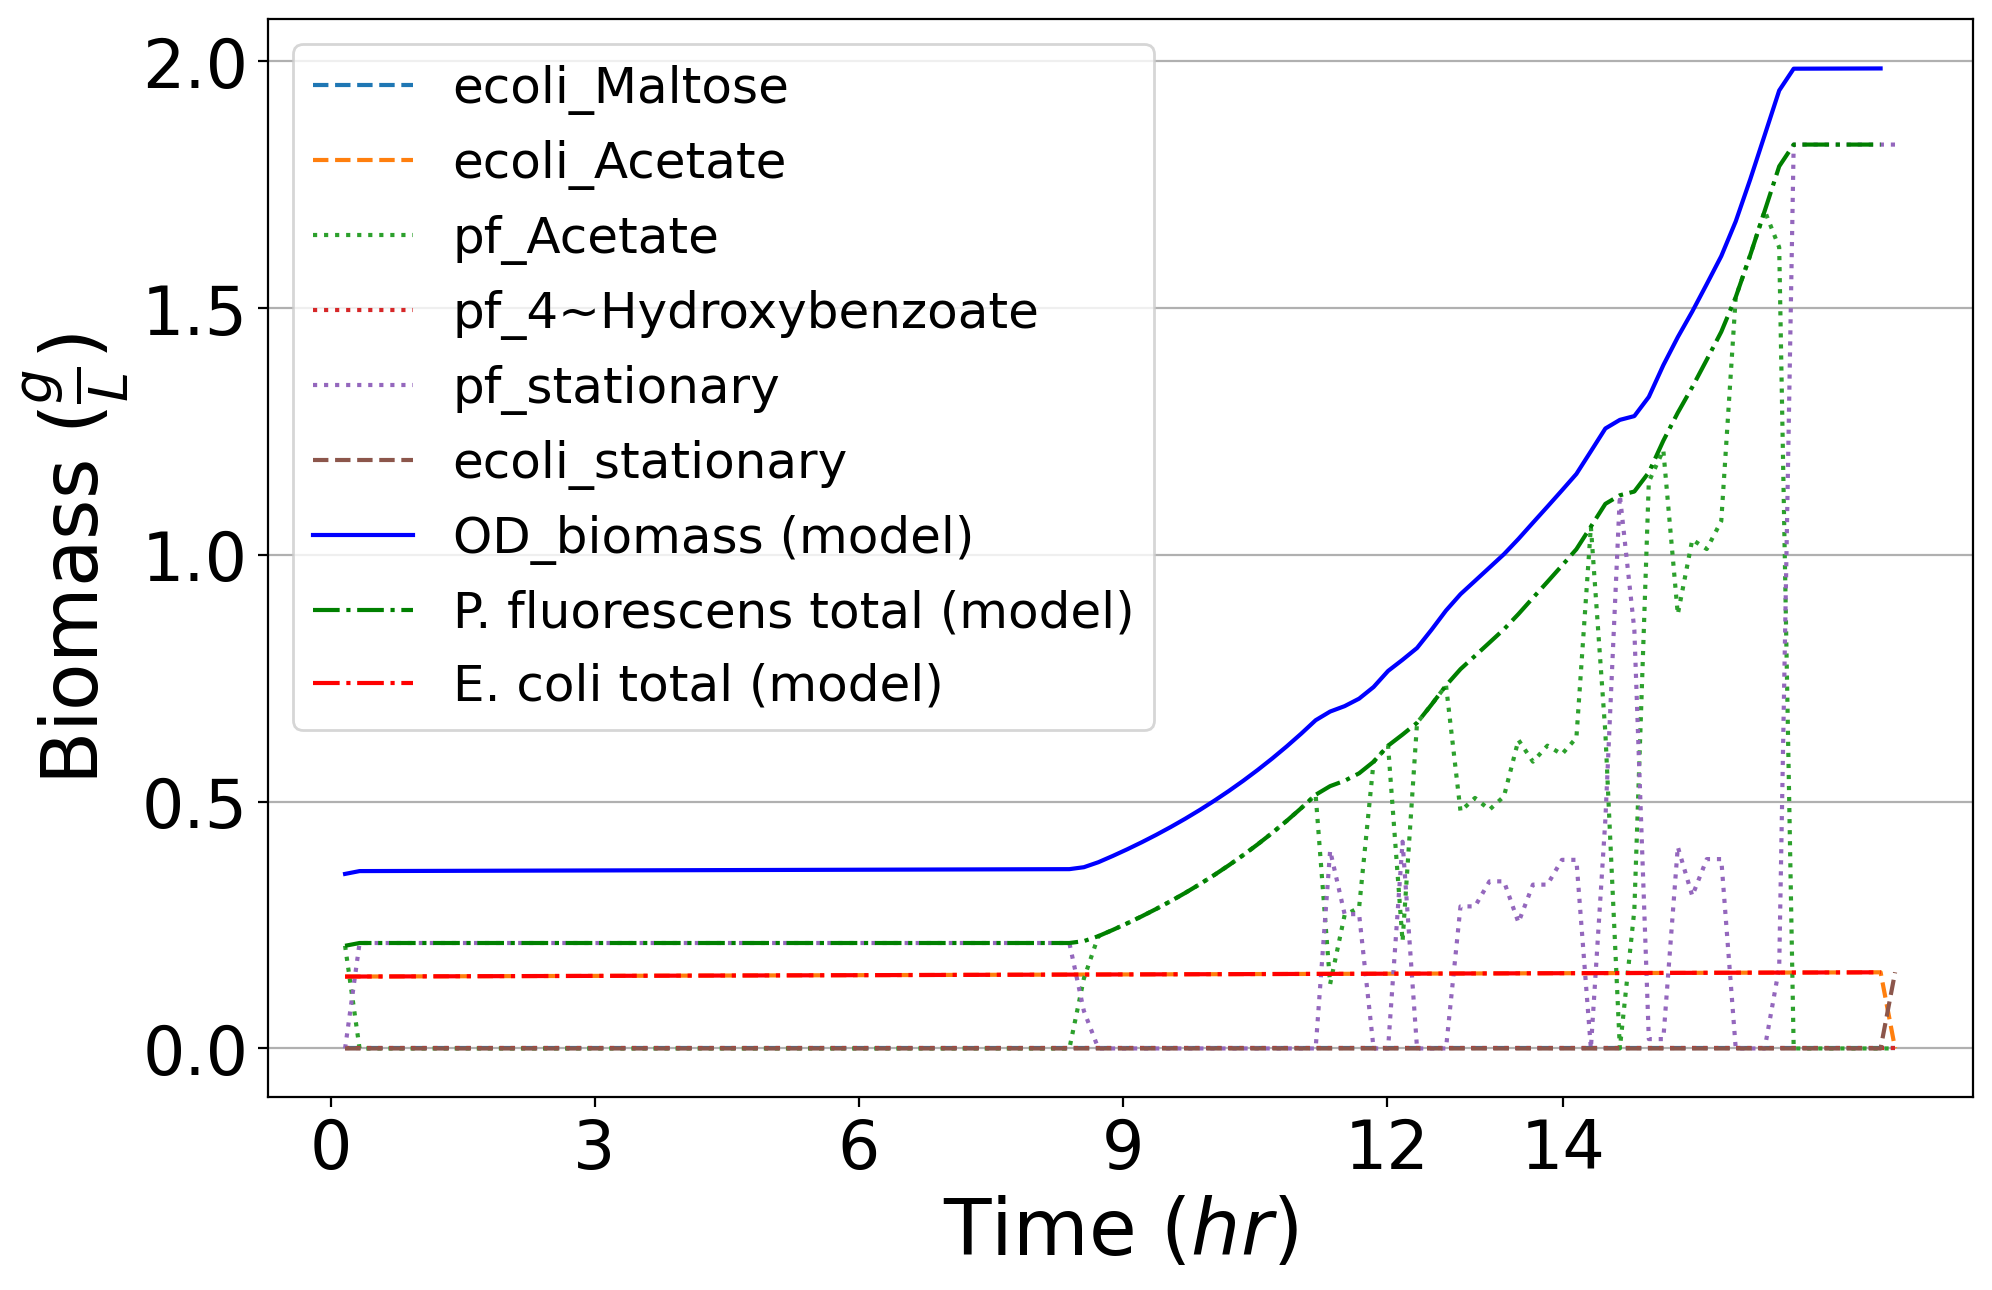

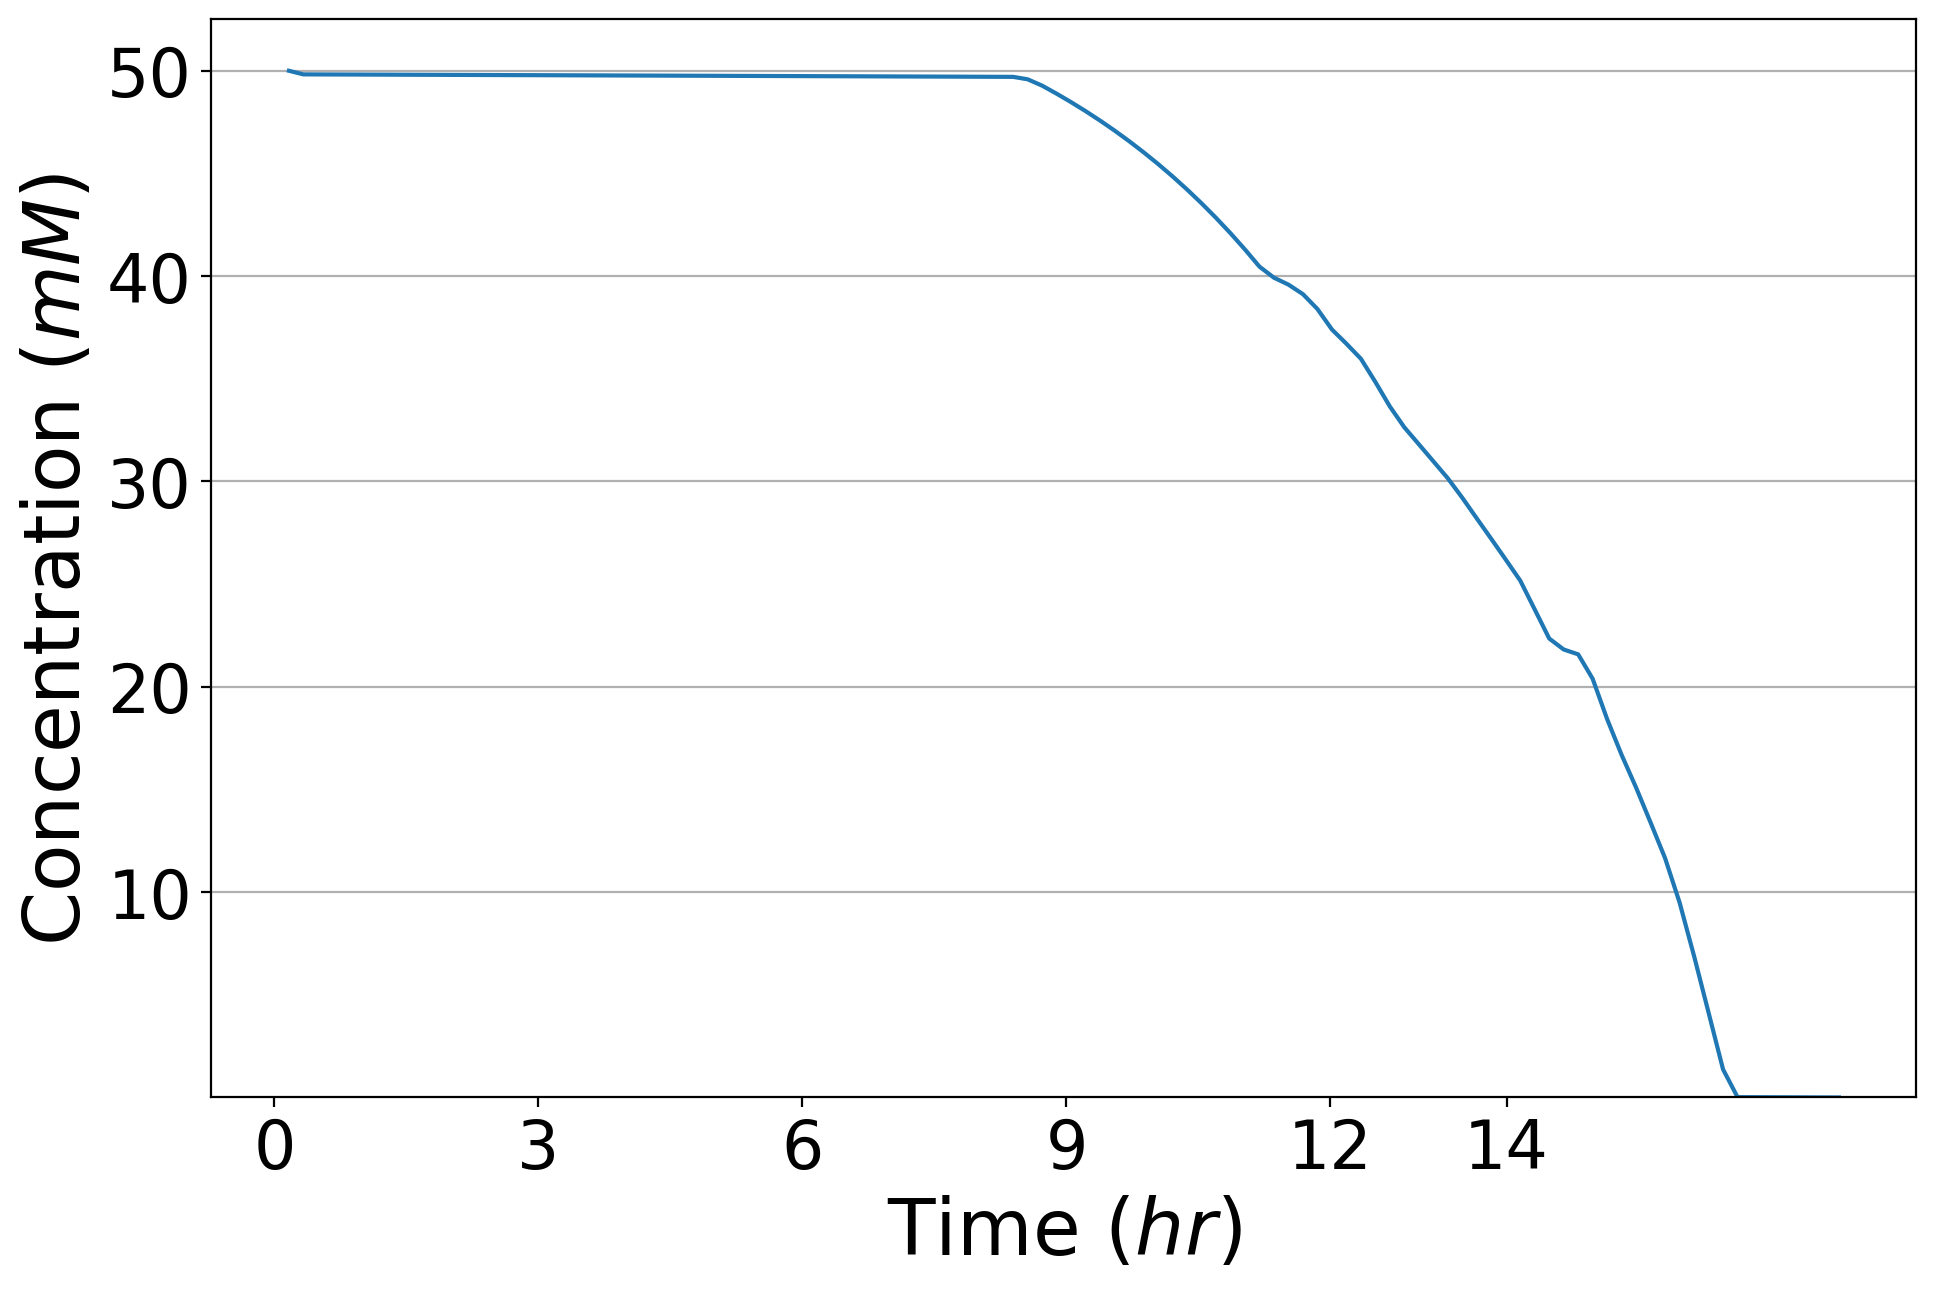

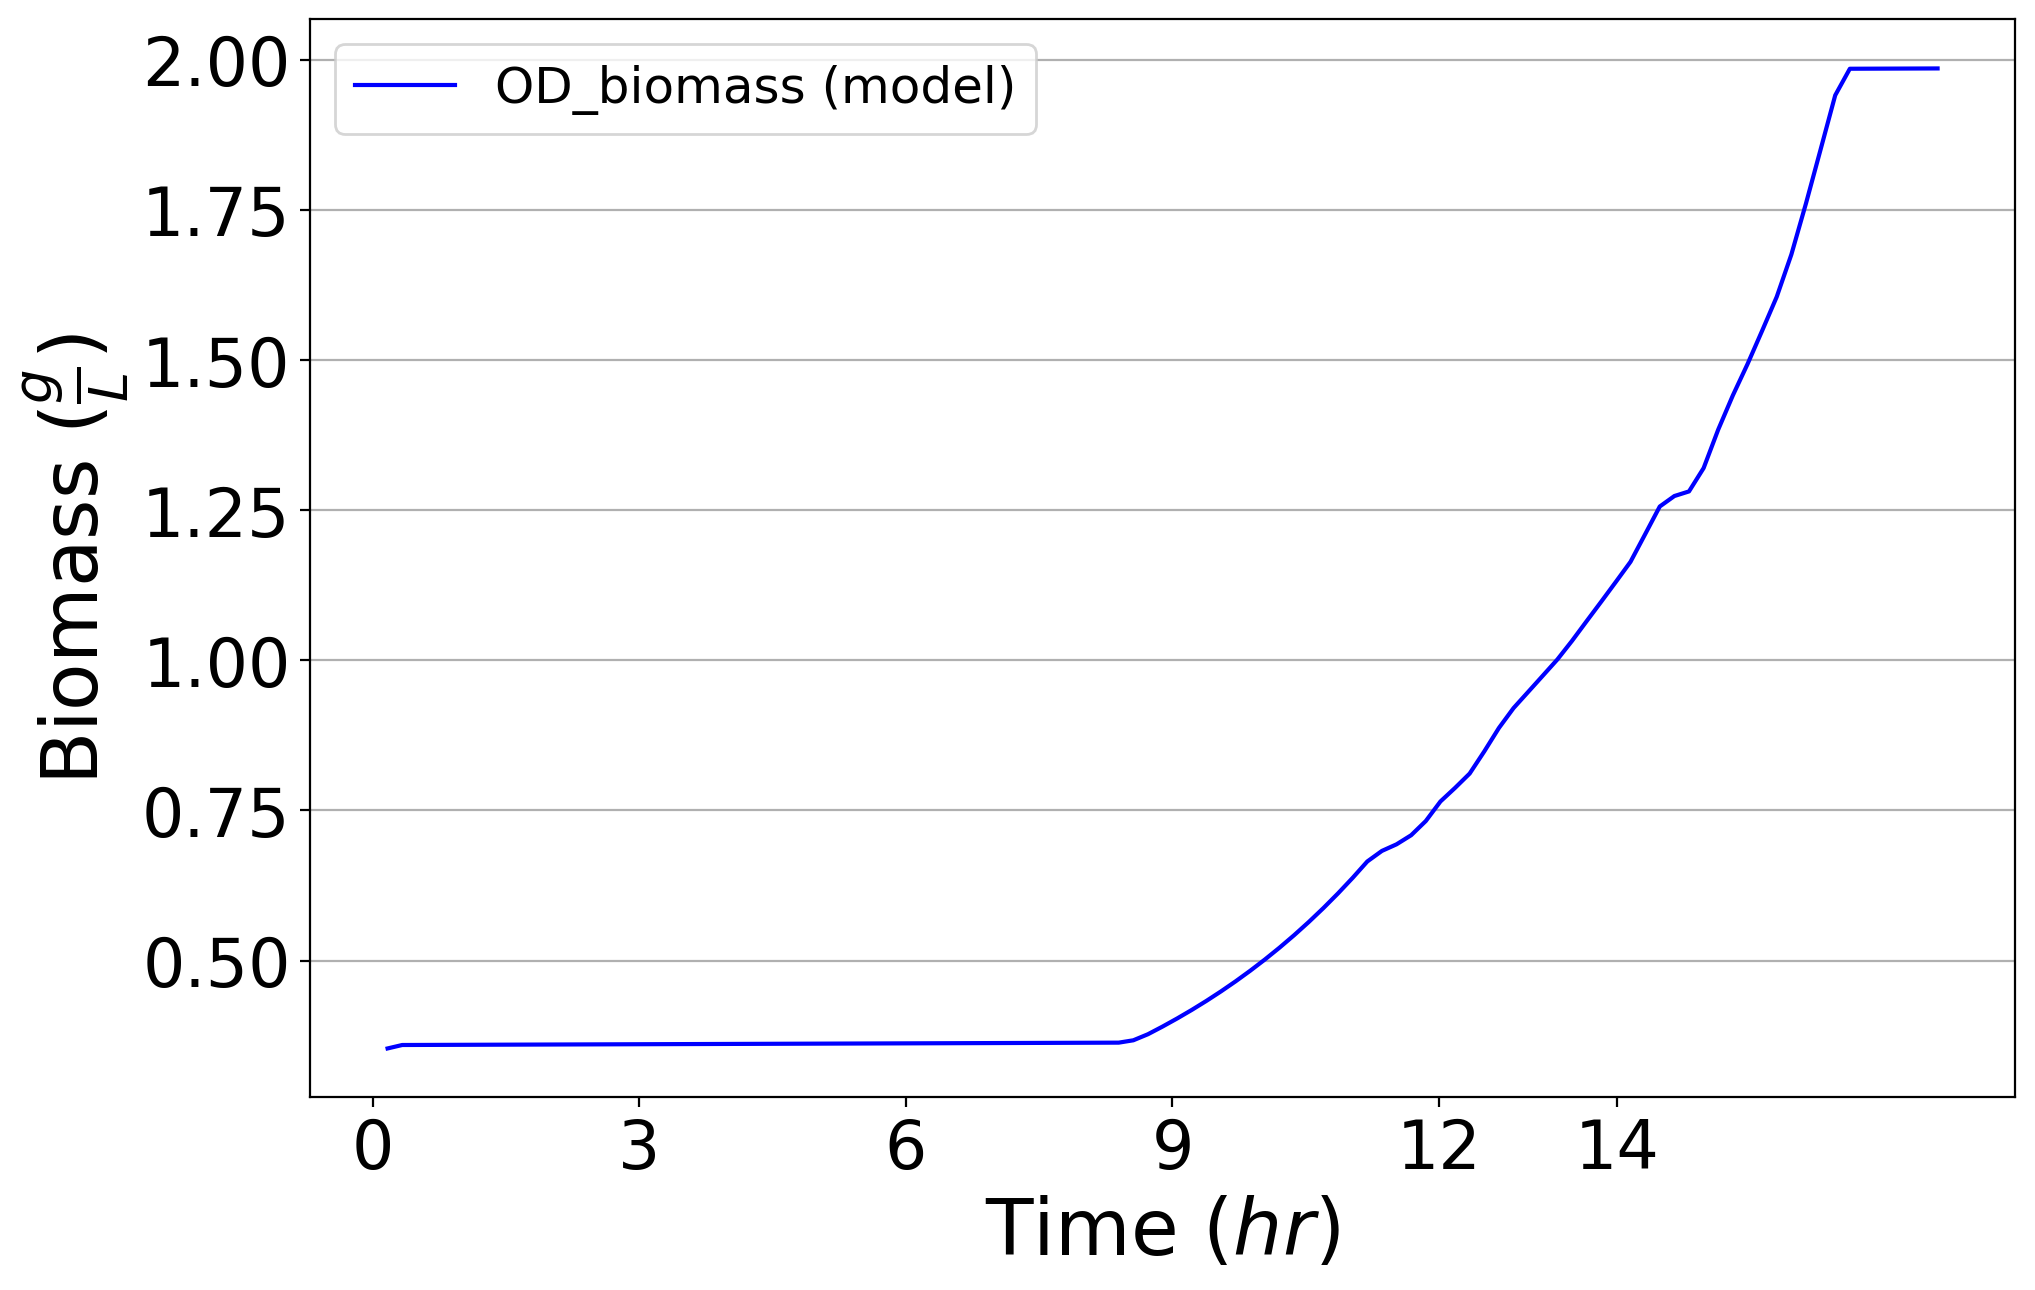

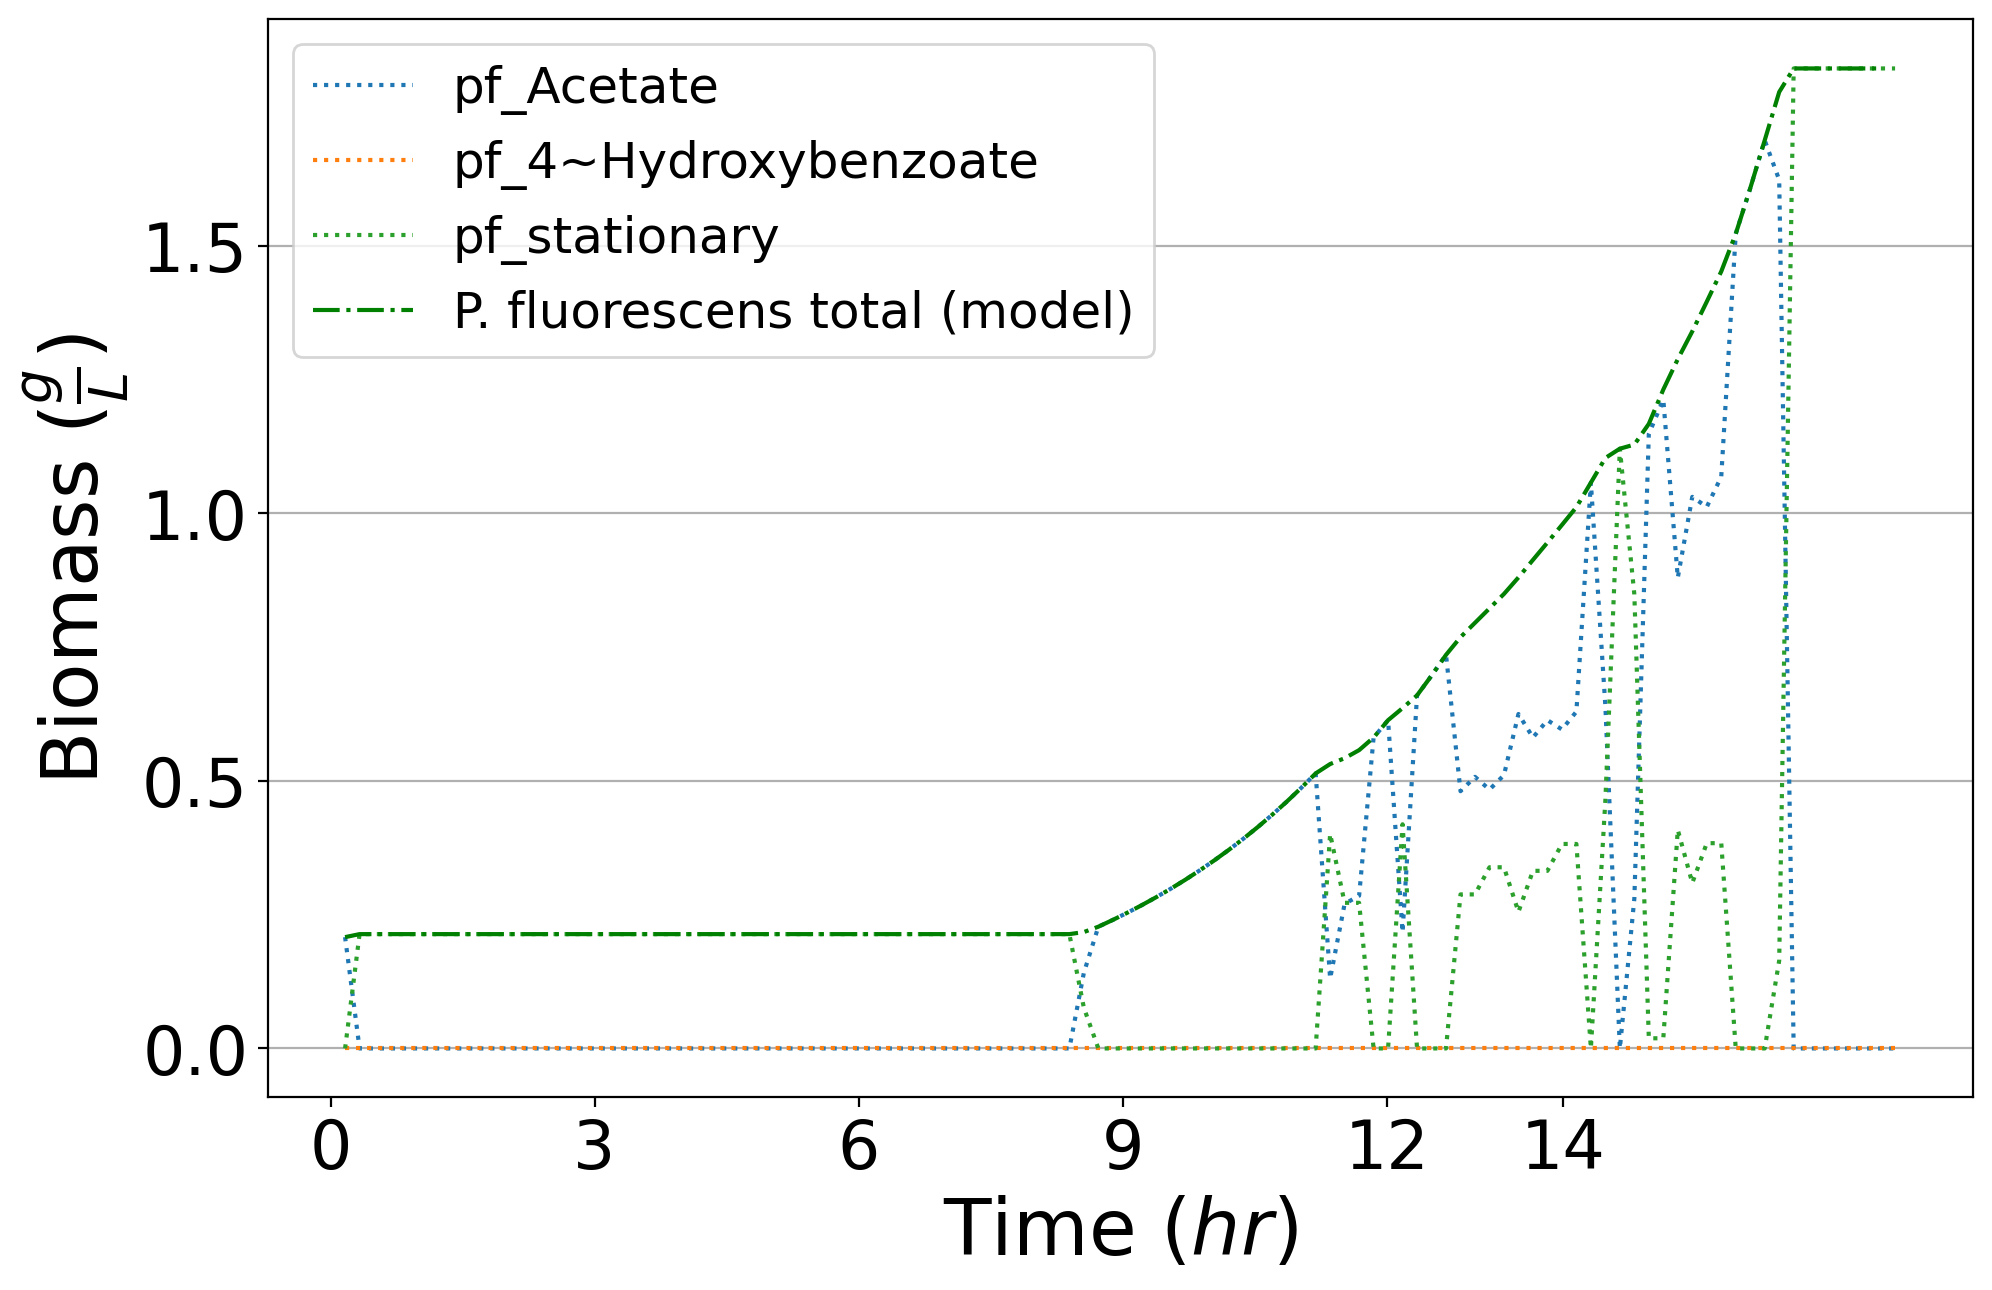

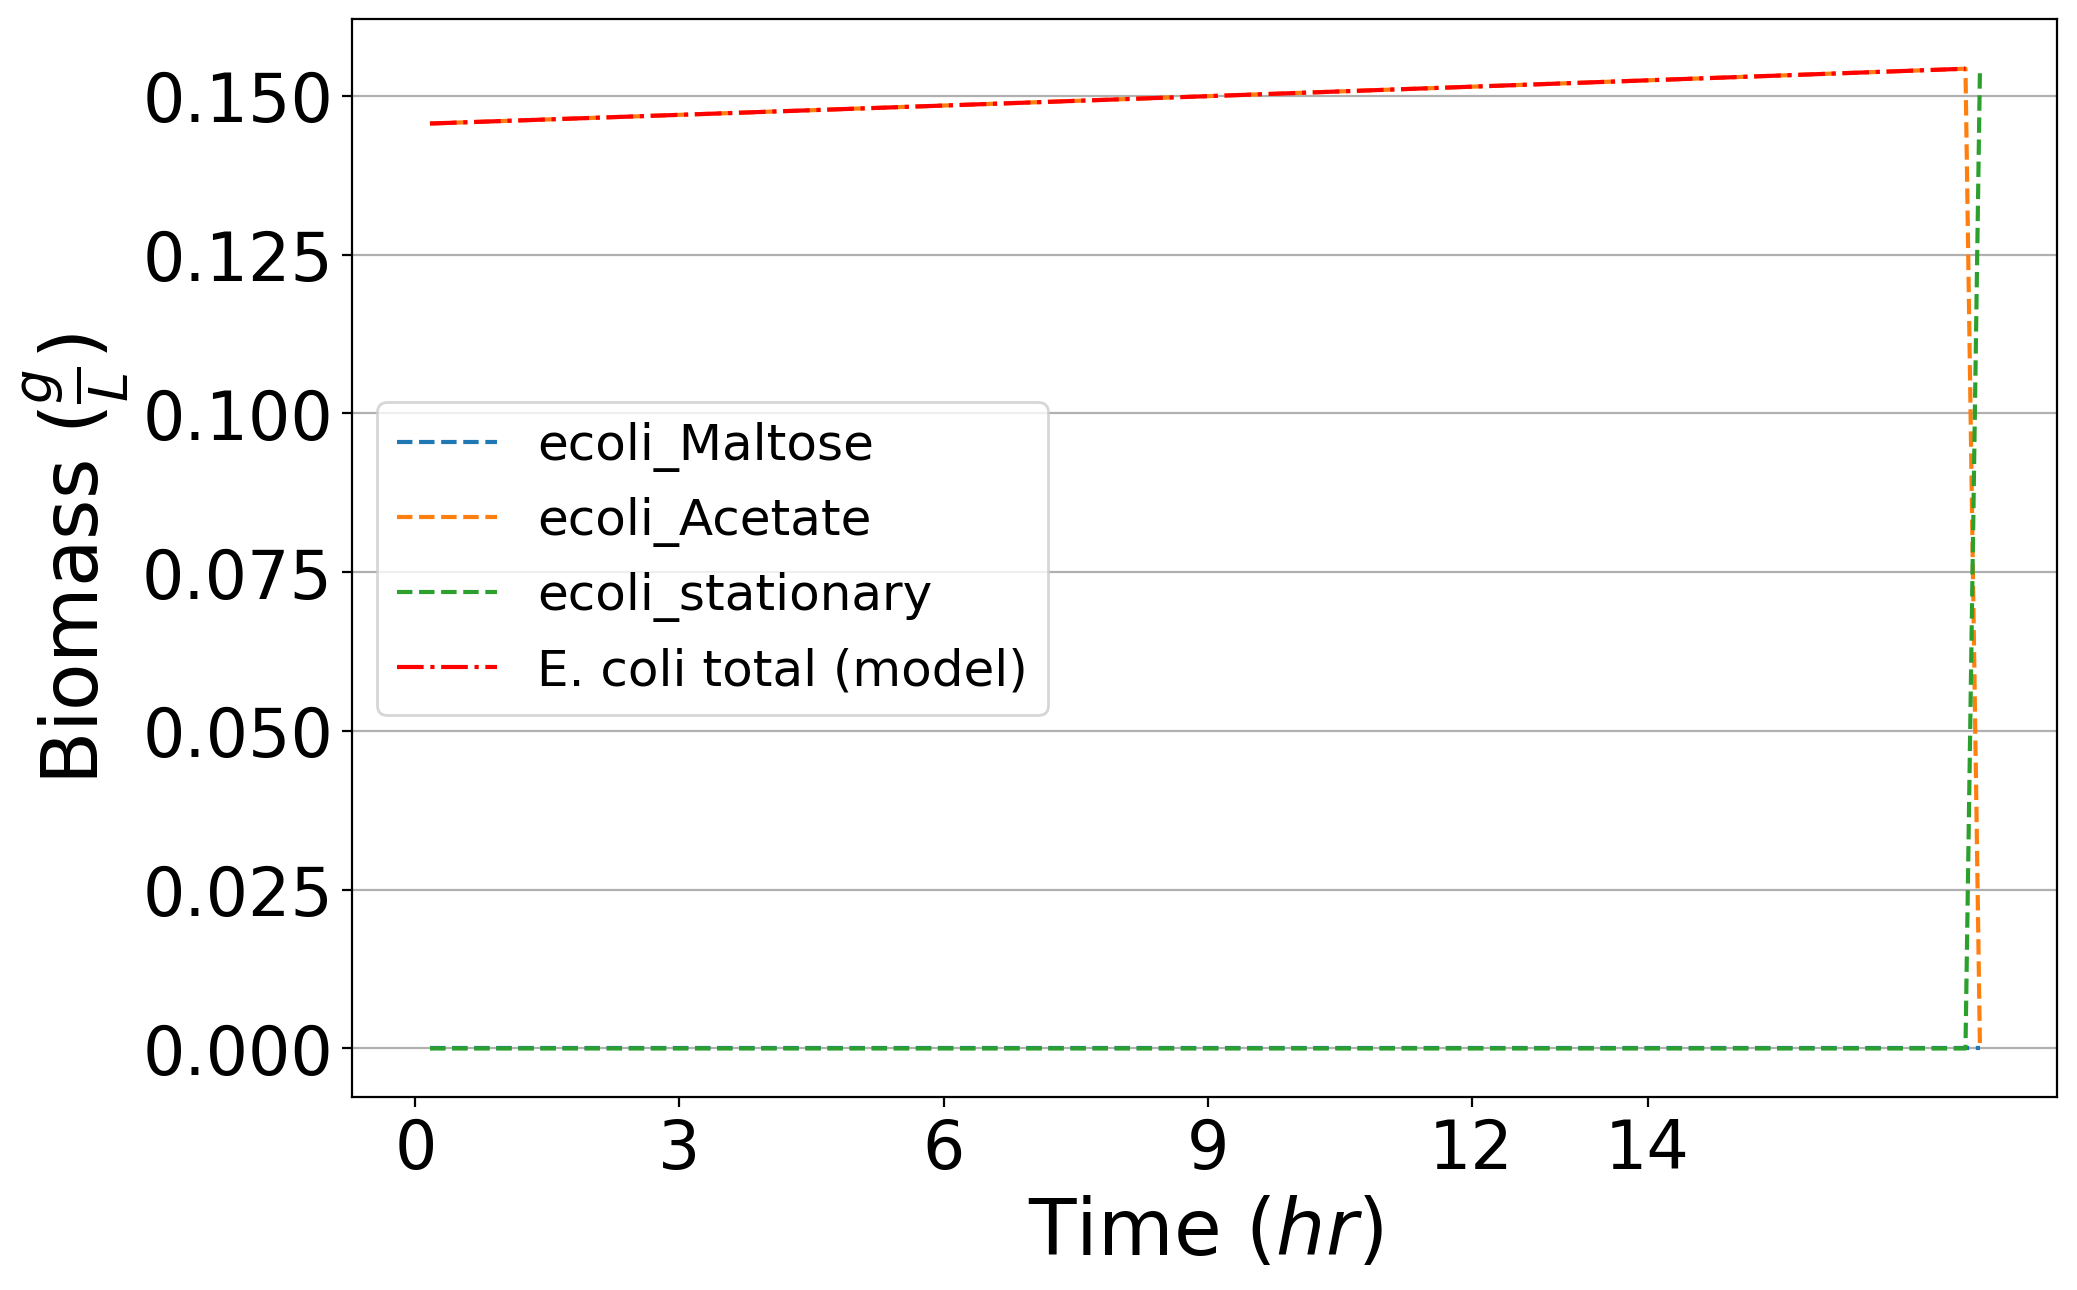

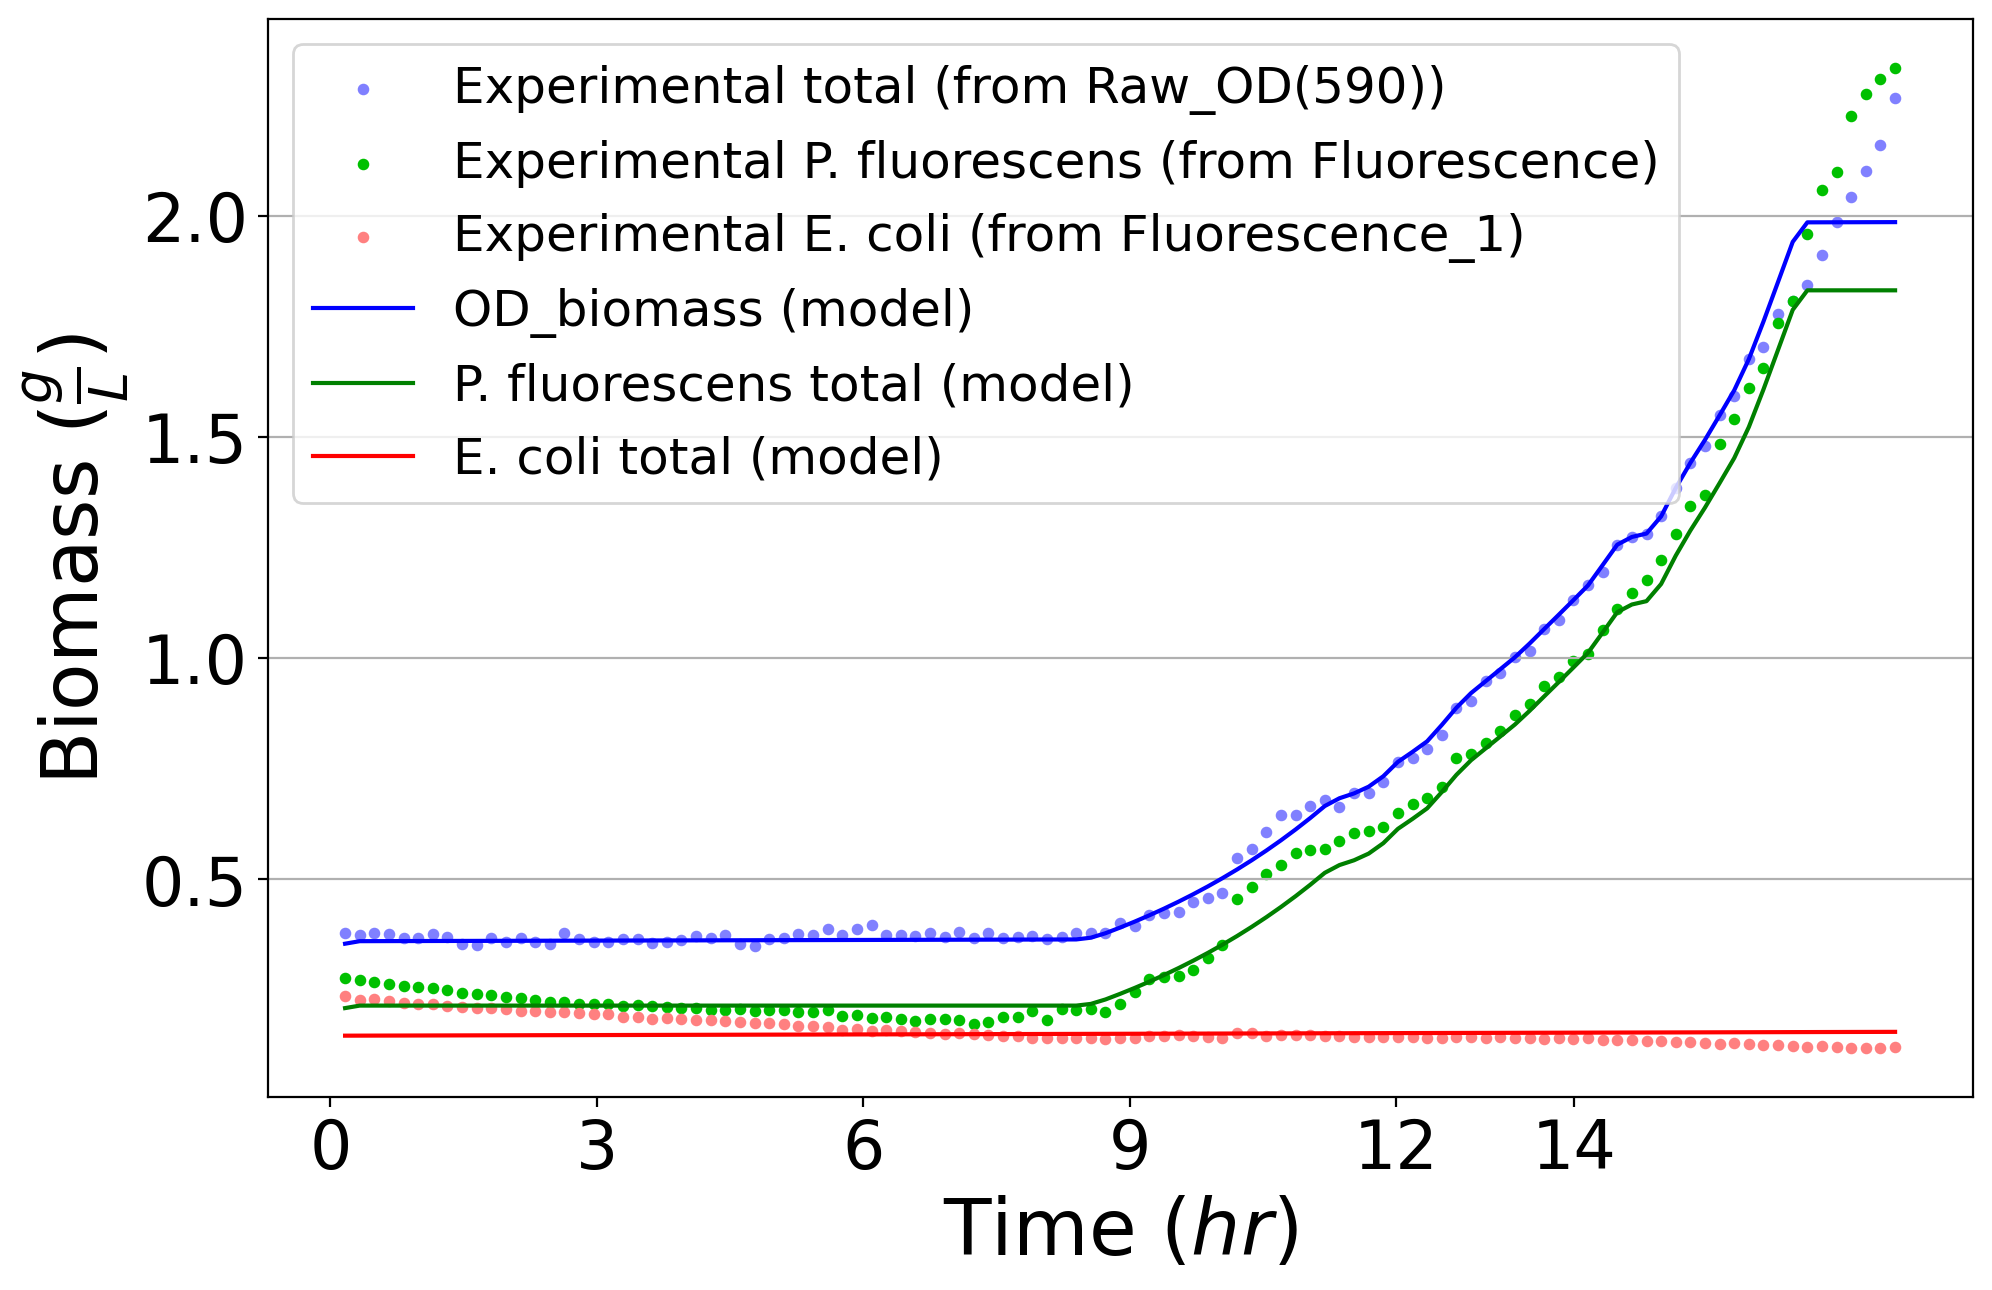

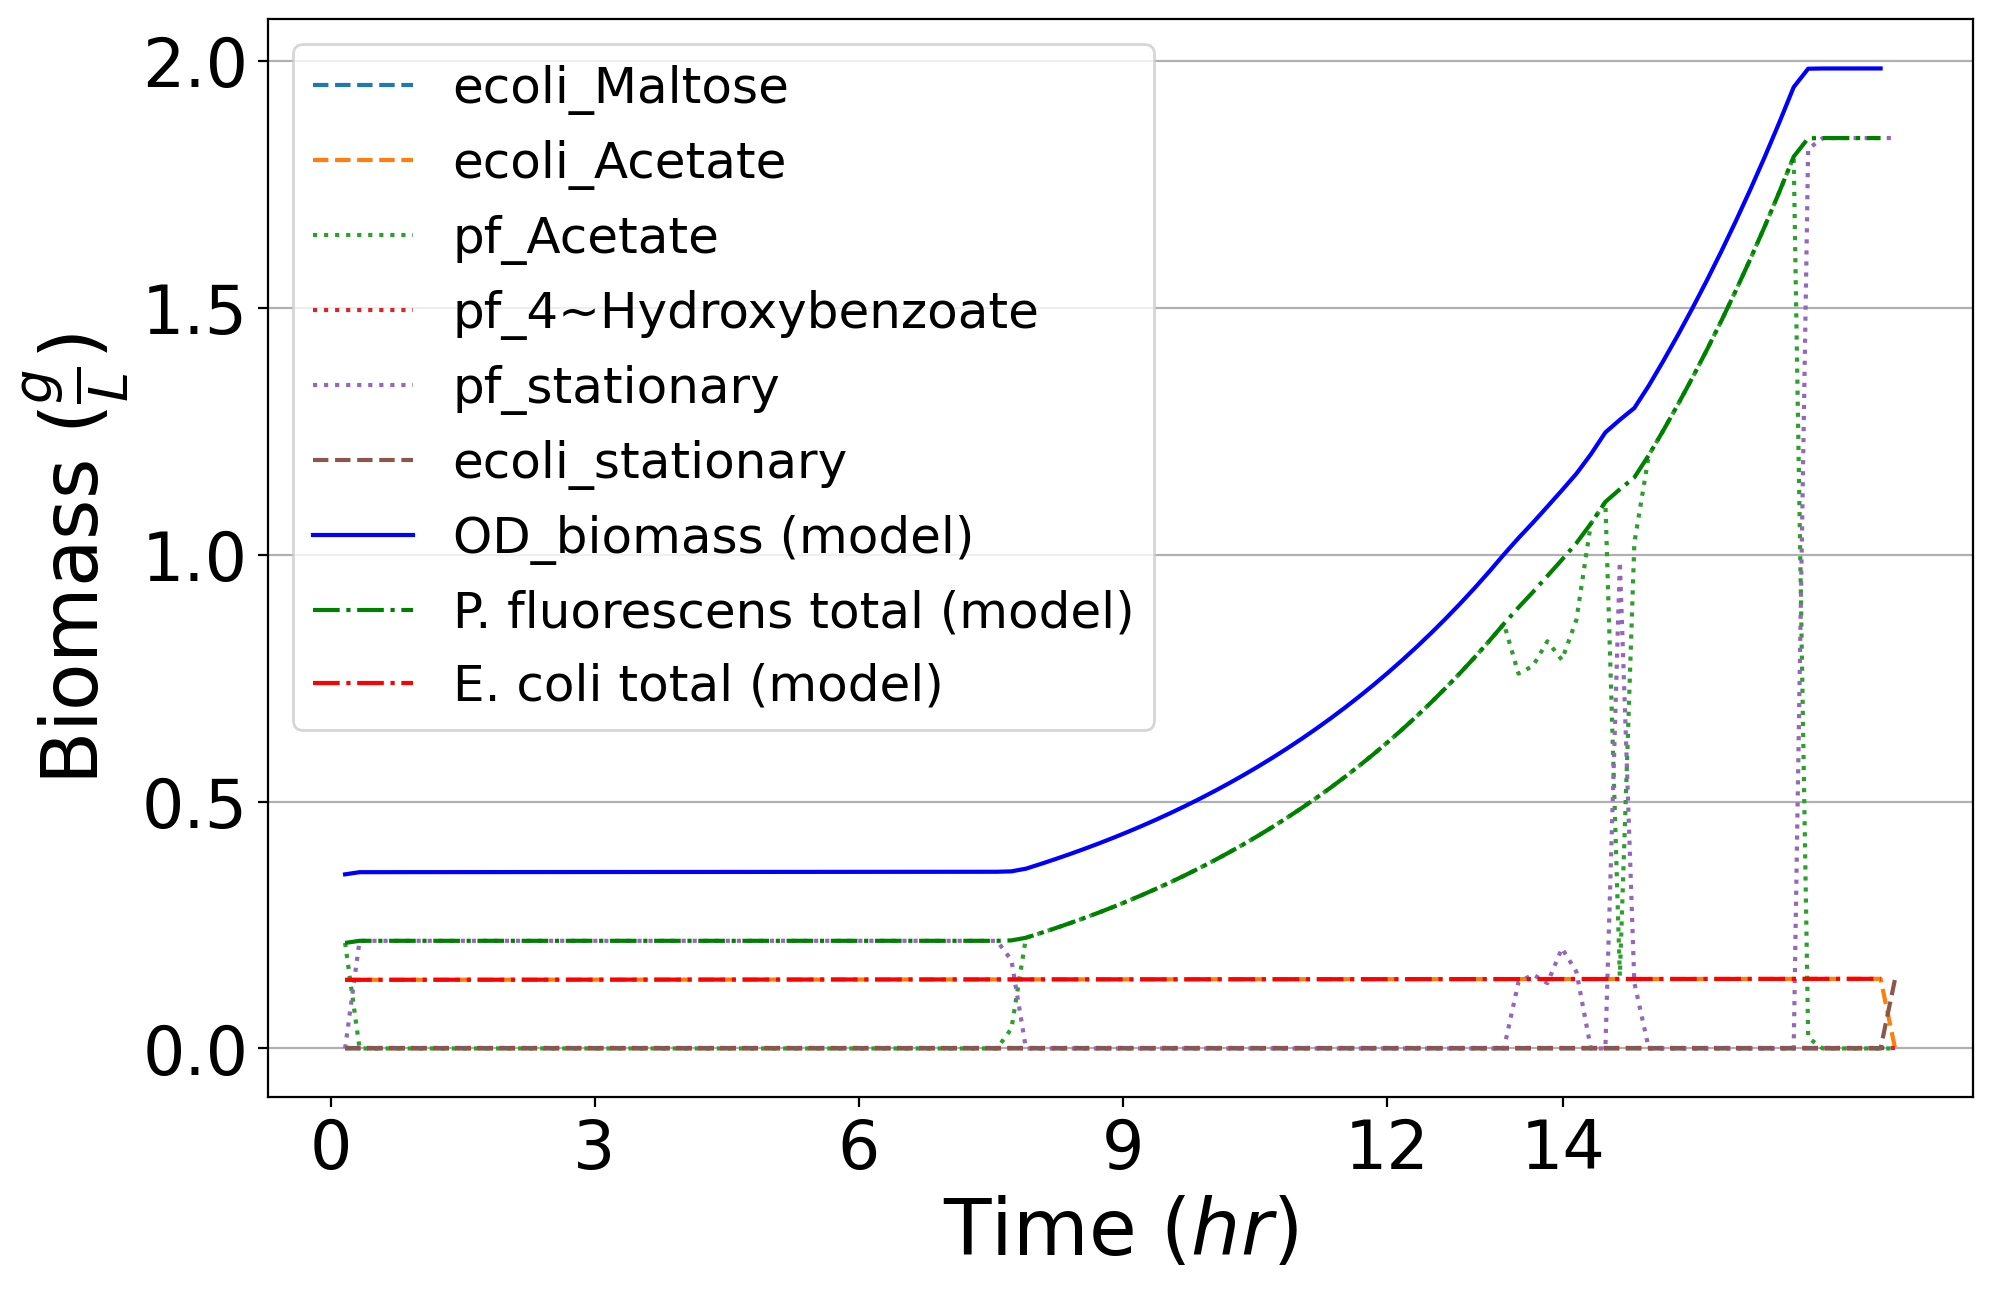

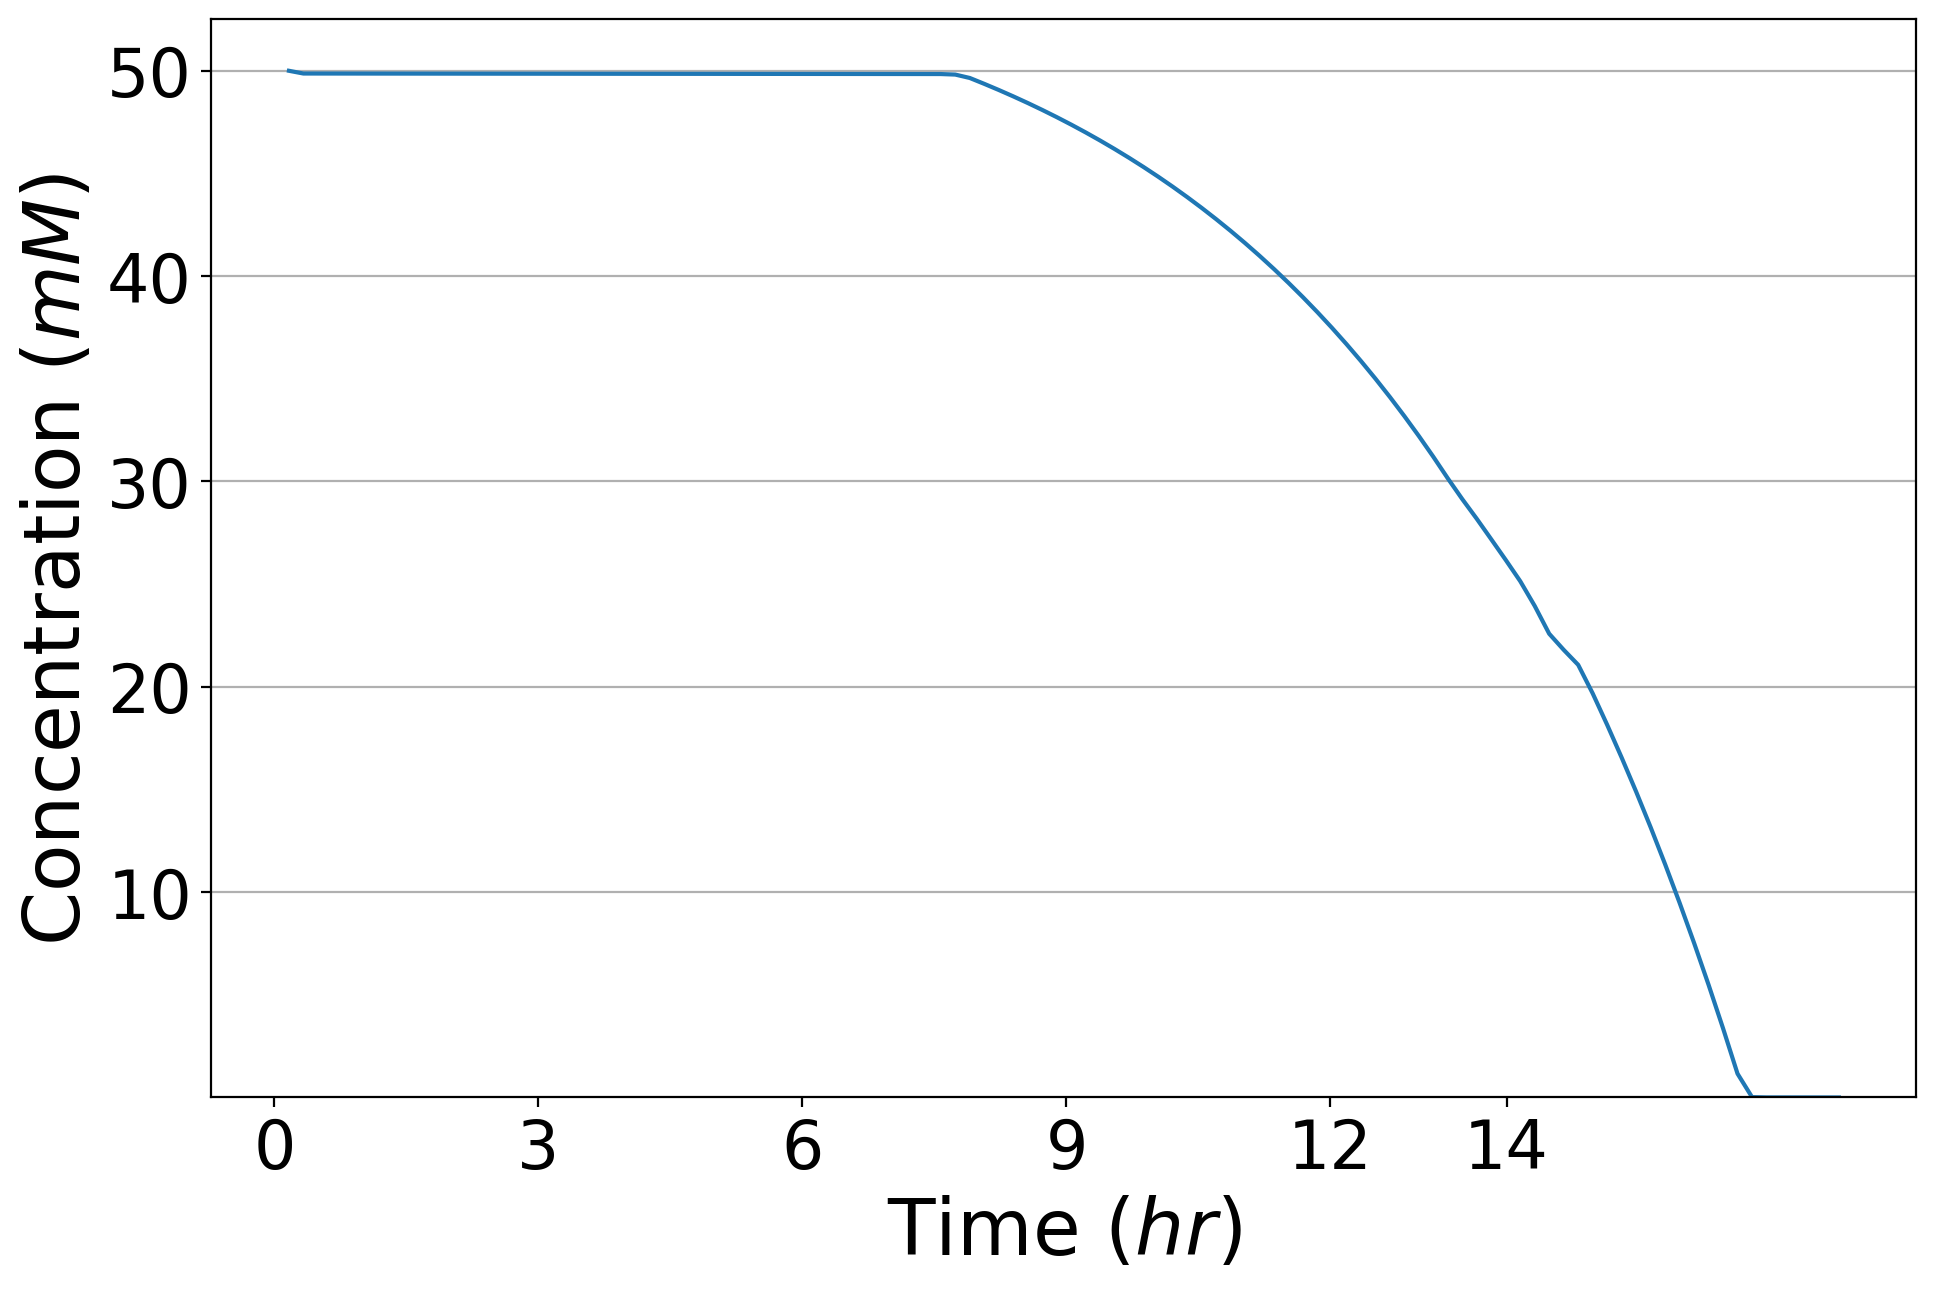

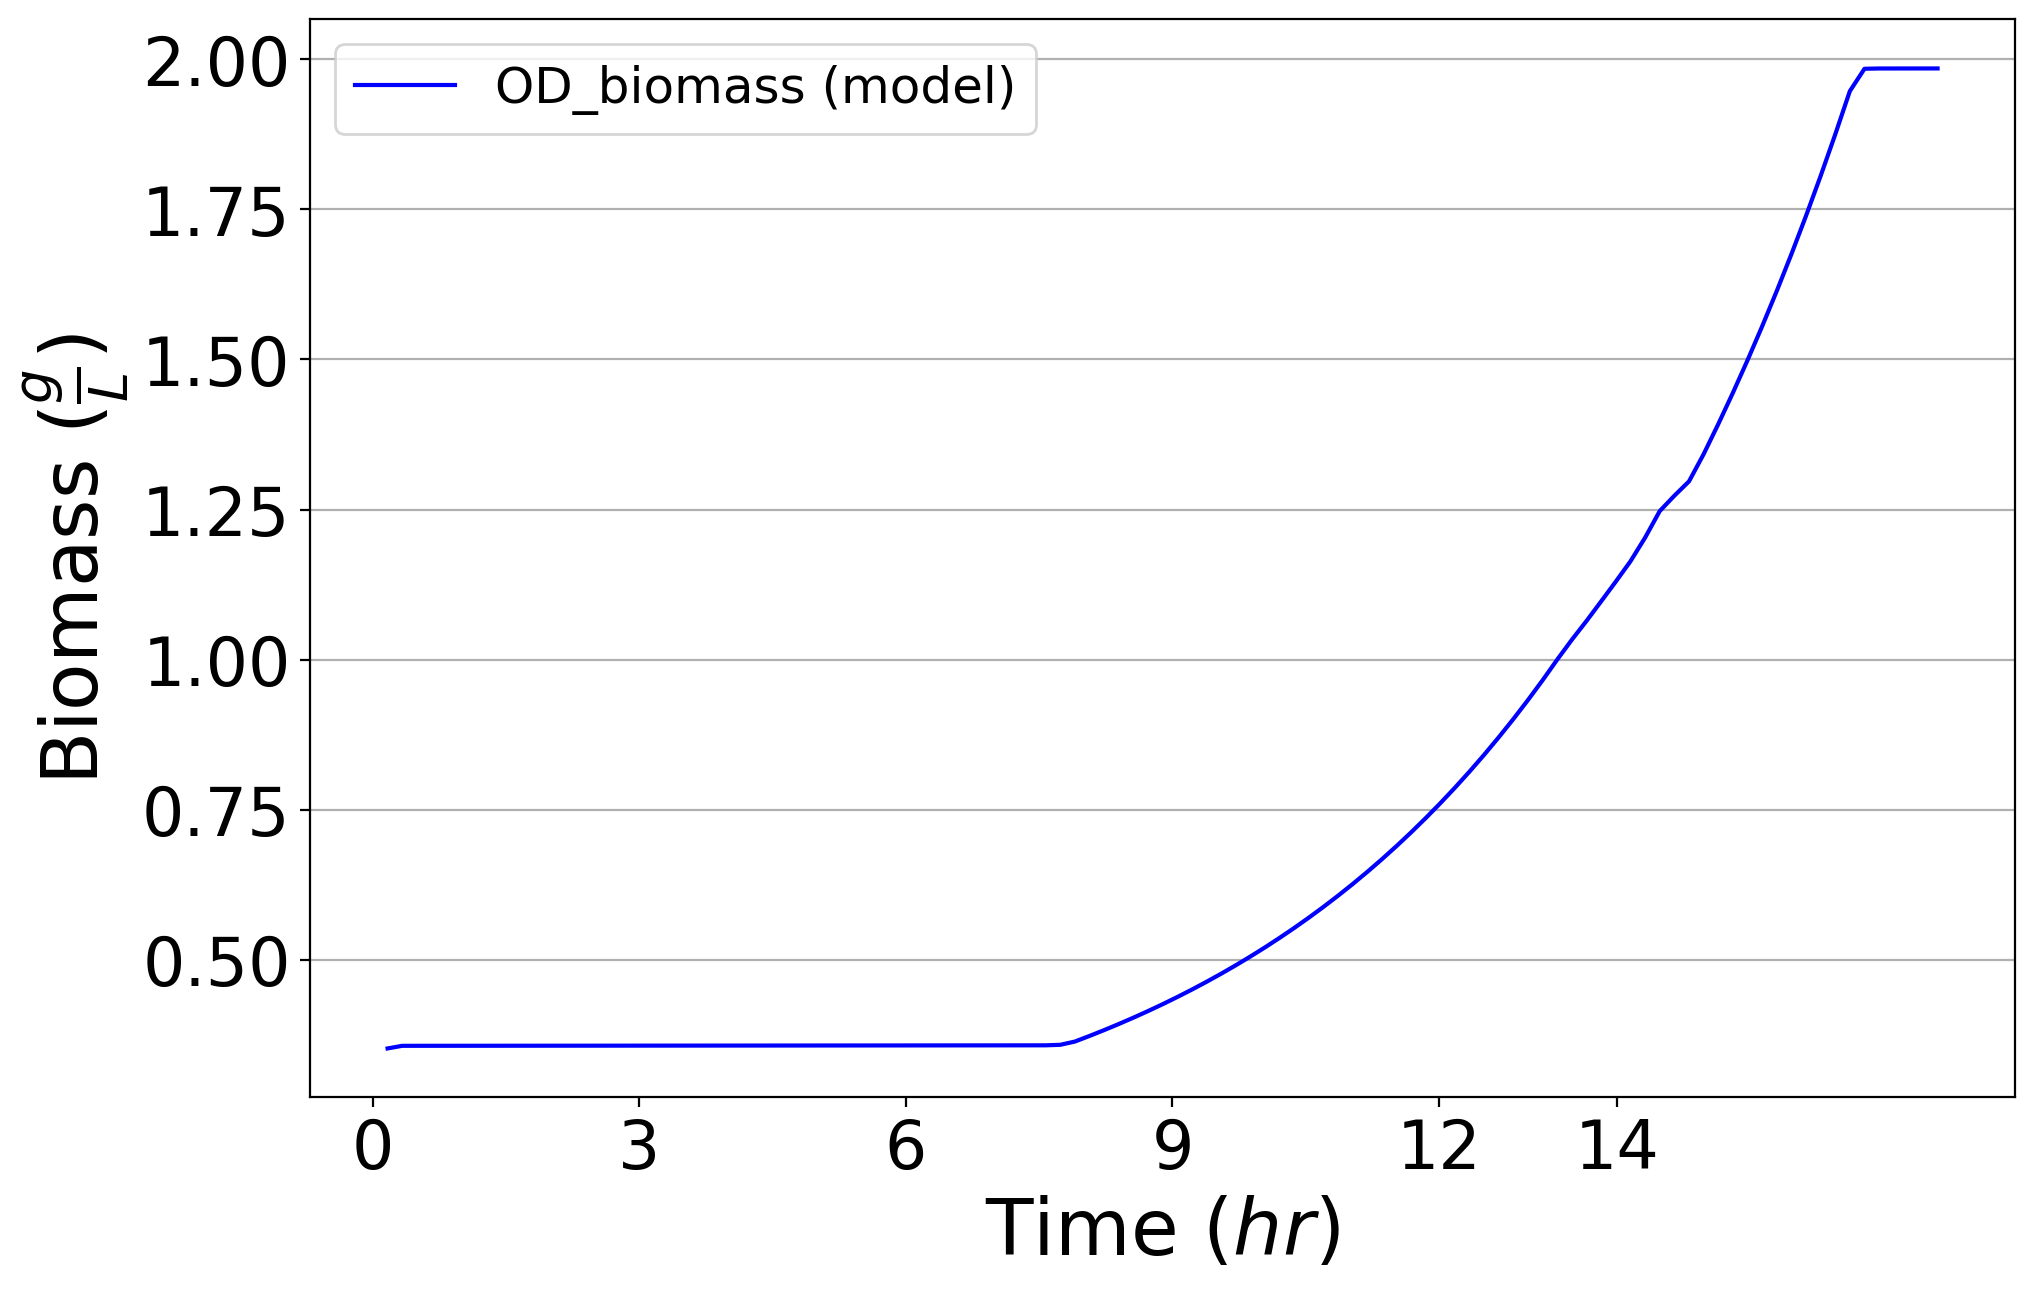

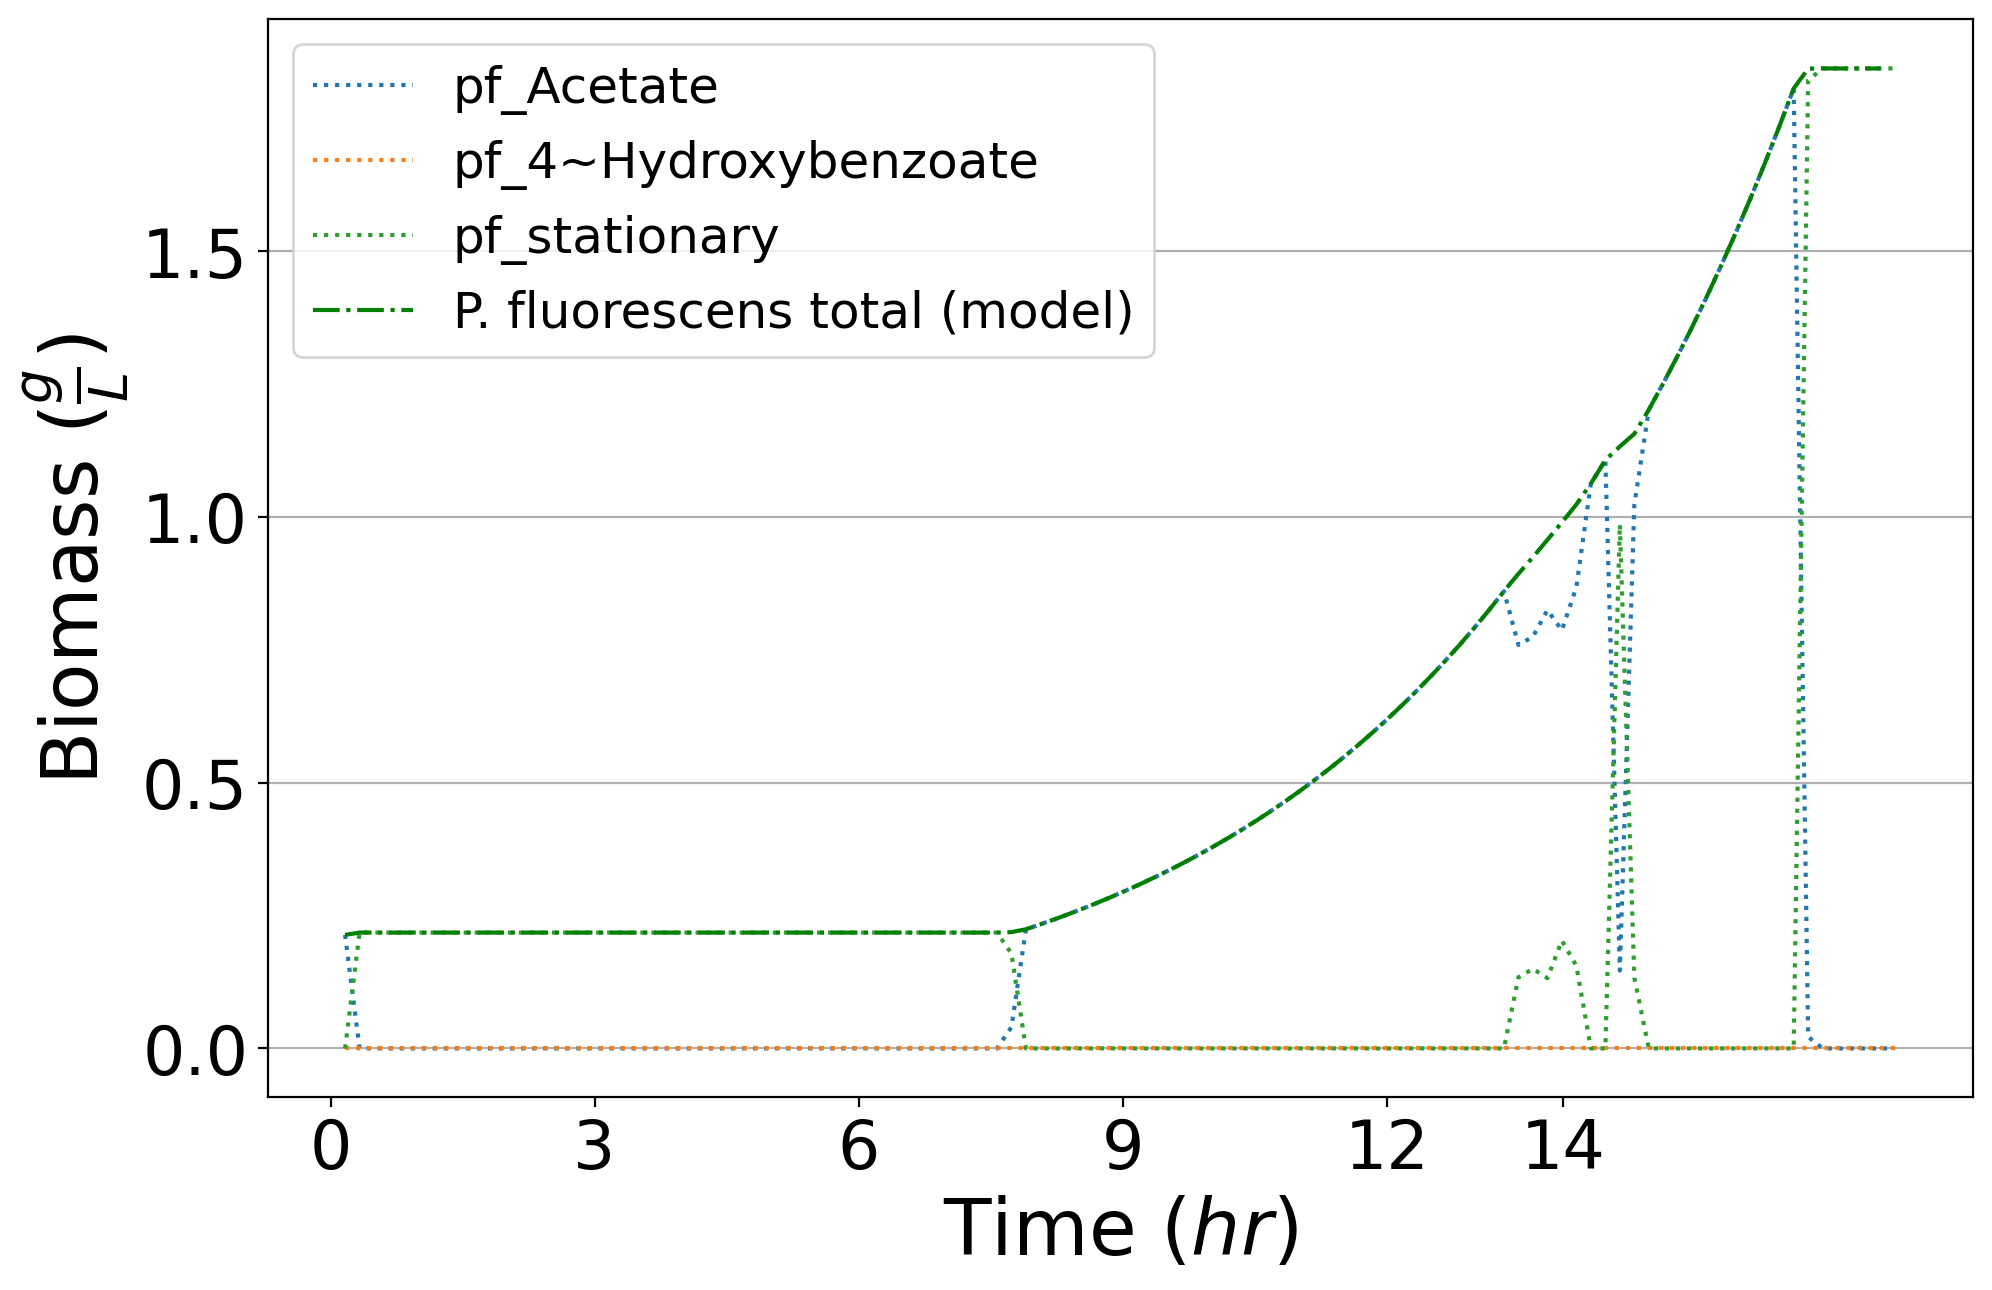

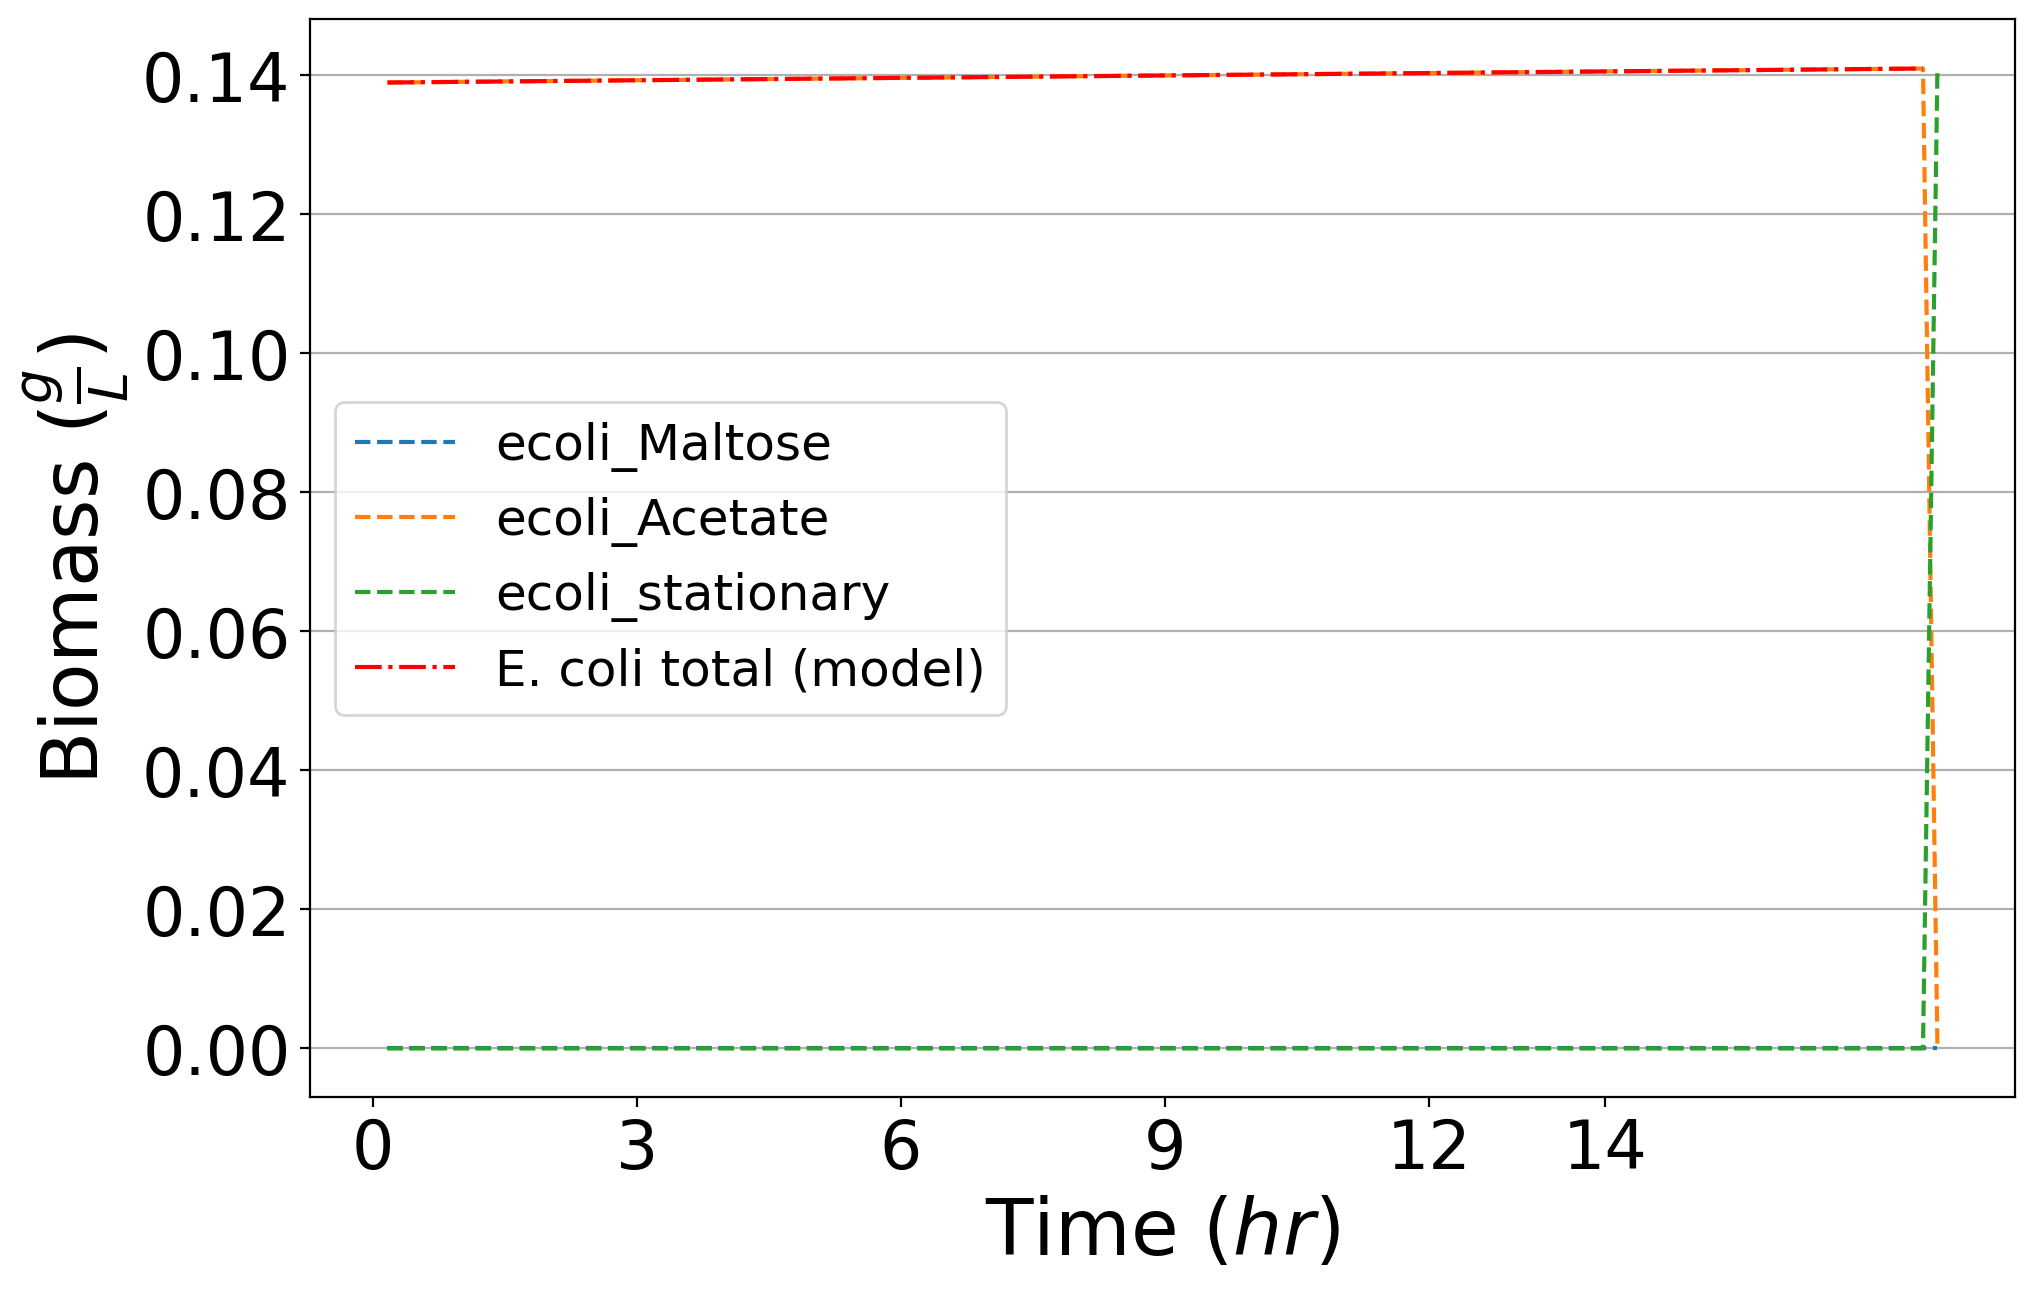

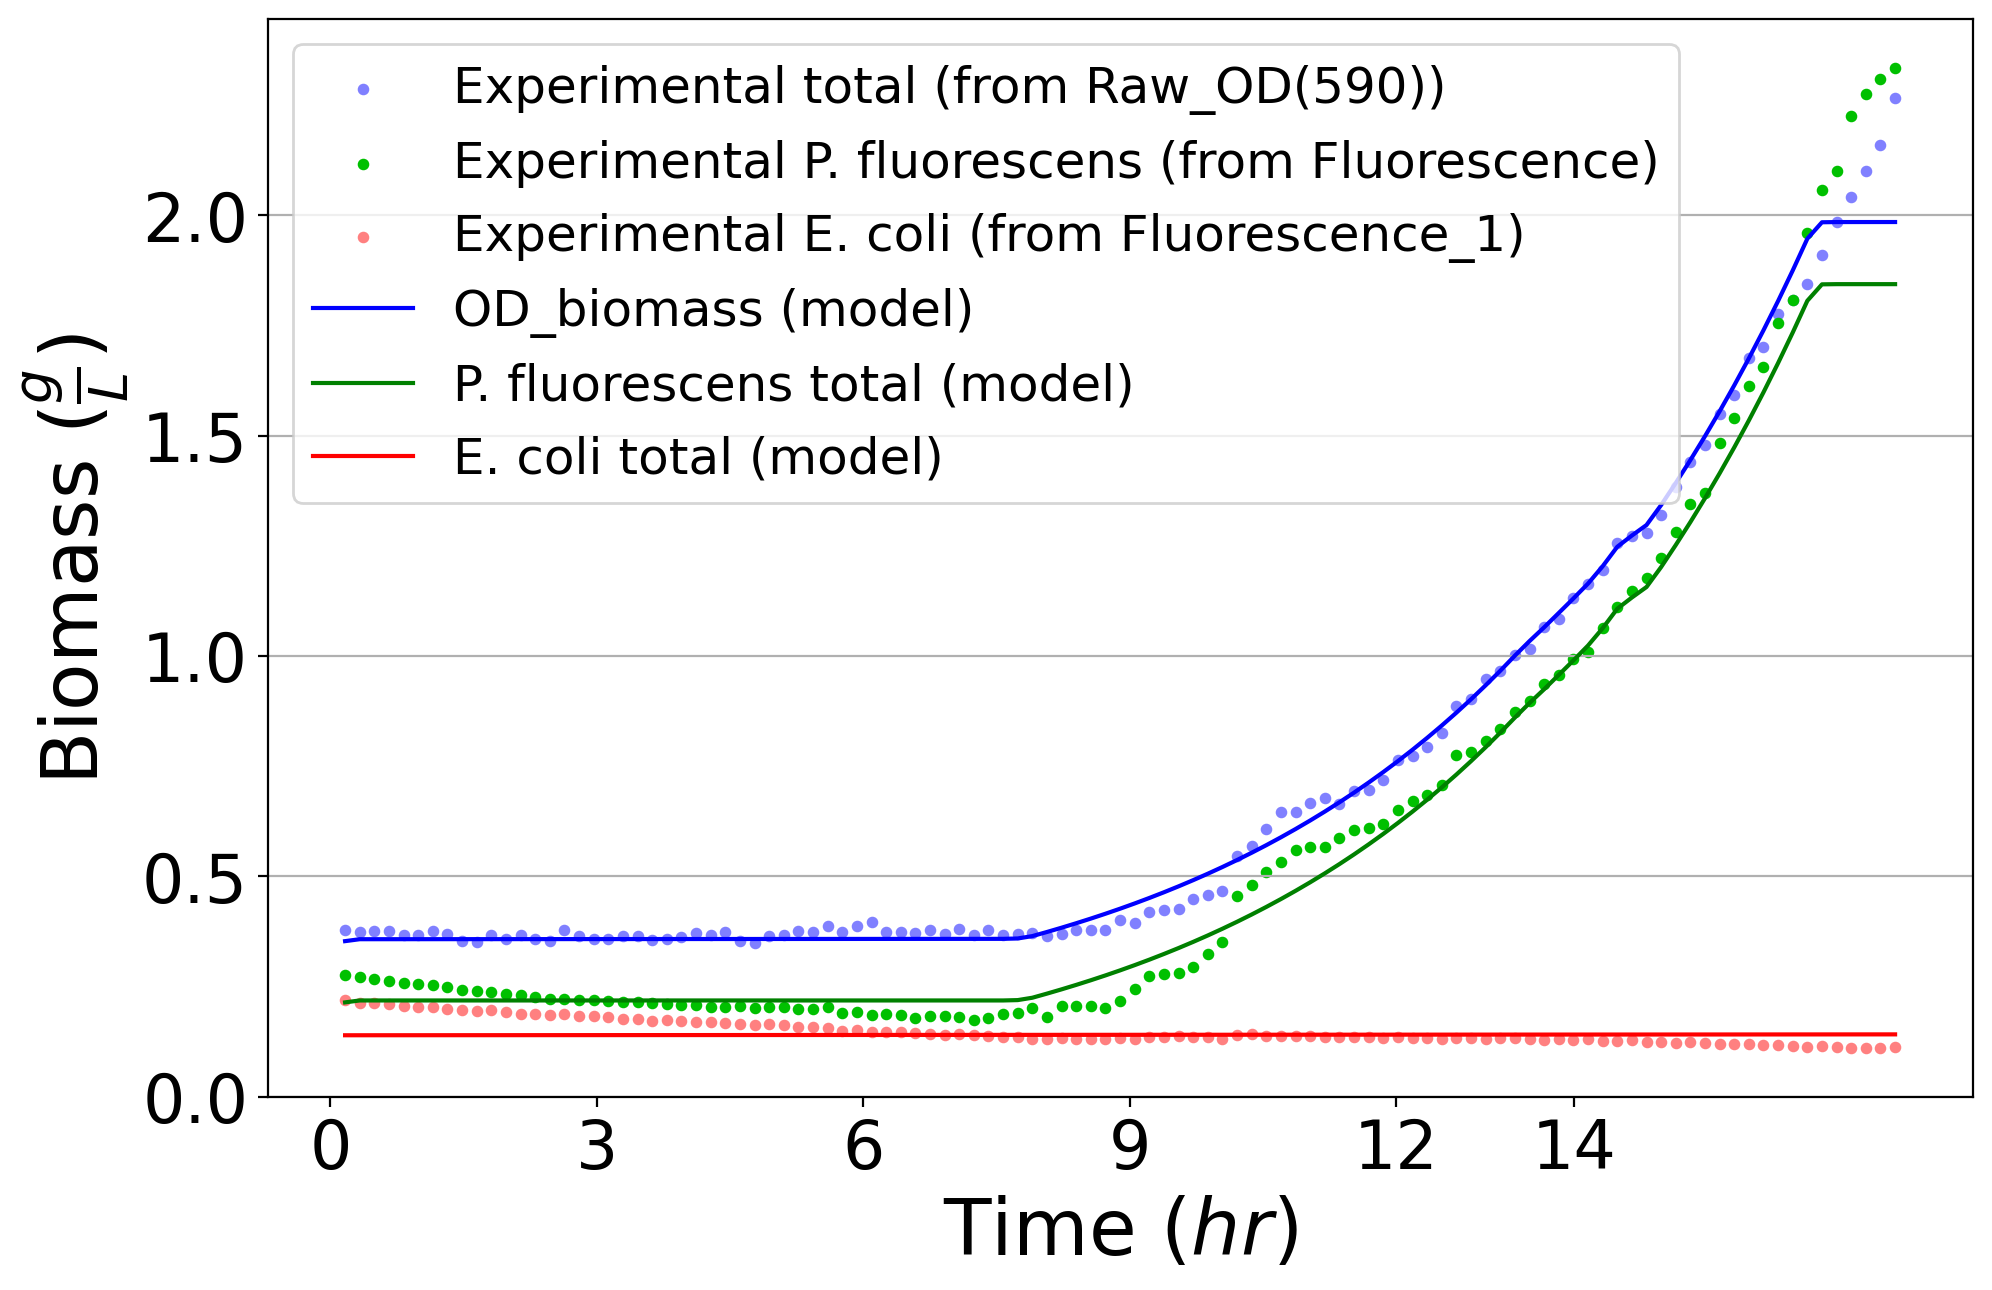

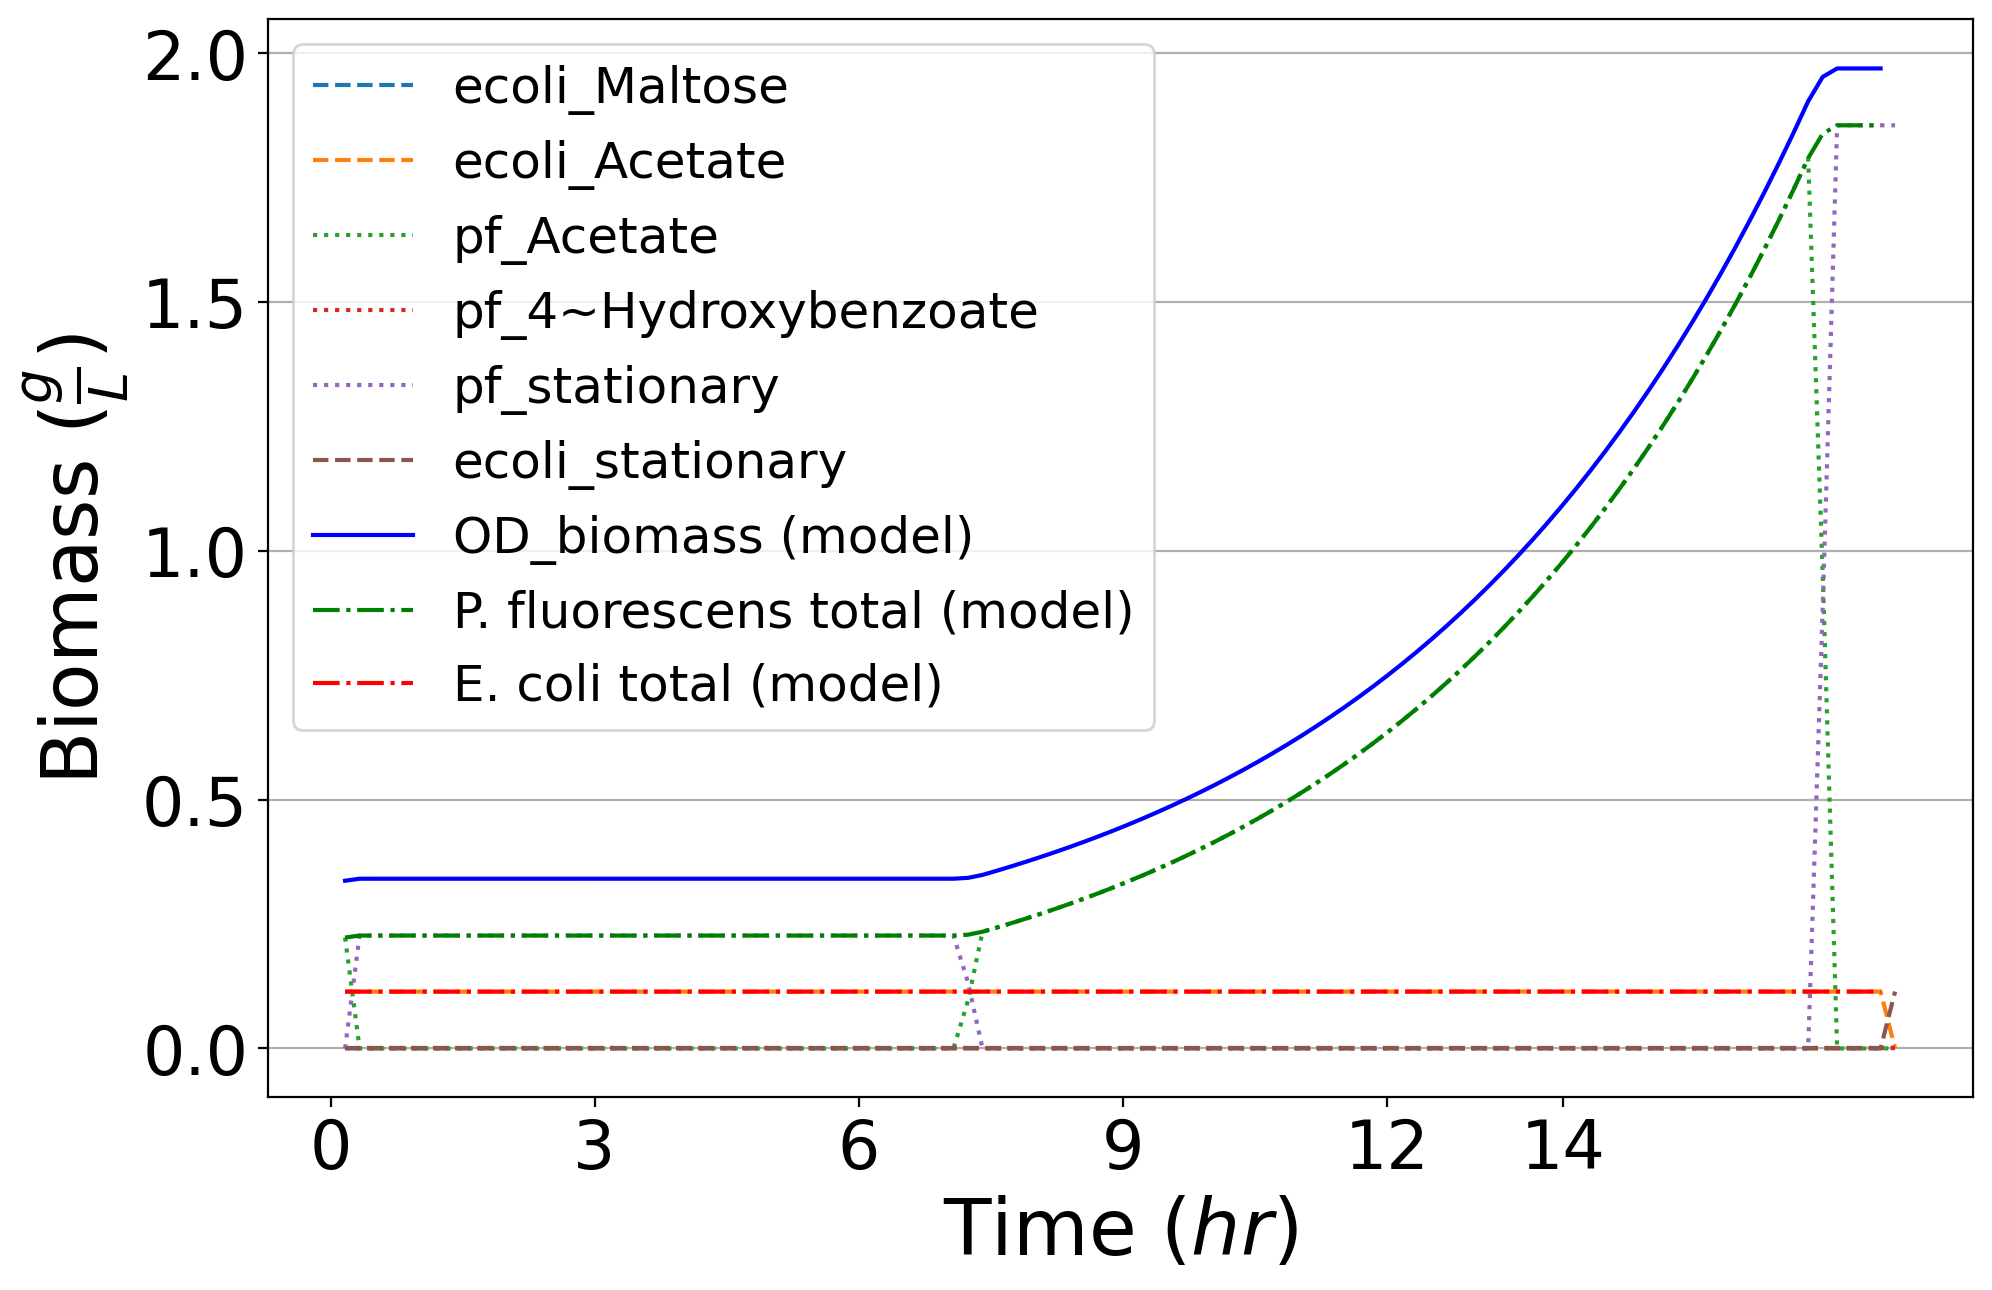

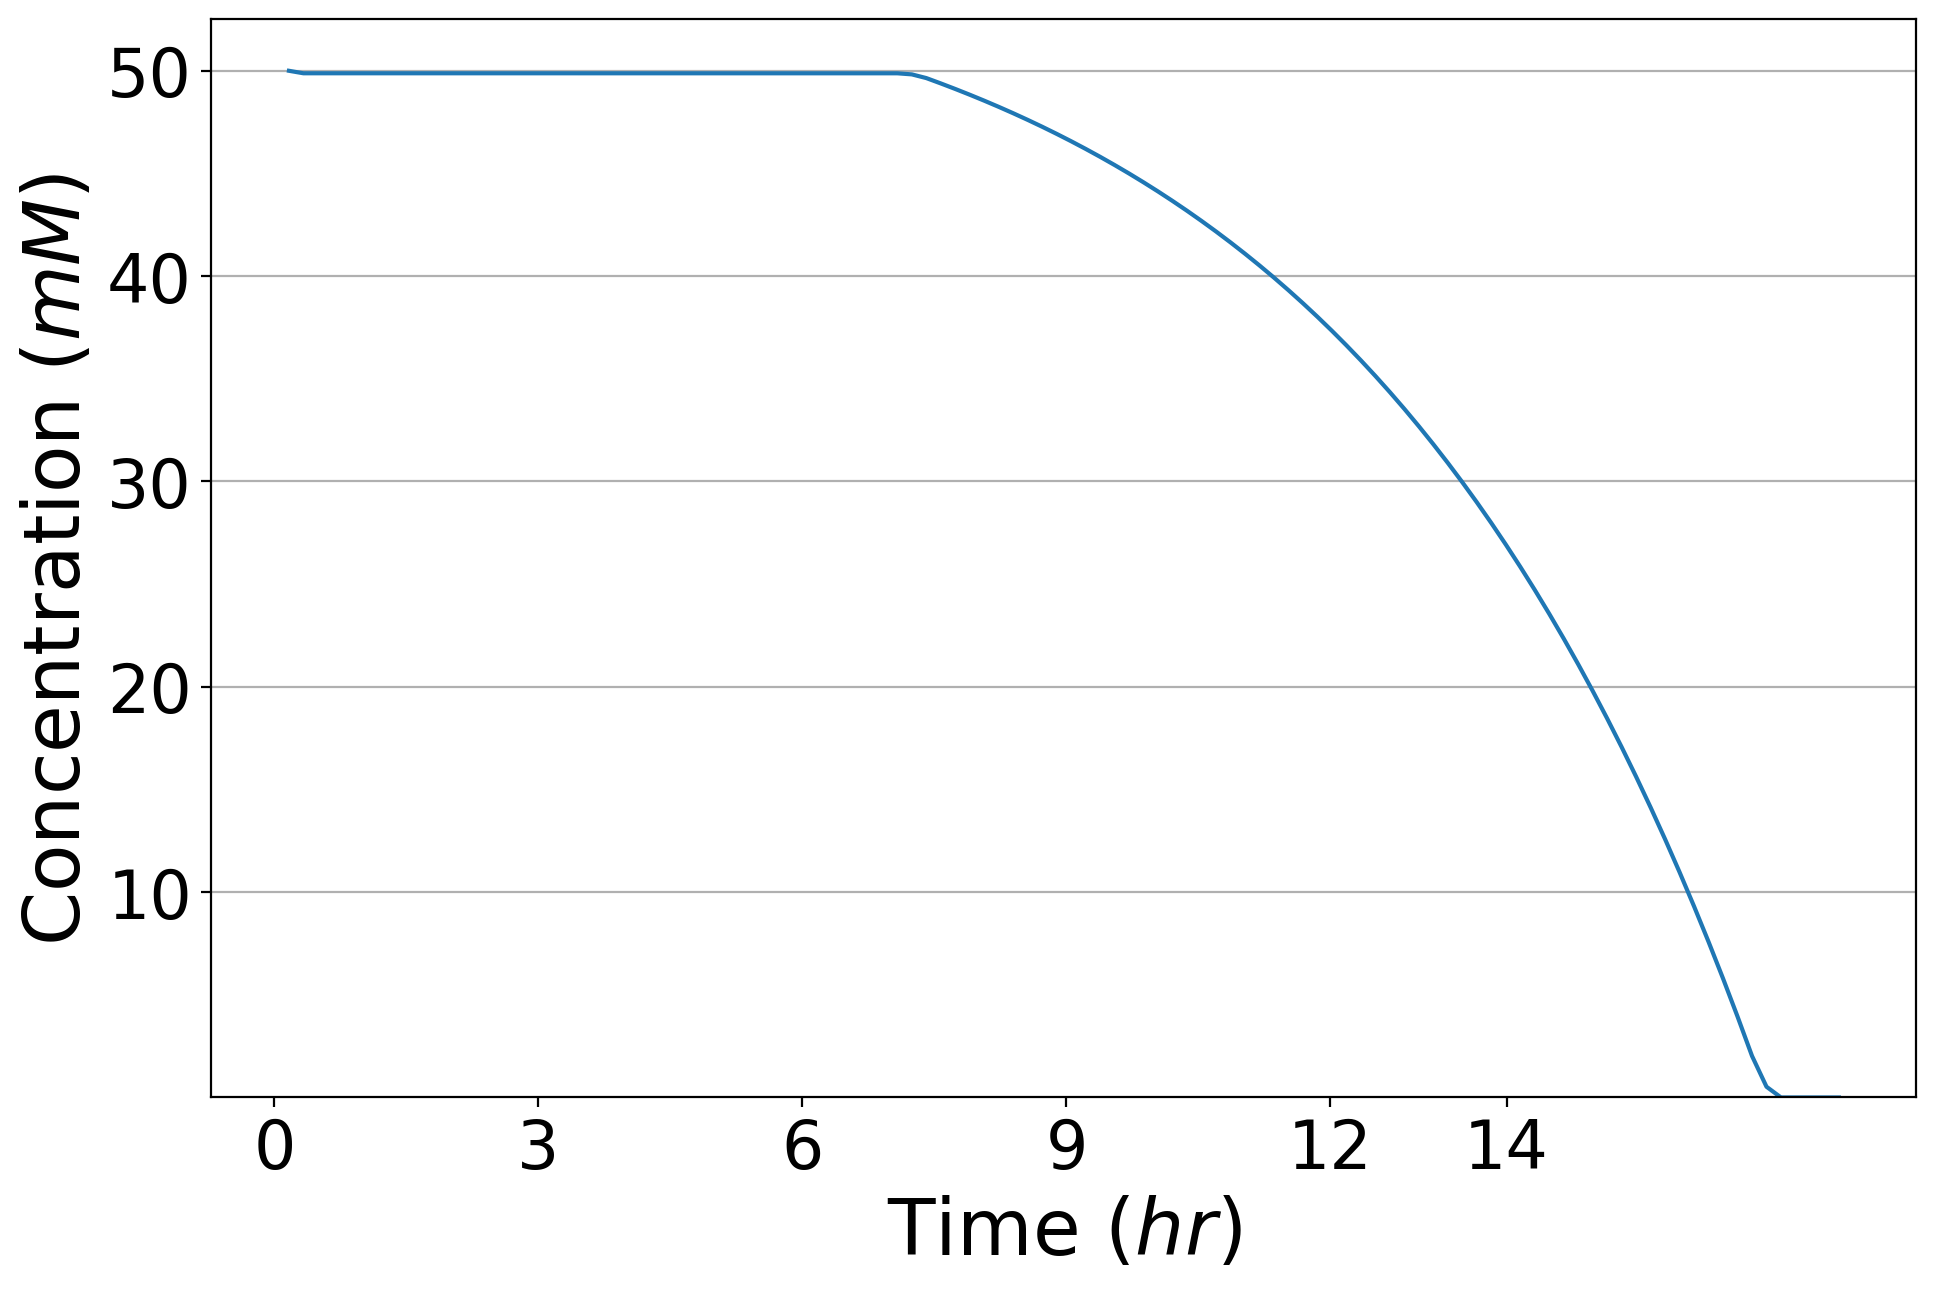

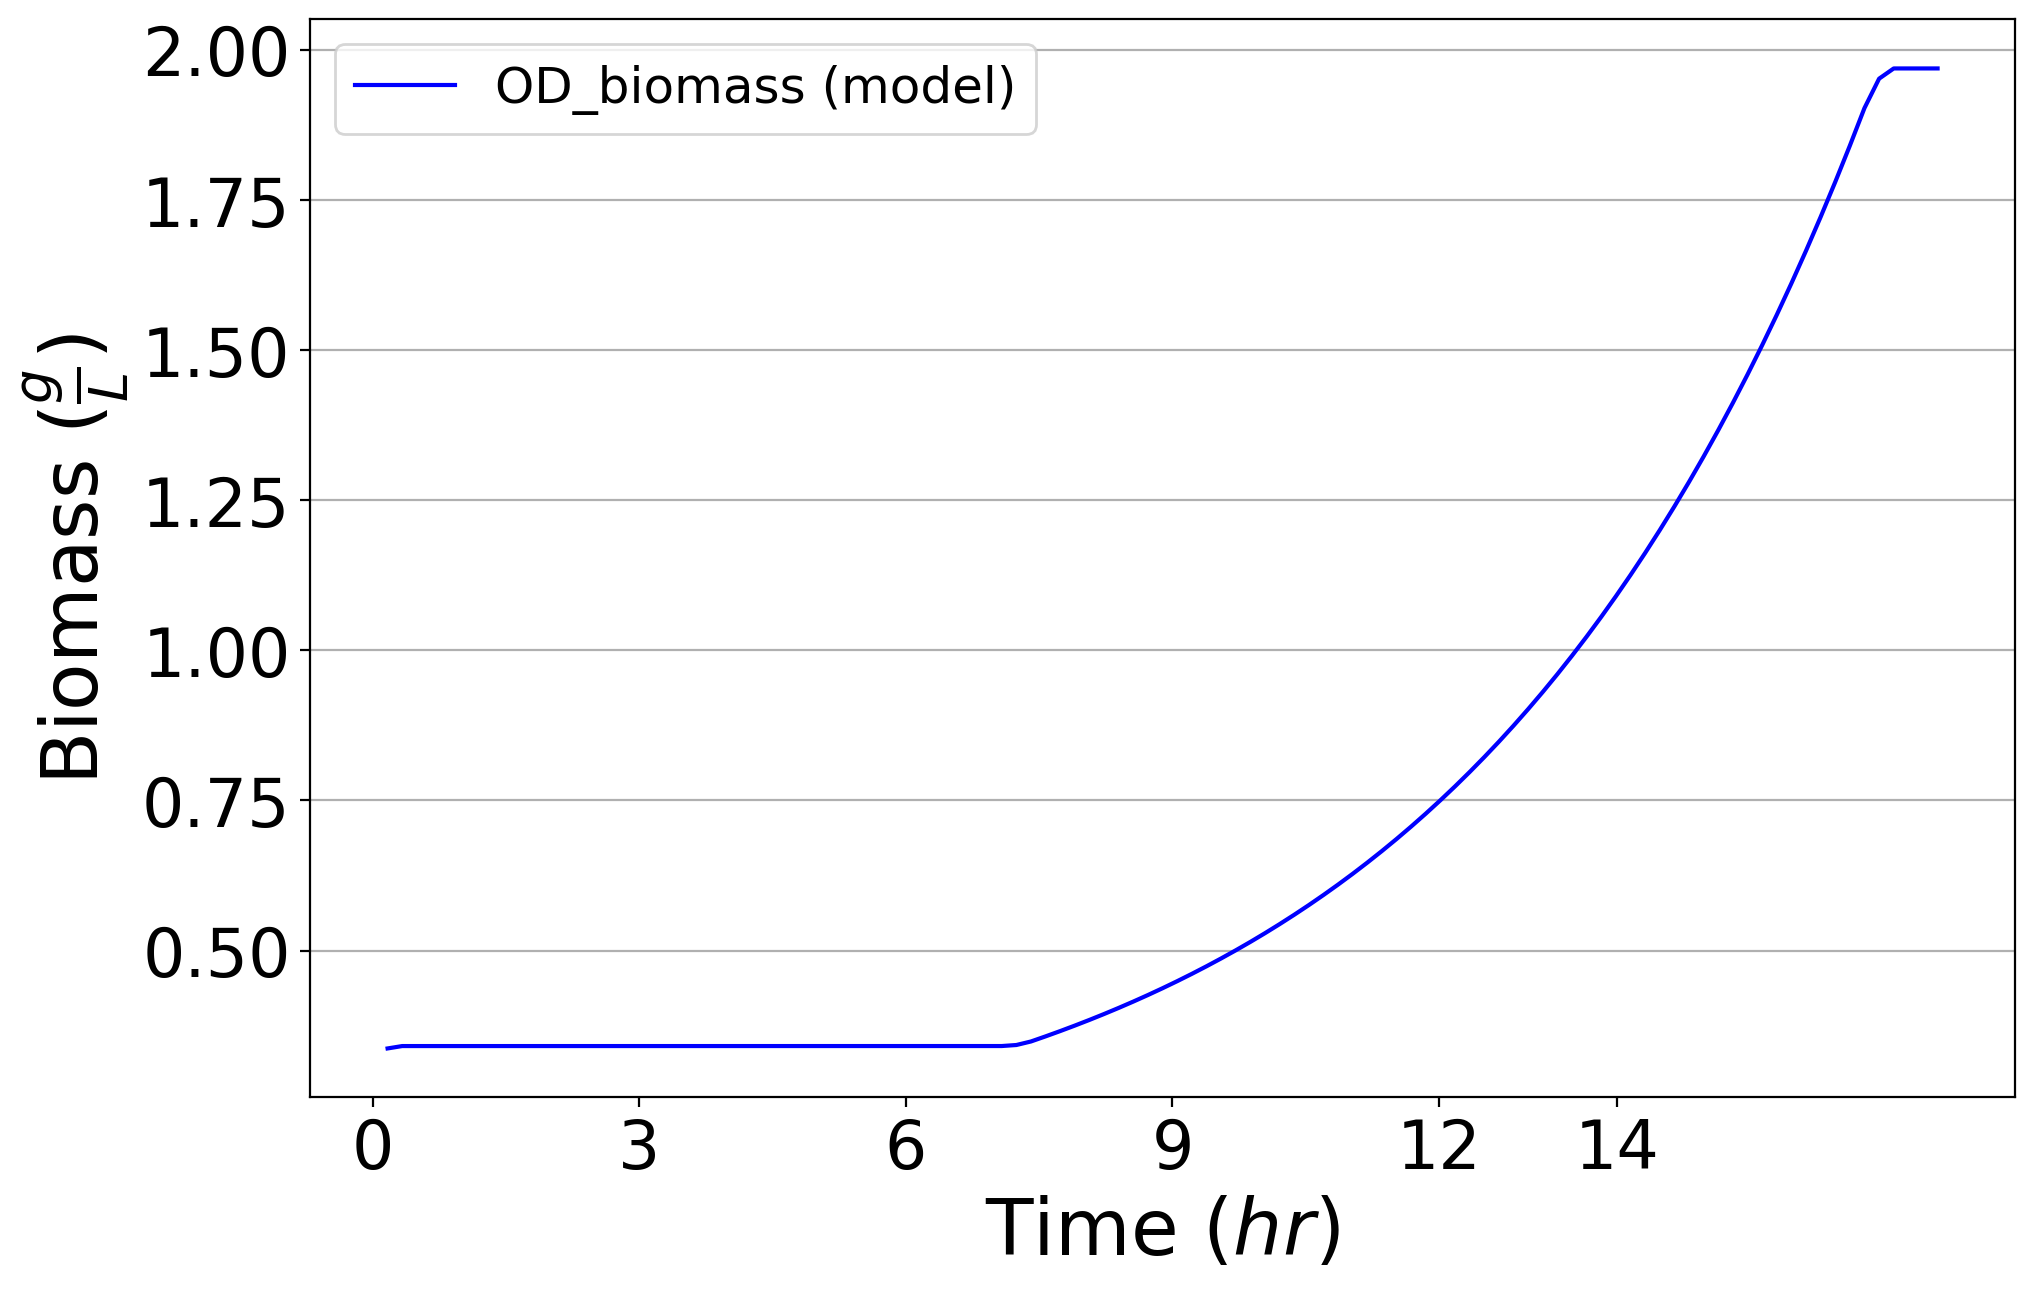

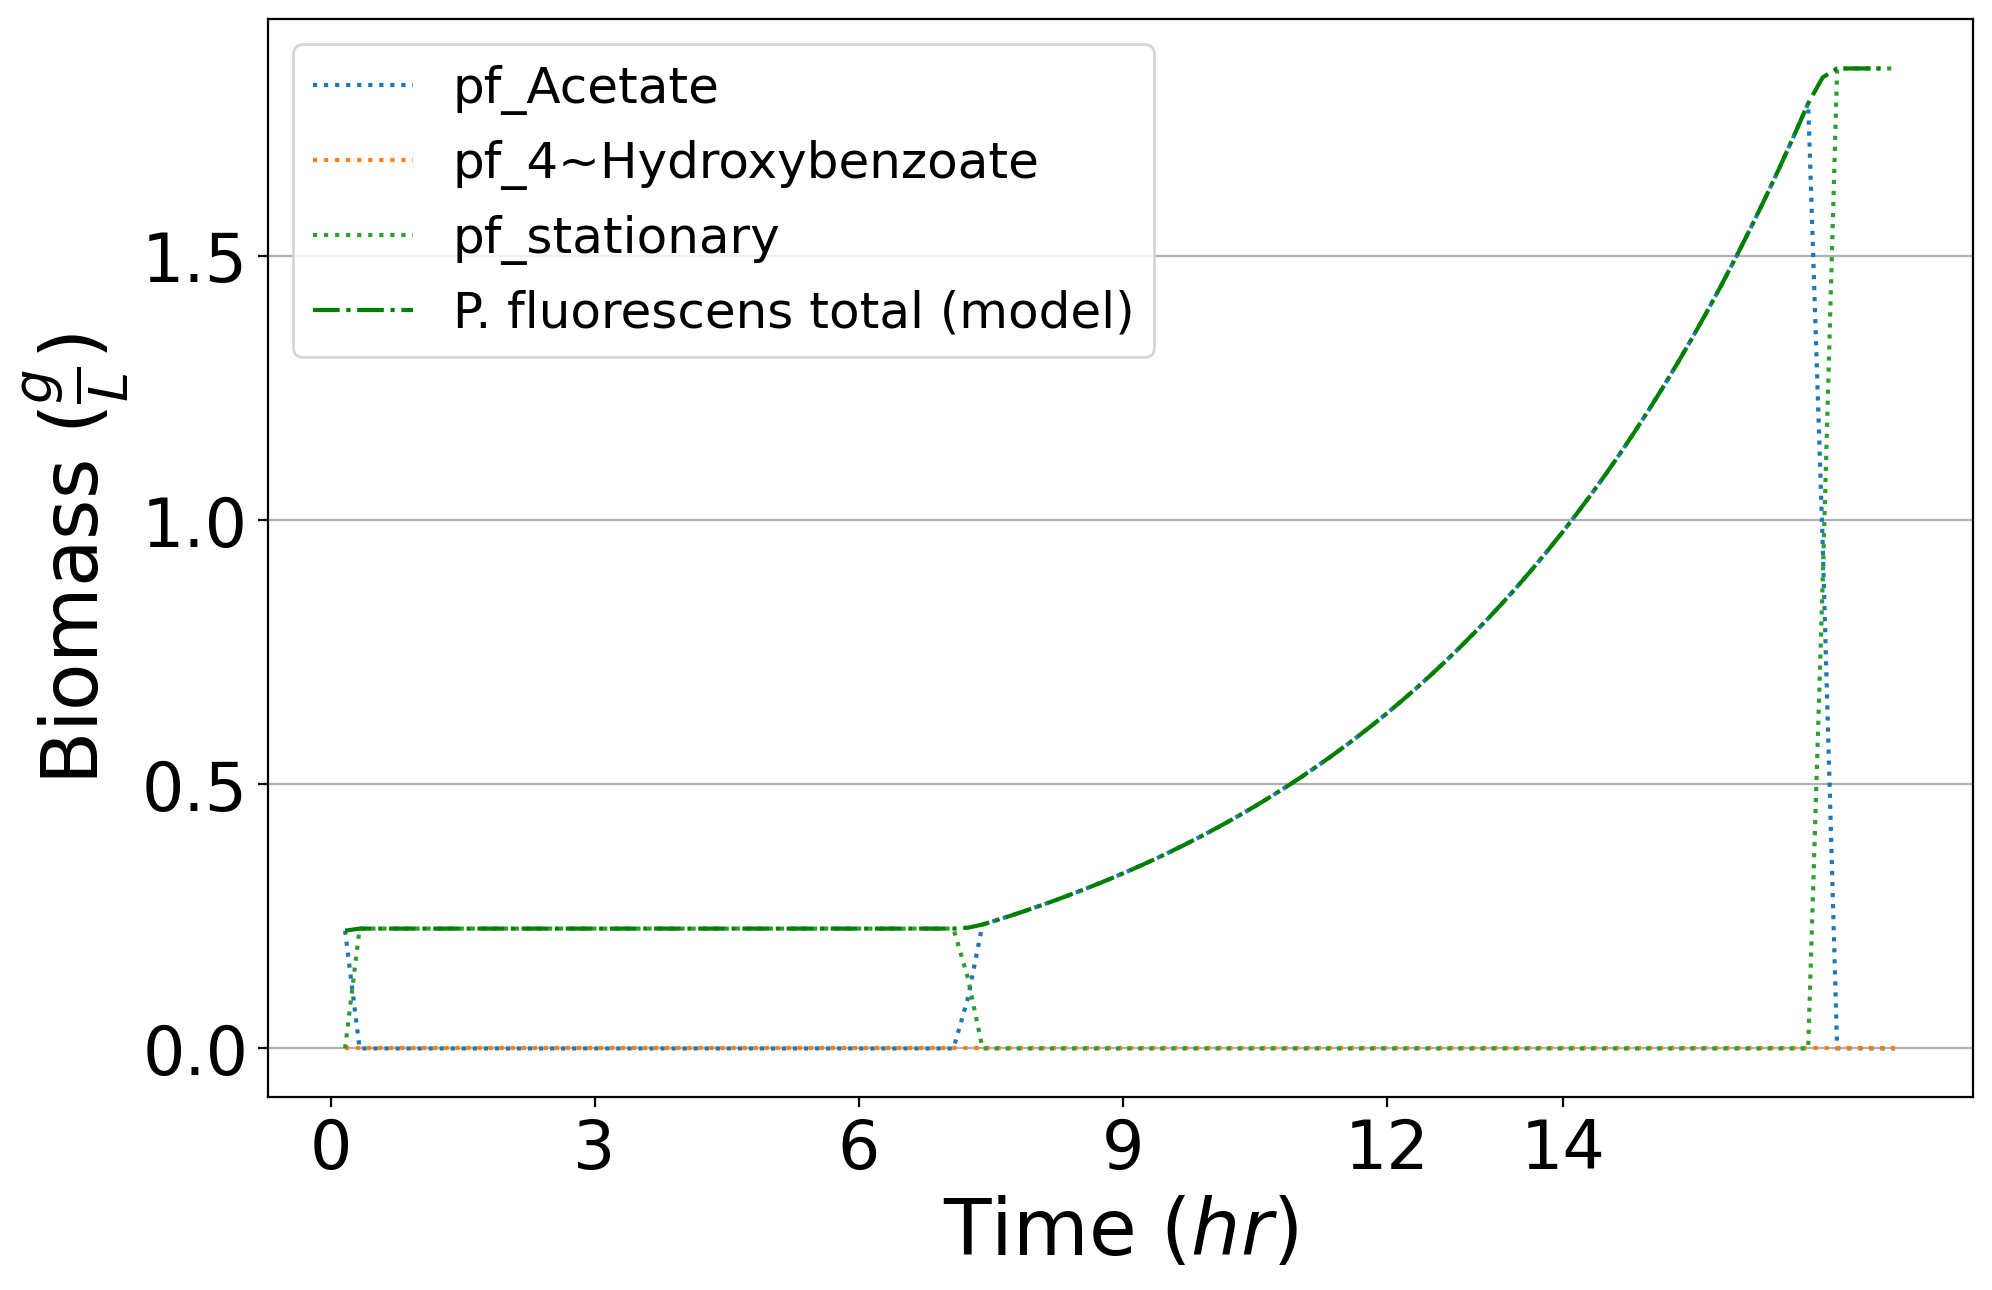

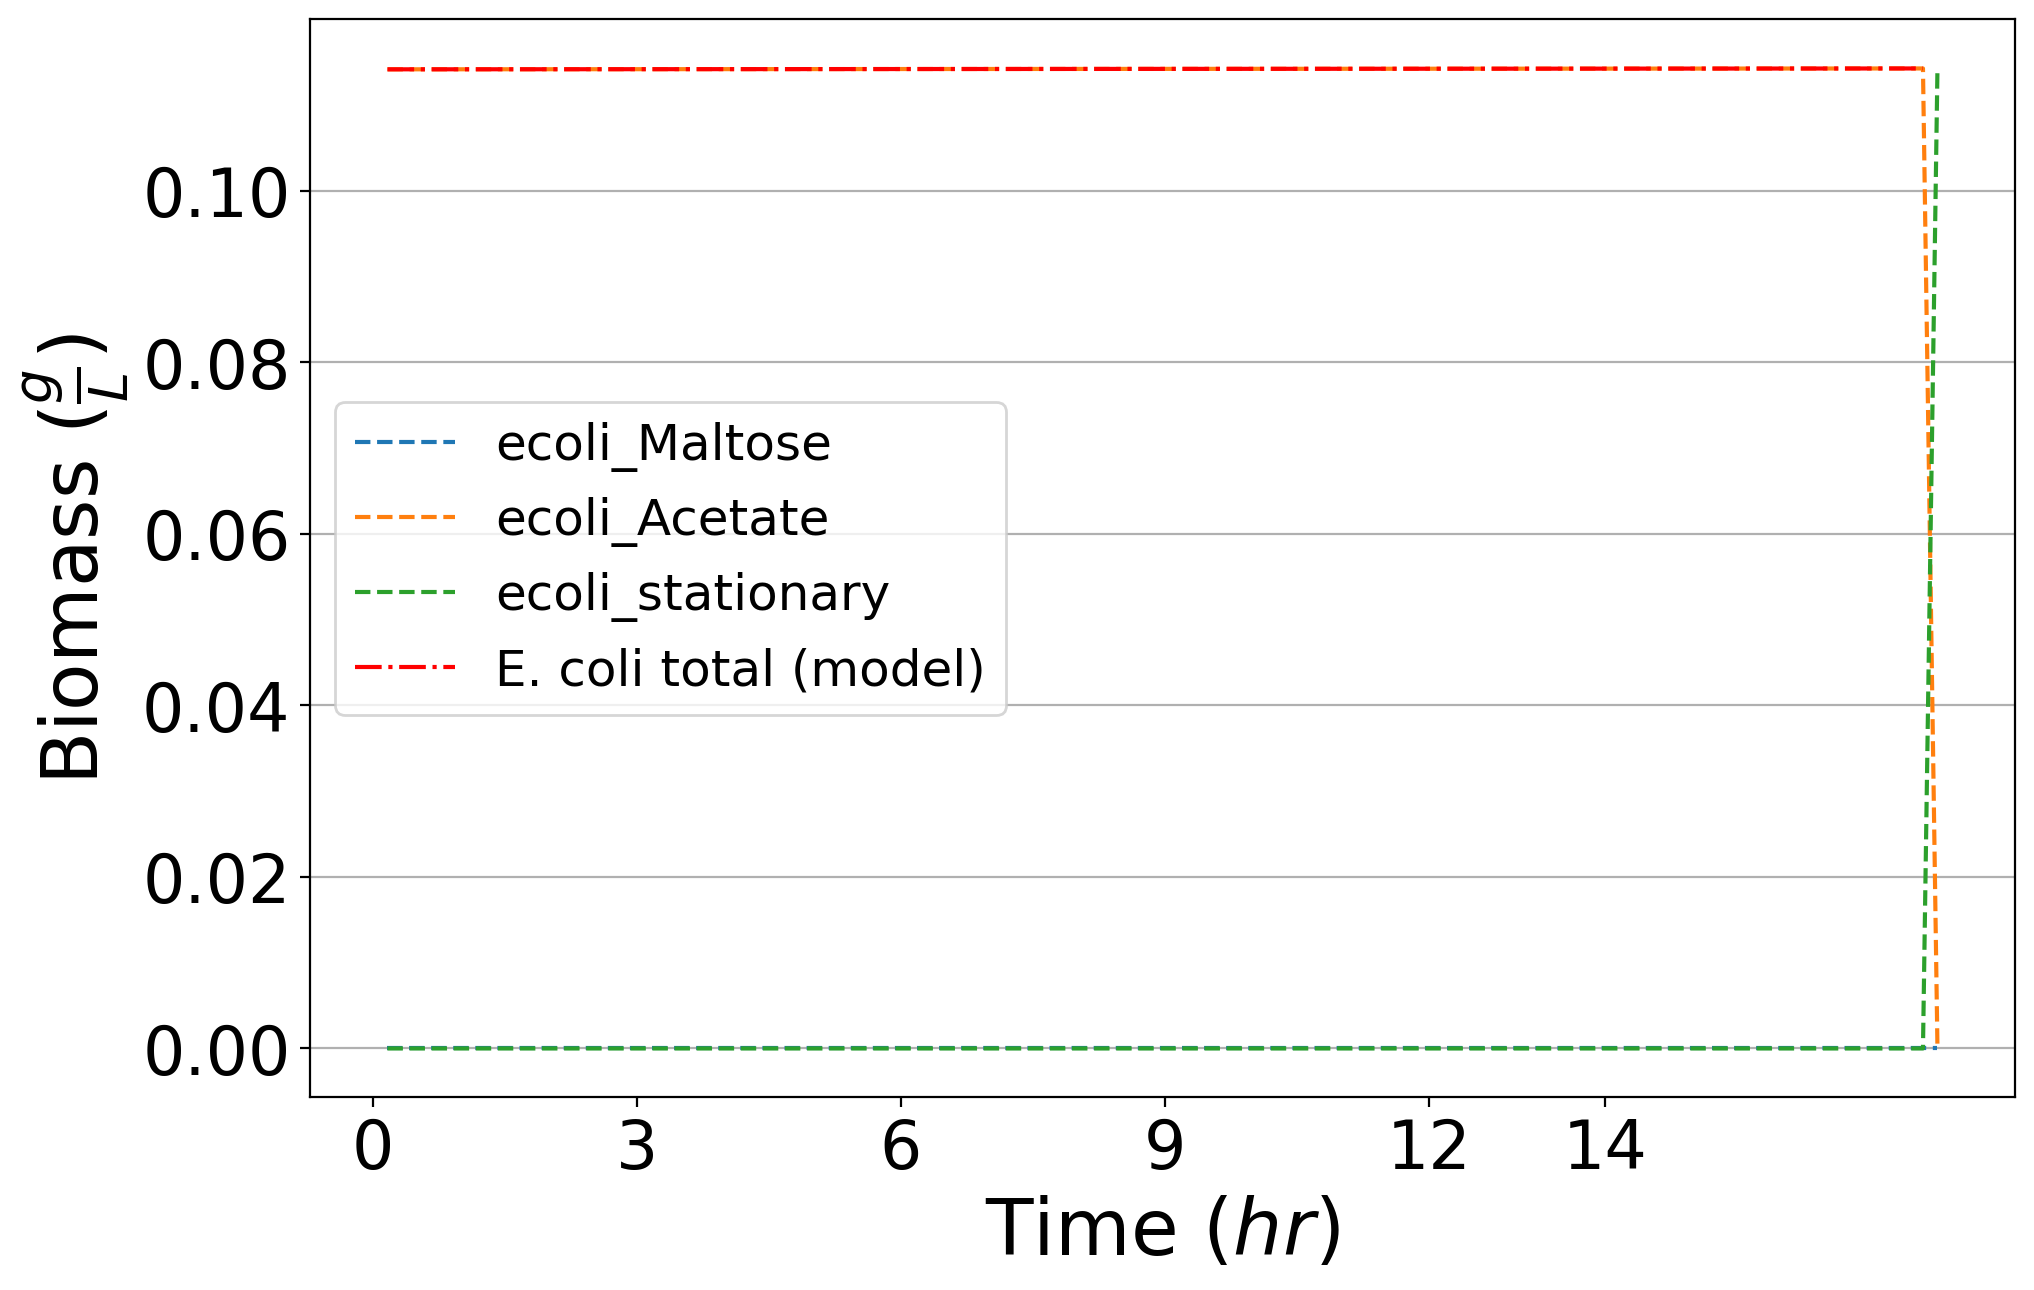

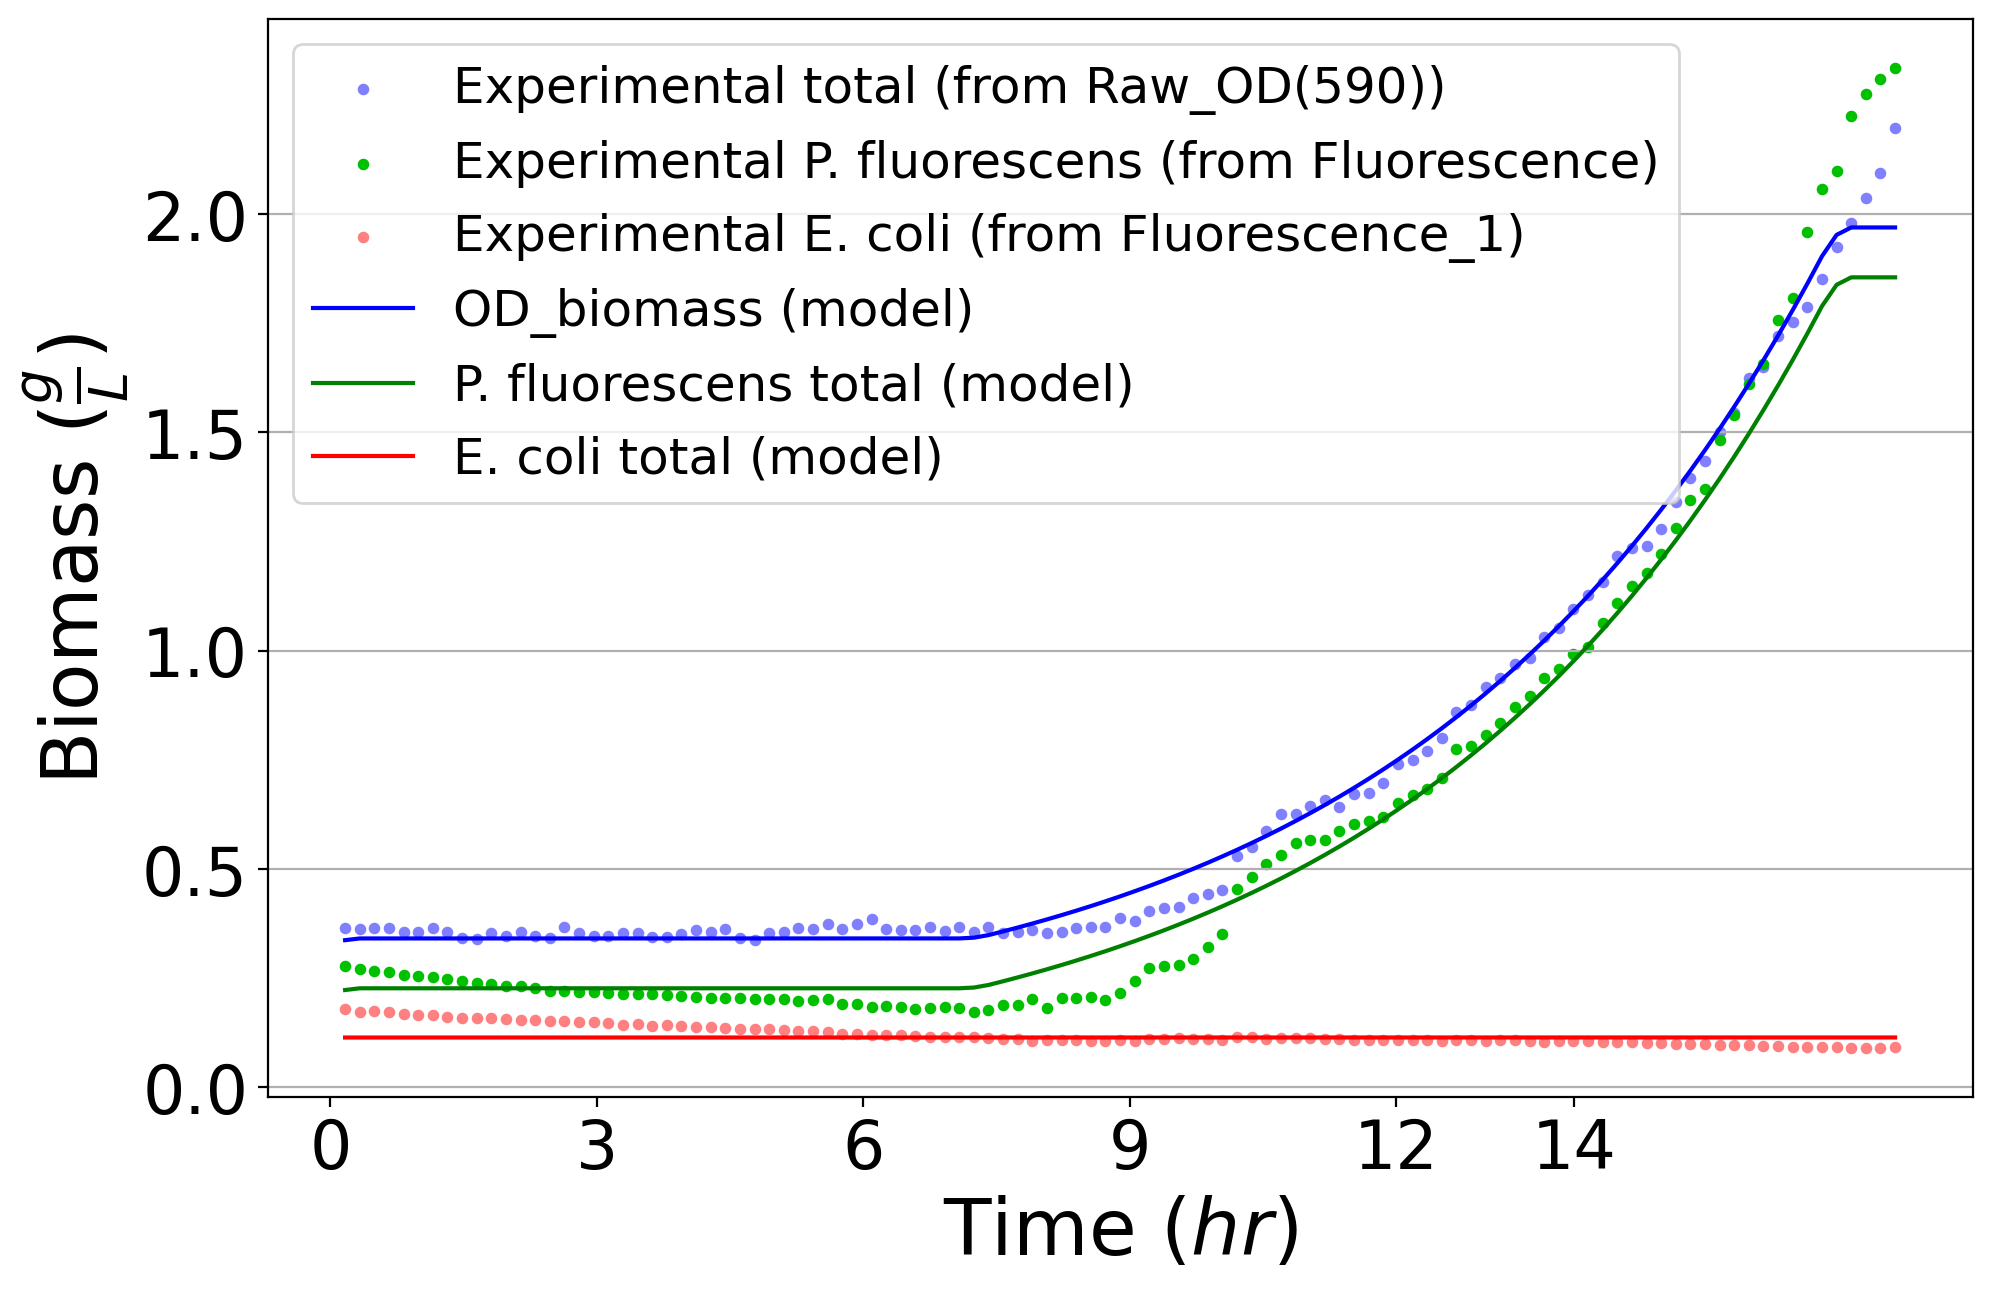

In [21]:
%%time

%run ../../../../ModelSEED/ModelSEEDpy/modelseedpy/community/mscommphitting.py

def _partition_coefs(initial_val, divisor):
    return (initial_val, initial_val/divisor, initial_val/divisor**2, initial_val/divisor**3, initial_val/divisor**4)

test_com = MSCommPhitting('../../../../ModelSEED/ModelSEEDDatabase',
                           community_members = {
                                ecoli: {
                                    'name': 'ecoli', 
                                    'phenotypes': {
                                        'Maltose': {"consumed":["cpd00179"],
                                                 "excreted":["cpd00029"]}, #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                                        'Acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                                        }
                                },
                                pf: {
                                    'name': 'pf',
                                    'phenotypes': {
                                        'Acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                                        '4-Hydroxybenzoate': {"consumed":["cpd00136"]}, # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                                        # 'Glycerol': {"consumed":["cpd00100"],
                                        #          "excreted":["cpd00266"]}, #kbase_api.get_from_ws('93465/13/1'), 
                                        }
                                }
                            },
                            data_paths = {'path':"../data/Jeffs_data/PF-EC-PFEC on Acetate 6-17-22.xlsx", 'Raw OD(590)':'OD', 'Fluorescence':'pf', 'Fluorescence 1':'ecoli'},
                            species_abundances = {num:{"ecoli":1, "pf":1} for num in range(1,13)},
                            carbon_conc = {'columns': {'cpd00029': {2:100, 3: 50, 4: 25, 5: 12.5, 6: 6.25, 7: 3}}},
                            ignore_trials = {'rows': ['C', 'D', 'B', 'F'], 'columns': [1,2,4,5,6,7,8,9,10,11,12]},
                            species_identities_rows = {
                                1:{"ecoli":"mRuby"},
                                2:{"ecoli":"ACS"},
                                3:{"pf":""},
                                4:{"ecoli":"mRuby"},
                                5:{"ecoli":"ACS"},
                            },
                            significant_deviation=None)

test_com.fit_kcat(parameters = {'cvmin': 1e3, 'bcv': 1e3, "stationary": 5e-1},
                  abs_final_conc = {"cpd00029":0}, # metabolomics data
                  graphs=update_graphs("G38"),
                  zero_start = ["cpd00136", "cpd00179"],   # necessary to prevent the growth of these phenotypes 
                  export_zip_name = 'acetate_co.zip',
                  export_lp = "acetate_co.lp",
                  primals_export_path="acetate_co_primals.json")

In [ ]:
%run ../data/standardized_data/datastandardization.py
growth_data_path="../data/Jeffs_data/PF-EC-PFEC on Acetate 6-17-22.xlsx"
time1 = process_time()
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        ecoli: {
            'name': 'ecoli', 
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                'malt': {"consumed":["cpd00179"],
                         "excreted":["cpd00029"]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                }
        },
        pf: {
            'name': 'pf',
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                '4HB': {"consumed":["cpd00136"]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'Fluorescence':'pf', 'Fluorescence 1':'ecoli'},
    species_abundances = {num:{"ecoli":1, "pf":1} for num in range(1,13)},
    carbon_conc_series = {'columns': {'cpd00029': {2:100, 3: 50, 4: 25, 5: 12.5, 6: 6.25, 7: 3}}},
    ignore_trials = {'rows': ['C', 'D', 'B', 'F'], 'columns': [1,2,4,5,6,7,8,9,10,11,12]},
    species_identities_rows = {
        1:{"ecoli":"mRuby"},
        2:{"ecoli":"ACS"},
        3:{"pf":""},
        4:{"ecoli":"mRuby"},
        5:{"ecoli":"ACS"},
    },
    significant_deviation=None
)
print(f"{(process_time()-time1)/60} minutes")

In [ ]:
%run ../mscommphitting.py

acetate_commfit = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
acetate_commfit.fit_kcat(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
    mets_to_track = ["cpd00029"],
    rel_final_conc = {"cpd00029":0.0001},
    zero_start = ["cpd00136", "cpd00179"],
    graphs = update_graphs("G38"),
    export_zip_name = 'acetate_commfit.zip', 
    requisite_biomass = requisite_biomass,
    publishing = True,
    export_lp = "acetate_coculture.lp")

#### Pseudomonas

In [ ]:
%run ../data/standardized_data/datastandardization.py
growth_data_path="../data/Jeffs_data/PF-EC-PFEC on Acetate 6-17-22.xlsx"
time1 = process_time()
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        pf: {
            'name': 'pf',
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                '4HB': {"consumed":["cpd00136"]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'Fluorescence':'pf'},
    species_abundances = {num:{"ecoli":1, "pf":1} for num in range(1,13)},
    carbon_conc_series = {'columns': {'cpd00029': {2:100, 3: 50, 4: 25, 5: 12.5, 6: 6.25, 7: 3}}},
    ignore_trials = {'rows': ['C', 'E', 'B', 'F'], 'columns': [1,2,4,5,6,7,8,9,10,11,12]},
    species_identities_rows = {
        1:{"ecoli":"mRuby"},
        2:{"ecoli":"ACS"},
        3:{"pf":""},
        4:{"ecoli":"mRuby"},
        5:{"ecoli":"ACS"},
    },
    significant_deviation=None
)
print(f"{(process_time()-time1)/60} minutes")

In [ ]:
%run ../mscommphitting.py

acetate_pf = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
acetate_pf.fit_kcat(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
    mets_to_track = ["cpd00029"],
    rel_final_conc = {"cpd00029":0.0001},
    zero_start = ["cpd00136", "cpd00179"],
    graphs = update_graphs("G26"),
    export_zip_name = 'acetate_pf.zip', 
    requisite_biomass = requisite_biomass,
    publishing = True,
    export_lp = "acetate_pf.lp")

#### E. coli

In [ ]:
%run ../data/standardized_data/datastandardization.py
growth_data_path="../data/Jeffs_data/PF-EC-PFEC on Acetate 6-17-22.xlsx"
time1 = process_time()
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        ecoli: {
            'name': 'ecoli', 
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                'malt': {"consumed":["cpd00179"],
                         "excreted":["cpd00029"]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD','Fluorescence 1':'ecoli'},
    species_abundances = {num:{"ecoli":1, "pf":1} for num in range(1,13)},
    carbon_conc_series = {'columns': {'cpd00029': {2:100, 3: 50, 4: 25, 5: 12.5, 6: 6.25, 7: 3}}},
    ignore_trials = {'rows': ['C', 'E', 'D', 'F'], 'columns': [1,2,4,5,6,7,8,9,10,11,12]},
    species_identities_rows = {
        1:{"ecoli":"mRuby"},
        2:{"ecoli":"ACS"},
        3:{"pf":""},
        4:{"ecoli":"mRuby"},
        5:{"ecoli":"ACS"},
    },
    significant_deviation=None
)
print(f"{(process_time()-time1)/60} minutes")

In [ ]:
%run ../mscommphitting.py

acetate_ecoli = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, '../../../../ModelSEED/ModelSEEDDatabase', growth_df, experimental_metadata)
acetate_ecoli.fit_kcat(
    parameters = {'cvmin': .1, 'bcv': 0.0001, "stationary": 5e-3},
    mets_to_track = ["cpd00029"],
    rel_final_conc = {"cpd00029":0.00001},
    zero_start = ["cpd00136", "cpd00179"],
    graphs = update_graphs("G2"),
    export_zip_name = 'acetate_ecoli.zip', 
    requisite_biomass = requisite_biomass,
    publishing = True,
    export_lp = "acetate_ecoli.lp")

# SteadyCom

In [ ]:
# # import the models
# from cobra.io import load_json_model
# ecoli = load_json_model("../ecoli.json")
# pf = load_json_model("../pf.json")

In [ ]:
# %run ../../../../ModelSEED/ModelSEEDpy/modelseedpy/community/mssteadycom.py


In [3]:
%run ../../../../ModelSEED/ModelSEEDpy/modelseedpy/community/commhelper.py

phenotype_descriptions = {
    ecoli: {
        'name': 'ecoli',
        'phenotypes': {
            'alpha-D-lactose': {"consumed":["cpd00208"]},
            'D-Glucose': {"consumed":["cpd00027"]},
            'D-Mannitol': {"consumed":["cpd00314"]},
            'N-Acetyl-D-glucosamine': {"consumed":["cpd00122"]},
            'methyl-d-lactate': {"consumed":["cpd24428"]},
            'Neu5Ac': {"consumed":["cpd00232"]},
            'Maltose': {"consumed":["cpd00179"]},
            'D-Mannose': {"consumed":["cpd00138"]},
            'D-Fructose': {"consumed":["cpd00082"]},
            'Galactose': {"consumed":["cpd00108"]},
            }
    },
}
fluxes, members = phenotypes(phenotype_descriptions, all_phenotypes=False, phenotype_flux_threshold=0.1)



 GCF_000005845.2.RAST.mdl
EX_cpd00208_e0
EX_cpd00027_e0
EX_cpd00314_e0
EX_cpd00122_e0
EX_cpd24428_e0 is not in the model GCF_000005845.2.RAST.mdl
EX_cpd00232_e0 is not in the model GCF_000005845.2.RAST.mdl
EX_cpd00179_e0
EX_cpd00138_e0
EX_cpd00082_e0
EX_cpd00108_e0


In [6]:
fluxes.to_csv("Jeffs_Ecoli_phenotypes.csv")
fluxes

ecoli_alpha~D~lactose  ecoli_D~Glucose  ecoli_D~Mannitol  \
rxn                                                                        
EX_cpd00001_e0           1.486522e+01     2.699662e+01      3.345756e+01   
EX_cpd00007_e0          -7.242215e+00    -9.782973e+00     -9.782973e+00   
EX_cpd00009_e0          -7.625410e-01    -7.625410e-01     -7.625410e-01   
EX_cpd00011_e0           5.466702e-01     5.435859e+00      2.113822e+00   
EX_cpd00013_e0          -8.611666e+00    -8.611666e+00     -8.611666e+00   
EX_cpd00027_e0           0.000000e+00    -9.782973e+00      0.000000e+00   
EX_cpd00029_e0           1.420053e+01     0.000000e+00      3.230468e+00   
EX_cpd00030_e0          -2.806159e-03    -2.806159e-03     -2.806159e-03   
EX_cpd00034_e0          -2.806159e-03    -2.806159e-03     -2.806159e-03   
EX_cpd00047_e0           2.044332e+01     1.574646e+01      1.260756e+01   
EX_cpd00048_e0          -2.263972e-01    -2.263972e-01     -2.263972e-01   
EX_cpd00058_e0          -2.806159e-03    -2.806159e-03     -2.806159e-03   
EX_cpd00063_e0          -2.806159e-03    -2.806159e-03     -2.806159e-03   
EX_cpd00067_e0           4.117122e+01     2.227383e+01      2.236540e+01   
EX_cpd00075_e0           0.000000e+00     7.180797e-13      0.000000e+00   
EX_cpd00082_e0           0.000000e+00     0.000000e+00      0.000000e+00   
EX_cpd00099_e0          -2.806159e-03    -2.806159e-03     -2.806159e-03   
EX_cpd00108_e0           0.000000e+00     0.000000e+00      1.071692e-12   
EX_cpd00116_e0           2.806159e-03     2.806159e-03      2.806159e-03   
EX_cpd00122_e0           0.000000e+00     0.000000e+00      0.000000e+00   
EX_cpd00138_e0           0.000000e+00     0.000000e+00      0.000000e+00   
EX_cpd00149_e0          -2.806159e-03    -2.806159e-03     -2.806159e-03   
EX_cpd00162_e0           0.000000e+00     0.000000e+00     -2.515410e-12   
EX_cpd00179_e0           0.000000e+00     0.000000e+00      0.000000e+00   
EX_cpd00205_e0          -2.806159e-03    -2.806159e-03     -2.806159e-03   
EX_cpd00208_e0          -7.242215e+00     0.000000e+00      0.000000e+00   
EX_cpd00211_e0           0.000000e+00     0.000000e+00      0.000000e+00   
EX_cpd00254_e0          -2.806159e-03    -2.806159e-03     -2.806159e-03   
EX_cpd00268_e0           4.476730e-13     0.000000e+00      0.000000e+00   
EX_cpd00314_e0           0.000000e+00     0.000000e+00     -9.782973e+00   
EX_cpd00363_e0           9.699425e-13     0.000000e+00      0.000000e+00   
EX_cpd01914_e0          -4.476730e-13     0.000000e+00      0.000000e+00   
EX_cpd03048_e0           0.000000e+00     0.000000e+00      0.000000e+00   
EX_cpd03343_e0          -8.420282e-17     0.000000e+00     -4.170027e-16   
EX_cpd08023_e0           0.000000e+00     0.000000e+00      2.076185e-13   
EX_cpd09878_e0           0.000000e+00     2.111719e-12      0.000000e+00   
EX_cpd10515_e0          -8.418477e-03    -8.418477e-03     -8.418477e-03   
EX_cpd10516_e0          -2.806159e-03    -2.806159e-03     -2.806159e-03   
EX_cpd11579_e0           2.658995e-13     0.000000e+00      0.000000e+00   
EX_cpd15378_e0           2.806159e-03     2.806159e-03      2.806159e-03   
EX_cpd15560_e0           0.000000e+00     0.000000e+00     -6.746499e-28   
EX_cpd15561_e0          -1.570697e-16     0.000000e+00      0.000000e+00   
bio                      1.000000e+00     1.000000e+00      1.000000e+00   

                ecoli_N~Acetyl~D~glucosamine  ecoli_Maltose  ecoli_D~Mannose  \
rxn                                                                            
EX_cpd00001_e0                  7.981067e+00   1.618125e+01     2.699662e+01   
EX_cpd00007_e0                 -9.477255e+00  -6.452599e+00    -9.782973e+00   
EX_cpd00009_e0                 -7.625410e-01  -7.625410e-01    -7.625410e-01   
EX_cpd00011_e0                  5.374813e+00   1.073081e+00     5.435859e+00   
EX_cpd00013_e0                  8.655886e-01  -8.611666e+00    -8.611666e+00   
EX_cpd00027_e0                  0.0

In [8]:
from modelseedpy.biochem import from_local
msdb = from_local("../../../../ModelSEED/ModelSEEDDatabase")

In [17]:
new_index = []
for ex in fluxes.index:
    metID = ex.replace("EX_", "").replace("_e0", "")
    try:
        met = msdb.compounds.get_by_id(metID)
        new_index.append(met.name)
        if "C" in met.elements:
            print(metID, met.name)
    except:
        continue
fluxes.index = new_index+["bio"]
fluxes.to_csv("Jeffs_Ecoli_phenotypes.csv")

ValueError: Length mismatch: Expected axis has 43 elements, new values have 1 elements

In [15]:
fluxes

ecoli_alpha~D~lactose  ecoli_D~Glucose  \
H2O                               1.486522e+01     2.699662e+01   
O2                               -7.242215e+00    -9.782973e+00   
Phosphate                        -7.625410e-01    -7.625410e-01   
CO2                               5.466702e-01     5.435859e+00   
NH3                              -8.611666e+00    -8.611666e+00   
D-Glucose                         0.000000e+00    -9.782973e+00   
Acetate                           1.420053e+01     0.000000e+00   
Mn2+                             -2.806159e-03    -2.806159e-03   
Zn2+                             -2.806159e-03    -2.806159e-03   
Formate                           2.044332e+01     1.574646e+01   
Sulfate                          -2.263972e-01    -2.263972e-01   
Cu2+                             -2.806159e-03    -2.806159e-03   
Ca2+                             -2.806159e-03    -2.806159e-03   
H+                                4.117122e+01     2.227383e+01   
Nitrite                           0.000000e+00     7.180797e-13   
D-Fructose                        0.000000e+00     0.000000e+00   
Cl-                              -2.806159e-03    -2.806159e-03   
Galactose                         0.000000e+00     0.000000e+00   
Methanol                          2.806159e-03     2.806159e-03   
N-Acetyl-D-glucosamine            0.000000e+00     0.000000e+00   
D-Mannose                         0.000000e+00     0.000000e+00   
Co2+                             -2.806159e-03    -2.806159e-03   
Aminoethanol                      0.000000e+00     0.000000e+00   
Maltose                           0.000000e+00     0.000000e+00   
K+                               -2.806159e-03    -2.806159e-03   
LACT                             -7.242215e+00     0.000000e+00   
Butyrate                          0.000000e+00     0.000000e+00   
Mg                               -2.806159e-03    -2.806159e-03   
H2S2O3                            4.476730e-13     0.000000e+00   
D-Mannitol                        0.000000e+00     0.000000e+00   
Ethanol                           9.699425e-13     0.000000e+00   
L-Methionine S-oxide             -4.476730e-13     0.000000e+00   
Isethionate                       0.000000e+00     0.000000e+00   
Phenylpropanoate                 -8.420282e-17     0.000000e+00   
methanesulfonate                  0.000000e+00     0.000000e+00   
Sulfoacetate                      0.000000e+00     2.111719e-12   
Fe+2                             -8.418477e-03    -8.418477e-03   
Fe+3                             -2.806159e-03    -2.806159e-03   
ethanesulfonate                   2.658995e-13     0.000000e+00   
4-Hydroxy-benzylalcohol           2.806159e-03     2.806159e-03   
Ubiquinone-8                      0.000000e+00     0.000000e+00   
Ubiquinol-8                      -1.570697e-16     0.000000e+00   
bio                               1.000000e+00     1.000000e+00   

                         ecoli_D~Mannitol  ecoli_N~Acetyl~D~glucosamine  \
H2O                          3.345756e+01                  7.981067e+00   
O2                          -9.782973e+00                 -9.477255e+00   
Phosphate                   -7.625410e-01                 -7.625410e-01   
CO2                          2.113822e+00                  5.374813e+00   
NH3                         -8.611666e+00                  8.655886e-01   
D-Glucose                    0.000000e+00                  0.000000e+00   
Acetate                      3.230468e+00                  8.835296e+00   
Mn2+                        -2.806159e-03                 -2.806159e-03   
Zn2+                        -2.806159e-03                 -2.806159e-03   
Formate                      1.260756e+01                  1.525711e+01   
Sulfate                     -2.263972e-01                 -2.263972e-01   
Cu2+                        -2.806159e-03                 -2.806159e-03   
Ca2+                        -2.806159e-03                 -2.806159e-03   
H+                        